# Autocorrelations

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

## Imports

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

In [2]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [3]:
#from lattice.gauge_lattice import GaugeLattice
from lattice.lattice import GaugeLattice, u1_plaq_exact
from l2hmc_eager import gauge_dynamics_eager as gde
from u1_model_eager import GaugeModelEager, train_one_iter
from gauge_model import GaugeModel

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

%autoreload 2
#%matplotlib notebook
%matplotlib inline

Using TensorFlow backend.


In [4]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)

In [5]:
def _plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

def _plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax

## Using helpers from: `utils/gauge_observables.py`

In [14]:
log_dir = (
    '../../gauge_logs_graph/run_48/'
)

calc_observables_generate_plots(log_dir)

Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots/mpl_autocorr_dir.
Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots/pandas_autocorr_plots.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_500.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_1000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_10000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_100.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_200.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_5000.pkl.
Loading observables from ../../gauge_logs_graph/run_48/observables/observables_200.pkl.
Loading observables from ../../gauge_logs_graph/run_48/observables/observables_100.pkl.
Loading observabl

AttributeError: 'dict' object has no attribute 'shape'

In [7]:
root_dir = ('../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/')
log_dirs = [
    root_dir + d for d in os.listdir(root_dir) 
    if os.path.isdir(os.path.join(root_dir, d))
]
log_dirs

['../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_41',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_61',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_28',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_45']

Loading samples from: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52/run_info/samples_history.pkl.
step: 0 time/step: 0.3443 avg action:  1841  avg plaquette: 0.1012 top charges: 


[0, -1, 7, 3]


step: 1 time/step: 0.3184 avg action:  1839  avg plaquette: 0.1022 top charges: 


[0, -1, 6, 3]


step: 2 time/step: 0.2931 avg action:  1836  avg plaquette: 0.1035 top charges: 


[1, -1, 7, 2]


step: 3 time/step: 0.4451 avg action:  1833  avg plaquette: 0.1047 top charges: 


[1, -1, 7, 5]


step: 4 time/step: 0.2902 avg action:  1831  avg plaquette: 0.1061 top charges: 


[1, -2, 7, 5]


step: 5 time/step: 0.3017 avg action:  1828  avg plaquette: 0.1073 top charges: 


[1, -3, 7, 6]


step: 6 time/step: 0.2606 avg action:  1827  avg plaquette: 0.108  top charges: 


[0, -3, 7, 5]


step: 7 time/step: 0.4225 avg action:  1823  avg plaquette: 0.1097 top charges: 


[0, -2, 7, 6]


step: 8 time/step: 0.3171 avg action:  1821  avg plaquette: 0.111  top charges: 


[-1, 

step: 81 time/step: 0.3943 avg action:  1665  avg plaquette: 0.187  top charges: 


[1, -3, 7, 5]


step: 82 time/step: 0.4237 avg action:  1663  avg plaquette: 0.1878 top charges: 


[-1, -3, 8, 3]


step: 83 time/step: 0.3134 avg action:  1661  avg plaquette: 0.1889 top charges: 


[-1, -4, 7, 3]


step: 84 time/step: 0.3225 avg action:  1661  avg plaquette: 0.1892 top charges: 


[-1, -3, 8, 2]


step: 85 time/step: 0.6951 avg action:  1659  avg plaquette: 0.1897 top charges: 


[0, -1, 7, 2]


step: 86 time/step: 0.3388 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 7, 3]


step: 87 time/step: 0.3266 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 8, 3]


step: 88 time/step: 0.342  avg action:  1652  avg plaquette: 0.1934 top charges: 


[0, -1, 8, 1]


step: 89 time/step: 0.6216 avg action:  1650  avg plaquette: 0.1944 top charges: 


[0, 0, 8, 1]


step: 90 time/step: 0.3111 avg action:  1650  avg plaquette: 0.1945 top charges: 


[0, -1, 6, 2]


step: 162 time/step: 0.2772 avg action:  1496  avg plaquette: 0.2694 top charges: 


[0, -2, 8, 6]


step: 163 time/step: 0.2705 avg action:  1494  avg plaquette: 0.2704 top charges: 


[0, -1, 6, 4]


step: 164 time/step: 0.3594 avg action:  1492  avg plaquette: 0.2713 top charges: 


[0, -1, 6, 5]


step: 165 time/step: 0.406  avg action:  1491  avg plaquette: 0.2718 top charges: 


[0, -1, 6, 5]


step: 166 time/step: 0.3173 avg action:  1491  avg plaquette: 0.2719 top charges: 


[-1, -1, 6, 5]


step: 167 time/step: 0.2714 avg action:  1489  avg plaquette: 0.273  top charges: 


[0, 0, 7, 3]


step: 168 time/step: 0.3019 avg action:  1487  avg plaquette: 0.274  top charges: 


[1, -1, 6, 5]


step: 169 time/step: 0.3015 avg action:  1485  avg plaquette: 0.275  top charges: 


[0, -1, 6, 3]


step: 170 time/step: 0.3049 avg action:  1484  avg plaquette: 0.2752 top charges: 


[1, -1, 5, 5]


step: 171 time/step: 0.2955 avg action:  1482  avg plaquette: 0.2763 top charges: 


[0, -1

step: 243 time/step: 0.2595 avg action:  1357  avg plaquette: 0.3376 top charges: 


[-1, -2, 5, 2]


step: 244 time/step: 0.2825 avg action:  1355  avg plaquette: 0.3385 top charges: 


[0, -2, 5, 3]


step: 245 time/step: 0.4293 avg action:  1353  avg plaquette: 0.3392 top charges: 


[0, -1, 4, 3]


step: 246 time/step: 0.3402 avg action:  1353  avg plaquette: 0.3394 top charges: 


[0, 0, 4, 3]


step: 247 time/step: 0.321  avg action:  1351  avg plaquette: 0.3402 top charges: 


[-2, 0, 5, 2]


step: 248 time/step: 0.3038 avg action:  1348  avg plaquette: 0.3417 top charges: 


[0, 0, 6, 2]


step: 249 time/step: 0.3127 avg action:  1347  avg plaquette: 0.3424 top charges: 


[-1, 0, 5, 2]


step: 250 time/step: 0.3168 avg action:  1345  avg plaquette: 0.3435 top charges: 


[0, 0, 6, 3]


step: 251 time/step: 0.2826 avg action:  1345  avg plaquette: 0.3434 top charges: 


[2, -1, 6, 3]


step: 252 time/step: 0.3682 avg action:  1343  avg plaquette: 0.3441 top charges: 


[1, -2, 

step: 325 time/step: 0.3188 avg action:  1222  avg plaquette: 0.4034 top charges: 


[1, -2, 6, 2]


step: 326 time/step: 0.3534 avg action:  1220  avg plaquette: 0.4041 top charges: 


[3, -3, 5, 2]


step: 327 time/step: 0.4412 avg action:  1220  avg plaquette: 0.4044 top charges: 


[1, -1, 6, 2]


step: 328 time/step: 0.3114 avg action:  1220  avg plaquette: 0.4043 top charges: 


[2, -2, 6, 3]


step: 329 time/step: 0.2625 avg action:  1219  avg plaquette: 0.4046 top charges: 


[1, -3, 5, 3]


step: 330 time/step: 0.2957 avg action:  1217  avg plaquette: 0.4058 top charges: 


[1, -3, 6, 3]


step: 331 time/step: 0.296  avg action:  1215  avg plaquette: 0.4069 top charges: 


[1, -2, 5, 3]


step: 332 time/step: 0.2949 avg action:  1213  avg plaquette: 0.4078 top charges: 


[2, -3, 5, 2]


step: 333 time/step: 0.2891 avg action:  1212  avg plaquette: 0.4081 top charges: 


[2, -4, 6, 2]


step: 334 time/step: 0.3017 avg action:  1211  avg plaquette: 0.4085 top charges: 


[2, -3

step: 407 time/step: 0.3744 avg action:  1118  avg plaquette: 0.4539 top charges: 


[0, -4, 7, 3]


step: 408 time/step: 0.3061 avg action:  1116  avg plaquette: 0.4551 top charges: 


[1, -4, 6, 3]


step: 409 time/step: 0.2906 avg action:  1114  avg plaquette: 0.456  top charges: 


[0, -5, 7, 3]


step: 410 time/step: 0.3402 avg action:  1114  avg plaquette: 0.4562 top charges: 


[0, -5, 7, 2]


step: 411 time/step: 0.4257 avg action:  1113  avg plaquette: 0.4565 top charges: 


[1, -4, 6, 2]


step: 412 time/step: 0.3159 avg action:  1113  avg plaquette: 0.4568 top charges: 


[1, -4, 6, 0]


step: 413 time/step: 0.3068 avg action:  1111  avg plaquette: 0.4573 top charges: 


[2, -4, 7, 0]


step: 414 time/step: 0.3068 avg action:  1109  avg plaquette: 0.4585 top charges: 


[1, -4, 6, 0]


step: 415 time/step: 0.3032 avg action:  1108  avg plaquette: 0.459  top charges: 


[0, -4, 6, 1]


step: 416 time/step: 0.2746 avg action:  1106  avg plaquette: 0.4597 top charges: 


[0, -3

step: 489 time/step: 0.3588 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -3, 4, 0]


step: 490 time/step: 0.4394 avg action:  1017  avg plaquette: 0.5034 top charges: 


[-1, -2, 4, 0]


step: 491 time/step: 0.3159 avg action:  1016  avg plaquette: 0.5038 top charges: 


[0, -3, 3, 0]


step: 492 time/step: 0.4605 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -2, 4, 0]


step: 493 time/step: 0.3946 avg action:  1015  avg plaquette: 0.5045 top charges: 


[0, -2, 3, 0]


step: 494 time/step: 0.3997 avg action:  1013  avg plaquette: 0.5052 top charges: 


[0, -1, 4, 0]


step: 495 time/step: 0.2888 avg action:  1014  avg plaquette: 0.505  top charges: 


[0, -2, 3, 0]


step: 496 time/step: 0.5068 avg action:  1011  avg plaquette: 0.5064 top charges: 


[0, -1, 4, 0]


step: 497 time/step: 0.5274 avg action:  1011  avg plaquette: 0.5066 top charges: 


[0, -1, 4, 0]


step: 498 time/step: 0.3577 avg action:  1010  avg plaquette: 0.5071 top charges: 


[0, -

step: 38 time/step: 0.4471 avg action: 145.4  avg plaquette: 0.929  top charges: 


[-1, 0, 4, 1]


step: 39 time/step: 0.4291 avg action: 133.9  avg plaquette: 0.9346 top charges: 


[0, -1, 5, 1]


step: 40 time/step: 0.2945 avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, -1, 4, 1]


step: 41 time/step: 0.4297 avg action: 145.3  avg plaquette: 0.9291 top charges: 


[-1, -1, 4, 1]


step: 42 time/step: 0.3212 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, 0, 5, 1]


step: 43 time/step: 0.4759 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, -1, 5, 1]


step: 44 time/step: 0.6041 avg action: 130.8  avg plaquette: 0.9361 top charges: 


[-1, -1, 4, 2]


step: 45 time/step: 0.2958 avg action: 142.5  avg plaquette: 0.9304 top charges: 


[-1, -1, 4, 1]


step: 46 time/step: 0.2801 avg action: 139.2  avg plaquette: 0.9321 top charges: 


[-1, 0, 4, 1]


step: 47 time/step: 0.4851 avg action: 134.5  avg plaquette: 0.9343 top charges: 


[-1, 0, 4, 2

step: 120 time/step: 0.3376 avg action: 150.2  avg plaquette: 0.9267 top charges: 


[0, 0, 4, 1]


step: 121 time/step: 0.316  avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 0, 4, 1]


step: 122 time/step: 0.3981 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[0, -1, 4, 2]


step: 123 time/step: 0.2964 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, -1, 4, 2]


step: 124 time/step: 0.3396 avg action: 148.5  avg plaquette: 0.9275 top charges: 


[-1, -1, 5, 2]


step: 125 time/step: 0.3069 avg action: 152.4  avg plaquette: 0.9256 top charges: 


[0, 0, 5, 2]


step: 126 time/step: 0.3594 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 2]


step: 127 time/step: 0.2925 avg action: 144.9  avg plaquette: 0.9293 top charges: 


[0, 0, 4, 2]


step: 128 time/step: 0.2743 avg action: 146.4  avg plaquette: 0.9285 top charges: 


[-1, -1, 4, 2]


step: 129 time/step: 0.3696 avg action: 147.9  avg plaquette: 0.9278 top charges: 


[-1, 0,

step: 202 time/step: 0.3363 avg action: 141.4  avg plaquette: 0.9309 top charges: 


[-1, 0, 4, 1]


step: 203 time/step: 0.3089 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, 0, 5, 1]


step: 204 time/step: 0.2776 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[-1, -1, 5, 1]


step: 205 time/step: 0.2994 avg action:  140   avg plaquette: 0.9316 top charges: 


[0, 0, 4, 1]


step: 206 time/step: 0.3569 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[0, -1, 4, 1]


step: 207 time/step: 0.5577 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[0, -1, 4, 1]


step: 208 time/step: 0.3517 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -1, 5, 1]


step: 209 time/step: 0.3999 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 210 time/step: 0.3576 avg action: 137.6  avg plaquette: 0.9328 top charges: 


[0, -1, 4, 1]


step: 211 time/step: 0.3989 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[0, -1,

step: 284 time/step: 0.4012 avg action:  125   avg plaquette: 0.939  top charges: 


[0, 0, 5, 1]


step: 285 time/step: 0.2797 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[-1, 0, 5, 1]


step: 286 time/step: 0.3412 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[0, 0, 4, 2]


step: 287 time/step: 0.7187 avg action: 134.8  avg plaquette: 0.9342 top charges: 


[-1, -1, 5, 1]


step: 288 time/step: 0.7401 avg action: 133.3  avg plaquette: 0.9349 top charges: 


[-1, -1, 5, 2]


step: 289 time/step: 1.162  avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 0, 5, 2]


step: 290 time/step: 1.004  avg action: 131.3  avg plaquette: 0.9359 top charges: 


[-1, 0, 4, 1]


step: 291 time/step: 0.8844 avg action: 129.6  avg plaquette: 0.9367 top charges: 


[-1, -1, 4, 2]


step: 292 time/step: 1.378  avg action: 130.5  avg plaquette: 0.9363 top charges: 


[-1, -1, 5, 1]


step: 293 time/step: 0.7682 avg action: 141.5  avg plaquette: 0.9309 top charges: 


[0, -

step: 366 time/step: 0.3099 avg action: 135.6  avg plaquette: 0.9338 top charges: 


[-1, -1, 5, 1]


step: 367 time/step: 0.4043 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, 0, 4, 2]


step: 368 time/step: 0.3476 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[0, -1, 5, 2]


step: 369 time/step: 0.2681 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 370 time/step: 0.3577 avg action: 136.1  avg plaquette: 0.9335 top charges: 


[0, -1, 4, 1]


step: 371 time/step: 0.258  avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, 0, 4, 1]


step: 372 time/step: 0.2378 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[-1, 0, 4, 2]


step: 373 time/step: 0.287  avg action: 136.5  avg plaquette: 0.9334 top charges: 


[0, 0, 4, 2]


step: 374 time/step: 0.3309 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -1, 4, 2]


step: 375 time/step: 0.3776 avg action: 137.4  avg plaquette: 0.9329 top charges: 


[0, -1

step: 448 time/step: 0.3978 avg action: 147.5  avg plaquette: 0.928  top charges: 


[0, 0, 5, 2]


step: 449 time/step: 0.2824 avg action: 151.5  avg plaquette: 0.926  top charges: 


[0, 0, 4, 2]


step: 450 time/step: 0.2569 avg action: 145.2  avg plaquette: 0.9291 top charges: 


[-1, 0, 4, 1]


step: 451 time/step: 0.2487 avg action: 139.4  avg plaquette: 0.9319 top charges: 


[-1, 0, 5, 2]


step: 452 time/step: 0.2547 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 1]


step: 453 time/step: 0.3021 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[-1, -1, 4, 1]


step: 454 time/step: 0.5174 avg action: 142.7  avg plaquette: 0.9303 top charges: 


[-1, -1, 4, 2]


step: 455 time/step: 0.401  avg action: 137.8  avg plaquette: 0.9327 top charges: 


[0, 0, 4, 2]


step: 456 time/step: 0.2676 avg action: 138.8  avg plaquette: 0.9322 top charges: 


[-1, -1, 4, 1]


step: 457 time/step: 0.5039 avg action: 127.3  avg plaquette: 0.9379 top charges: 


[0, 0,

/Users/saforem2/miniconda3/envs/intelpy3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_0.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_1.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_2.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_4

step: 61 time/step: 0.2555 avg action: 134.9  avg plaquette: 0.9342 top charges: 


[-1, -3, 1, 0]


step: 62 time/step: 0.2687 avg action: 135.3  avg plaquette: 0.934  top charges: 


[-1, -3, 1, 0]


step: 63 time/step: 0.2938 avg action: 143.6  avg plaquette: 0.9299 top charges: 


[-1, -4, 0, 0]


step: 64 time/step: 0.3882 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[-1, -3, 0, 0]


step: 65 time/step: 0.5482 avg action: 137.2  avg plaquette: 0.933  top charges: 


[-1, -3, 0, 0]


step: 66 time/step: 0.4696 avg action:  145   avg plaquette: 0.9292 top charges: 


[0, -4, 0, 0]


step: 67 time/step: 0.2975 avg action: 144.5  avg plaquette: 0.9294 top charges: 


[0, -3, 1, 0]


step: 68 time/step: 0.2879 avg action:  139   avg plaquette: 0.9321 top charges: 


[0, -3, 0, 0]


step: 69 time/step: 0.2528 avg action: 139.2  avg plaquette: 0.932  top charges: 


[0, -4, 0, 0]


step: 70 time/step: 0.5152 avg action: 137.5  avg plaquette: 0.9328 top charges: 


[-1, -4, 1,

step: 143 time/step: 0.328  avg action: 136.8  avg plaquette: 0.9332 top charges: 


[-1, -3, 1, 0]


step: 144 time/step: 0.3194 avg action: 142.9  avg plaquette: 0.9302 top charges: 


[-1, -4, 1, 0]


step: 145 time/step: 0.3254 avg action: 139.1  avg plaquette: 0.9321 top charges: 


[0, -4, 0, 0]


step: 146 time/step: 0.3194 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, -4, 0, 0]


step: 147 time/step: 0.3168 avg action: 130.1  avg plaquette: 0.9365 top charges: 


[0, -4, 0, 0]


step: 148 time/step: 0.447  avg action: 126.7  avg plaquette: 0.9382 top charges: 


[0, -3, 0, 0]


step: 149 time/step: 0.5573 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[-1, -4, 1, 0]


step: 150 time/step: 0.4508 avg action: 137.7  avg plaquette: 0.9327 top charges: 


[0, -3, 0, 0]


step: 151 time/step: 0.3032 avg action: 136.4  avg plaquette: 0.9334 top charges: 


[-1, -3, 0, 0]


step: 152 time/step: 0.6713 avg action: 141.3  avg plaquette: 0.931  top charges: 


[0

step: 224 time/step: 0.2594 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[-1, -4, 1, 0]


step: 225 time/step: 0.2513 avg action: 144.3  avg plaquette: 0.9295 top charges: 


[0, -3, 0, 0]


step: 226 time/step: 0.2556 avg action: 144.2  avg plaquette: 0.9296 top charges: 


[-1, -3, 0, 0]


step: 227 time/step: 0.3176 avg action: 141.6  avg plaquette: 0.9309 top charges: 


[0, -3, 0, 0]


step: 228 time/step: 0.3367 avg action: 143.8  avg plaquette: 0.9298 top charges: 


[0, -4, 1, 0]


step: 229 time/step: 0.2965 avg action: 140.1  avg plaquette: 0.9316 top charges: 


[-1, -4, 1, 0]


step: 230 time/step: 0.3164 avg action: 151.6  avg plaquette: 0.926  top charges: 


[-1, -4, 0, 0]


step: 231 time/step: 0.3333 avg action: 150.7  avg plaquette: 0.9264 top charges: 


[0, -3, 0, 0]


step: 232 time/step: 0.3244 avg action: 147.4  avg plaquette: 0.928  top charges: 


[0, -4, 1, 0]


step: 233 time/step: 0.4917 avg action: 149.2  avg plaquette: 0.9272 top charges: 


[0

step: 305 time/step: 0.7857 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 306 time/step: 0.6712 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 307 time/step: 0.5033 avg action: 139.5  avg plaquette: 0.9319 top charges: 


[-1, -3, 0, 0]


step: 308 time/step: 0.6697 avg action: 137.8  avg plaquette: 0.9327 top charges: 


[-1, -4, 1, 0]


step: 309 time/step: 0.6585 avg action: 132.4  avg plaquette: 0.9353 top charges: 


[0, -3, 1, 0]


step: 310 time/step: 0.5457 avg action: 130.7  avg plaquette: 0.9362 top charges: 


[-1, -3, 1, 0]


step: 311 time/step: 0.8588 avg action: 128.8  avg plaquette: 0.9371 top charges: 


[-1, -3, 1, 0]


step: 312 time/step: 0.8882 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 313 time/step: 0.4532 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -4, 0, 0]


step: 314 time/step: 0.8246 avg action: 142.4  avg plaquette: 0.9305 top charges: 




step: 386 time/step: 0.395  avg action: 130.1  avg plaquette: 0.9365 top charges: 


[-1, -4, 1, 0]


step: 387 time/step: 0.3316 avg action: 132.5  avg plaquette: 0.9353 top charges: 


[-1, -3, 1, 0]


step: 388 time/step: 0.3416 avg action: 143.4  avg plaquette:  0.93  top charges: 


[0, -4, 0, 0]


step: 389 time/step: 0.2838 avg action: 148.4  avg plaquette: 0.9275 top charges: 


[-1, -4, 0, 0]


step: 390 time/step: 0.3015 avg action: 148.6  avg plaquette: 0.9274 top charges: 


[0, -4, 0, 0]


step: 391 time/step: 0.3987 avg action: 148.8  avg plaquette: 0.9273 top charges: 


[-1, -3, 1, 0]


step: 392 time/step: 0.3294 avg action: 149.8  avg plaquette: 0.9269 top charges: 


[-1, -3, 1, 0]


step: 393 time/step: 0.3323 avg action:  151   avg plaquette: 0.9263 top charges: 


[0, -4, 1, 0]


step: 394 time/step: 0.3384 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, -3, 0, 0]


step: 395 time/step: 0.2858 avg action: 135.8  avg plaquette: 0.9337 top charges: 


[

step: 467 time/step: 0.3162 avg action: 128.4  avg plaquette: 0.9373 top charges: 


[0, -3, 0, 0]


step: 468 time/step: 0.3653 avg action: 134.9  avg plaquette: 0.9341 top charges: 


[0, -4, 1, 0]


step: 469 time/step: 0.4315 avg action: 133.4  avg plaquette: 0.9349 top charges: 


[0, -4, 0, 0]


step: 470 time/step: 0.3952 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, -3, 0, 0]


step: 471 time/step: 0.2928 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 472 time/step: 0.3084 avg action:  136   avg plaquette: 0.9336 top charges: 


[-1, -4, 0, 0]


step: 473 time/step: 0.3162 avg action: 137.7  avg plaquette: 0.9328 top charges: 


[0, -3, 1, 0]


step: 474 time/step: 0.317  avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -3, 0, 0]


step: 475 time/step: 0.2951 avg action: 126.7  avg plaquette: 0.9381 top charges: 


[0, -4, 1, 0]


step: 476 time/step: 0.3895 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, 

step: 27 time/step: 0.2052 avg action: 181.7  avg plaquette: 0.9113 top charges: 


[3, 2]


step: 28 time/step: 0.1386 avg action: 184.7  avg plaquette: 0.9098 top charges: 


[3, 1]


step: 29 time/step: 0.1531 avg action: 180.1  avg plaquette: 0.9121 top charges: 


[3, 1]


step: 30 time/step: 0.232  avg action: 173.1  avg plaquette: 0.9155 top charges: 


[3, 2]


step: 31 time/step: 0.1353 avg action: 176.7  avg plaquette: 0.9137 top charges: 


[2, 2]


step: 32 time/step: 0.157  avg action: 173.7  avg plaquette: 0.9152 top charges: 


[2, 1]


step: 33 time/step: 0.1439 avg action: 175.6  avg plaquette: 0.9143 top charges: 


[2, 1]


step: 34 time/step: 0.144  avg action: 165.4  avg plaquette: 0.9193 top charges: 


[2, 1]


step: 35 time/step: 0.1317 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 36 time/step: 0.1464 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 37 time/step: 0.1281 avg action: 162.6  avg plaquette: 0.9206 to

step: 116 time/step: 0.1523 avg action: 154.5  avg plaquette: 0.9246 top charges: 


[2, 2]


step: 117 time/step: 0.2261 avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 118 time/step: 0.256  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 119 time/step: 0.2346 avg action: 151.1  avg plaquette: 0.9262 top charges: 


[3, 2]


step: 120 time/step: 0.2397 avg action: 160.9  avg plaquette: 0.9214 top charges: 


[3, 2]


step: 121 time/step: 0.2659 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 2]


step: 122 time/step: 0.2133 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 123 time/step: 0.2754 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 124 time/step: 0.3323 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 125 time/step: 0.4044 avg action: 162.2  avg plaquette: 0.9208 top charges: 


[2, 2]


step: 126 time/step: 0.2435 avg action: 156.4  avg plaquette

step: 204 time/step: 0.2106 avg action: 146.8  avg plaquette: 0.9283 top charges: 


[2, 1]


step: 205 time/step: 0.2217 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 2]


step: 206 time/step: 0.4596 avg action:  154   avg plaquette: 0.9248 top charges: 


[2, 2]


step: 207 time/step: 0.2039 avg action: 151.3  avg plaquette: 0.9261 top charges: 


[2, 1]


step: 208 time/step: 0.1898 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[2, 1]


step: 209 time/step: 0.2214 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 210 time/step: 0.1785 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 211 time/step: 0.2098 avg action: 167.3  avg plaquette: 0.9183 top charges: 


[2, 1]


step: 212 time/step: 0.2228 avg action: 162.5  avg plaquette: 0.9207 top charges: 


[2, 2]


step: 213 time/step: 0.2266 avg action: 158.9  avg plaquette: 0.9224 top charges: 


[3, 1]


step: 214 time/step: 0.261  avg action: 152.2  avg plaquette

step: 292 time/step: 0.1829 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 293 time/step: 0.5042 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 294 time/step: 1.118  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 1]


step: 295 time/step: 1.134  avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 1]


step: 296 time/step: 0.5347 avg action:  158   avg plaquette: 0.9228 top charges: 


[3, 1]


step: 297 time/step: 1.028  avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 298 time/step: 0.5156 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 299 time/step: 0.4073 avg action: 161.4  avg plaquette: 0.9212 top charges: 


[2, 1]


step: 300 time/step: 0.6082 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 301 time/step: 0.4515 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 302 time/step: 0.2672 avg action: 155.4  avg plaquette

step: 380 time/step: 0.1814 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 2]


step: 381 time/step: 0.1834 avg action: 166.4  avg plaquette: 0.9187 top charges: 


[2, 2]


step: 382 time/step: 0.2363 avg action: 160.3  avg plaquette: 0.9217 top charges: 


[2, 1]


step: 383 time/step: 0.2304 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 384 time/step: 0.2705 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 385 time/step: 0.2143 avg action: 169.1  avg plaquette: 0.9174 top charges: 


[2, 2]


step: 386 time/step: 0.5014 avg action: 169.2  avg plaquette: 0.9174 top charges: 


[2, 1]


step: 387 time/step: 0.3317 avg action: 166.8  avg plaquette: 0.9186 top charges: 


[3, 1]


step: 388 time/step: 0.3207 avg action: 169.6  avg plaquette: 0.9172 top charges: 


[2, 1]


step: 389 time/step: 0.295  avg action: 167.6  avg plaquette: 0.9182 top charges: 


[2, 1]


step: 390 time/step: 0.2536 avg action: 167.6  avg plaquette

step: 468 time/step: 0.2136 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 469 time/step: 0.1969 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 470 time/step: 0.1948 avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 471 time/step: 0.216  avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 472 time/step: 0.1832 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 473 time/step: 0.1763 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 474 time/step: 0.1933 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 475 time/step: 0.1728 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 476 time/step: 0.2066 avg action: 160.8  avg plaquette: 0.9215 top charges: 


[3, 2]


step: 477 time/step: 0.1895 avg action: 164.5  avg plaquette: 0.9197 top charges: 


[3, 1]


step: 478 time/step: 0.2285 avg action: 157.4  avg plaquette

step: 36 time/step: 0.2811 avg action: 192.3  avg plaquette: 0.9061 top charges: 


[-1, 3]


step: 37 time/step: 0.2171 avg action: 193.6  avg plaquette: 0.9055 top charges: 


[-1, 4]


step: 38 time/step: 0.2515 avg action:  192   avg plaquette: 0.9062 top charges: 


[-1, 4]


step: 39 time/step: 0.1991 avg action:  194   avg plaquette: 0.9053 top charges: 


[-1, 4]


step: 40 time/step: 0.2091 avg action: 196.3  avg plaquette: 0.9042 top charges: 


[-1, 4]


step: 41 time/step: 0.2235 avg action: 193.5  avg plaquette: 0.9055 top charges: 


[0, 3]


step: 42 time/step: 0.2586 avg action: 197.5  avg plaquette: 0.9036 top charges: 


[0, 4]


step: 43 time/step: 0.4026 avg action: 192.8  avg plaquette: 0.9059 top charges: 


[0, 4]


step: 44 time/step: 0.3688 avg action: 188.7  avg plaquette: 0.9079 top charges: 


[0, 3]


step: 45 time/step: 0.3641 avg action: 184.4  avg plaquette:  0.91  top charges: 


[-1, 3]


step: 46 time/step: 0.3154 avg action: 180.4  avg plaquette: 0.9

step: 125 time/step: 0.3985 avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 3]


step: 126 time/step: 0.2694 avg action: 162.1  avg plaquette: 0.9209 top charges: 


[0, 3]


step: 127 time/step: 0.1786 avg action: 145.1  avg plaquette: 0.9292 top charges: 


[0, 4]


step: 128 time/step: 0.1724 avg action: 145.8  avg plaquette: 0.9288 top charges: 


[-1, 4]


step: 129 time/step: 0.3296 avg action: 146.6  avg plaquette: 0.9284 top charges: 


[0, 4]


step: 130 time/step: 0.1764 avg action: 145.9  avg plaquette: 0.9288 top charges: 


[0, 4]


step: 131 time/step: 0.4053 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, 4]


step: 132 time/step: 0.5995 avg action: 149.9  avg plaquette: 0.9268 top charges: 


[0, 4]


step: 133 time/step: 0.2721 avg action: 149.2  avg plaquette: 0.9271 top charges: 


[-1, 3]


step: 134 time/step: 0.163  avg action:  149   avg plaquette: 0.9272 top charges: 


[0, 4]


step: 135 time/step: 0.1522 avg action: 147.5  avg plaquet

step: 213 time/step: 0.1446 avg action: 166.2  avg plaquette: 0.9189 top charges: 


[0, 4]


step: 214 time/step: 0.1493 avg action: 160.2  avg plaquette: 0.9218 top charges: 


[0, 4]


step: 215 time/step: 0.1294 avg action: 152.1  avg plaquette: 0.9257 top charges: 


[0, 4]


step: 216 time/step: 0.1909 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[0, 3]


step: 217 time/step: 0.1994 avg action: 138.1  avg plaquette: 0.9326 top charges: 


[-1, 4]


step: 218 time/step: 0.1906 avg action: 147.7  avg plaquette: 0.9279 top charges: 


[-1, 4]


step: 219 time/step: 0.2374 avg action: 143.7  avg plaquette: 0.9298 top charges: 


[0, 3]


step: 220 time/step: 0.3735 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 221 time/step: 0.3925 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 222 time/step: 0.1936 avg action: 145.7  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 223 time/step: 0.152  avg action: 145.7  avg plaque

step: 301 time/step: 0.2513 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[-1, 4]


step: 302 time/step: 0.2508 avg action: 143.9  avg plaquette: 0.9297 top charges: 


[0, 3]


step: 303 time/step: 0.1898 avg action: 144.1  avg plaquette: 0.9296 top charges: 


[0, 3]


step: 304 time/step: 0.1818 avg action: 150.1  avg plaquette: 0.9267 top charges: 


[0, 4]


step: 305 time/step: 0.2255 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[0, 3]


step: 306 time/step: 0.2762 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[0, 4]


step: 307 time/step: 0.1715 avg action:  144   avg plaquette: 0.9297 top charges: 


[-1, 4]


step: 308 time/step: 0.1665 avg action:  144   avg plaquette: 0.9297 top charges: 


[0, 3]


step: 309 time/step: 0.159  avg action: 143.5  avg plaquette:  0.93  top charges: 


[0, 4]


step: 310 time/step: 0.1753 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 3]


step: 311 time/step: 0.1567 avg action: 152.4  avg plaquet

step: 388 time/step: 0.1782 avg action: 140.4  avg plaquette: 0.9314 top charges: 


[0, 3]


step: 389 time/step: 0.1753 avg action:  133   avg plaquette: 0.935  top charges: 


[-1, 3]


step: 390 time/step: 0.2032 avg action: 150.5  avg plaquette: 0.9265 top charges: 


[0, 3]


step: 391 time/step: 0.2903 avg action: 145.6  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 392 time/step: 0.1995 avg action: 140.7  avg plaquette: 0.9313 top charges: 


[-1, 3]


step: 393 time/step: 0.2147 avg action: 140.6  avg plaquette: 0.9313 top charges: 


[0, 4]


step: 394 time/step: 0.1697 avg action: 133.6  avg plaquette: 0.9348 top charges: 


[0, 4]


step: 395 time/step: 0.184  avg action: 128.1  avg plaquette: 0.9375 top charges: 


[0, 4]


step: 396 time/step: 0.1862 avg action: 119.8  avg plaquette: 0.9415 top charges: 


[0, 4]


step: 397 time/step: 0.1704 avg action: 117.7  avg plaquette: 0.9425 top charges: 


[0, 3]


step: 398 time/step: 0.181  avg action: 124.9  avg plaque

step: 475 time/step: 0.3074 avg action: 138.2  avg plaquette: 0.9325 top charges: 


[0, 4]


step: 476 time/step: 0.3219 avg action: 143.1  avg plaquette: 0.9301 top charges: 


[0, 4]


step: 477 time/step: 0.2518 avg action: 138.5  avg plaquette: 0.9324 top charges: 


[-1, 4]


step: 478 time/step: 0.1867 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[-1, 3]


step: 479 time/step: 0.1667 avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 4]


step: 480 time/step: 0.2125 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[0, 4]


step: 481 time/step: 0.2813 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[0, 3]


step: 482 time/step: 0.2987 avg action: 137.2  avg plaquette: 0.933  top charges: 


[0, 3]


step: 483 time/step: 0.3075 avg action:  151   avg plaquette: 0.9262 top charges: 


[0, 3]


step: 484 time/step: 0.2448 avg action: 145.1  avg plaquette: 0.9291 top charges: 


[-1, 3]


step: 485 time/step: 0.2465 avg action: 149.9  avg plaque

step: 41 time/step: 0.4947 avg action: 192.8  avg plaquette: 0.9058 top charges: 


[3, 0, 0, 0]


step: 42 time/step: 0.4277 avg action: 192.2  avg plaquette: 0.9062 top charges: 


[3, 0, 0, 1]


step: 43 time/step: 0.4851 avg action: 192.7  avg plaquette: 0.9059 top charges: 


[4, 0, 0, 1]


step: 44 time/step: 0.3791 avg action: 194.5  avg plaquette: 0.9051 top charges: 


[3, 0, 1, 1]


step: 45 time/step: 0.4053 avg action: 197.8  avg plaquette: 0.9034 top charges: 


[3, 0, 1, 0]


step: 46 time/step: 0.4078 avg action: 197.2  avg plaquette: 0.9037 top charges: 


[3, 0, 1, 1]


step: 47 time/step: 0.4013 avg action: 195.6  avg plaquette: 0.9045 top charges: 


[3, 0, 1, 1]


step: 48 time/step: 0.5666 avg action: 192.5  avg plaquette: 0.906  top charges: 


[3, 0, 1, 0]


step: 49 time/step: 0.6745 avg action:  191   avg plaquette: 0.9068 top charges: 


[3, 0, 1, 0]


step: 50 time/step: 0.4225 avg action: 190.3  avg plaquette: 0.9071 top charges: 


[4, 0, 1, 0]


step: 51 t

step: 124 time/step: 1.091  avg action: 157.4  avg plaquette: 0.9232 top charges: 


[3, 0, 1, 0]


step: 125 time/step: 0.8861 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 0, 1, 0]


step: 126 time/step: 0.8936 avg action: 154.2  avg plaquette: 0.9247 top charges: 


[2, 0, 0, 0]


step: 127 time/step: 1.012  avg action: 149.9  avg plaquette: 0.9268 top charges: 


[2, 0, 1, 0]


step: 128 time/step: 0.5488 avg action: 147.8  avg plaquette: 0.9278 top charges: 


[2, 0, 1, 0]


step: 129 time/step: 0.7141 avg action:  143   avg plaquette: 0.9302 top charges: 


[3, 0, 0, 1]


step: 130 time/step: 0.8442 avg action: 142.3  avg plaquette: 0.9305 top charges: 


[3, 0, 1, 1]


step: 131 time/step: 0.9515 avg action: 155.3  avg plaquette: 0.9242 top charges: 


[3, 0, 1, 1]


step: 132 time/step: 0.5928 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[3, 0, 1, 1]


step: 133 time/step: 0.6466 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[2, 0, 1, 1]




step: 206 time/step: 0.9481 avg action: 135.4  avg plaquette: 0.9339 top charges: 


[2, 0, 0, 0]


step: 207 time/step: 0.6072 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 208 time/step: 0.6266 avg action: 133.1  avg plaquette: 0.935  top charges: 


[3, 0, 0, 0]


step: 209 time/step: 0.5269 avg action: 137.3  avg plaquette: 0.933  top charges: 


[3, 0, 1, 1]


step: 210 time/step: 0.5599 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[3, 0, 0, 0]


step: 211 time/step: 0.5308 avg action: 132.6  avg plaquette: 0.9353 top charges: 


[3, 0, 0, 1]


step: 212 time/step: 0.5609 avg action: 135.1  avg plaquette: 0.934  top charges: 


[3, 0, 0, 1]


step: 213 time/step: 0.5145 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[3, 0, 0, 0]


step: 214 time/step: 0.5473 avg action: 131.7  avg plaquette: 0.9357 top charges: 


[3, 0, 0, 1]


step: 215 time/step: 0.5326 avg action: 131.1  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]




step: 288 time/step: 0.5561 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[2, 0, 1, 1]


step: 289 time/step: 0.5544 avg action: 130.4  avg plaquette: 0.9363 top charges: 


[3, 0, 0, 1]


step: 290 time/step: 0.9203 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[3, 0, 0, 1]


step: 291 time/step: 0.6296 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[3, 0, 0, 1]


step: 292 time/step: 0.6141 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[2, 0, 1, 1]


step: 293 time/step: 0.5927 avg action: 137.2  avg plaquette: 0.933  top charges: 


[2, 0, 1, 0]


step: 294 time/step: 0.6088 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[2, 0, 1, 0]


step: 295 time/step: 0.7849 avg action: 127.4  avg plaquette: 0.9378 top charges: 


[2, 0, 1, 0]


step: 296 time/step: 0.6872 avg action: 129.5  avg plaquette: 0.9368 top charges: 


[2, 0, 0, 0]


step: 297 time/step: 0.5847 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[2, 0, 0, 0]




step: 370 time/step: 0.4755 avg action: 139.8  avg plaquette: 0.9317 top charges: 


[3, 0, 1, 1]


step: 371 time/step: 0.3884 avg action: 140.5  avg plaquette: 0.9314 top charges: 


[2, 0, 1, 1]


step: 372 time/step: 0.3509 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[2, 0, 1, 1]


step: 373 time/step: 0.904  avg action: 137.5  avg plaquette: 0.9329 top charges: 


[2, 0, 1, 1]


step: 374 time/step: 0.7716 avg action: 140.3  avg plaquette: 0.9315 top charges: 


[3, 0, 0, 1]


step: 375 time/step: 0.7784 avg action: 137.9  avg plaquette: 0.9327 top charges: 


[2, 0, 1, 1]


step: 376 time/step: 0.4193 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 377 time/step: 0.373  avg action: 139.6  avg plaquette: 0.9318 top charges: 


[2, 0, 1, 1]


step: 378 time/step: 0.6264 avg action: 136.5  avg plaquette: 0.9334 top charges: 


[3, 0, 0, 0]


step: 379 time/step: 0.3695 avg action: 134.7  avg plaquette: 0.9342 top charges: 


[3, 0, 0, 0]




step: 452 time/step: 0.3167 avg action: 131.2  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]


step: 453 time/step: 0.292  avg action: 134.6  avg plaquette: 0.9343 top charges: 


[2, 0, 0, 0]


step: 454 time/step: 0.3191 avg action: 136.8  avg plaquette: 0.9332 top charges: 


[2, 0, 1, 0]


step: 455 time/step: 0.3381 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[3, 0, 0, 0]


step: 456 time/step: 0.2931 avg action: 145.4  avg plaquette: 0.929  top charges: 


[3, 0, 0, 1]


step: 457 time/step: 0.3453 avg action: 139.3  avg plaquette: 0.932  top charges: 


[3, 0, 0, 0]


step: 458 time/step: 0.4222 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[3, 0, 0, 0]


step: 459 time/step: 0.3536 avg action: 141.6  avg plaquette: 0.9308 top charges: 


[3, 0, 0, 0]


step: 460 time/step: 0.4008 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[2, 0, 1, 1]


step: 461 time/step: 0.3675 avg action: 135.2  avg plaquette: 0.934  top charges: 


[2, 0, 0, 1]




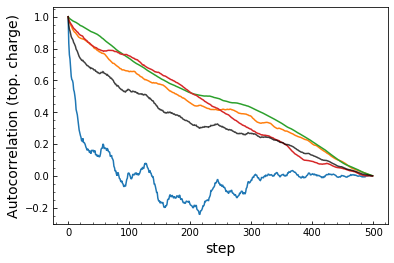

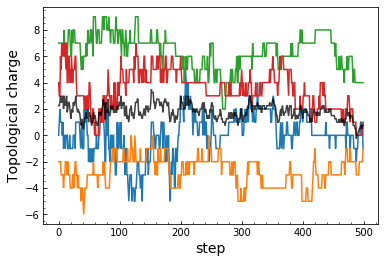

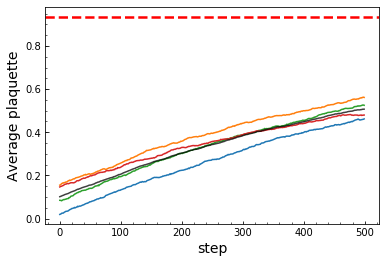

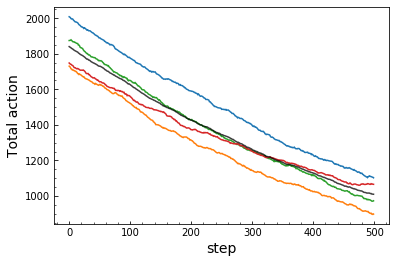

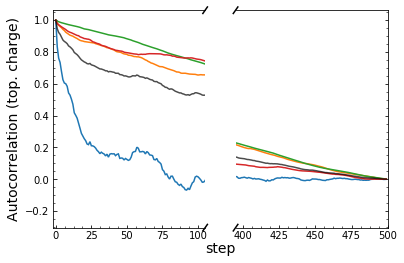

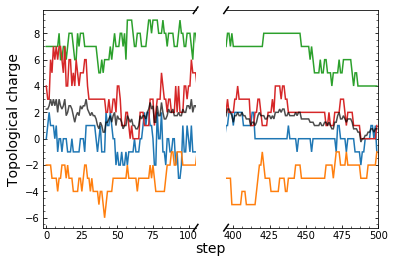

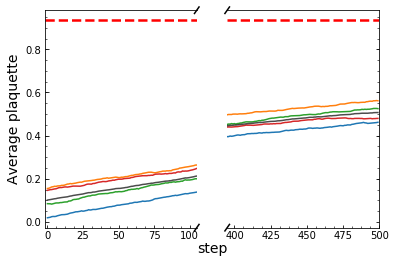

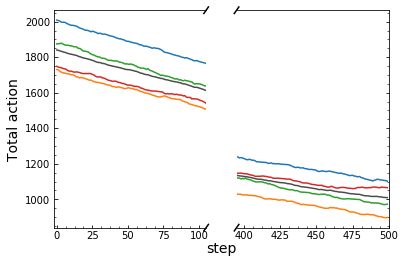

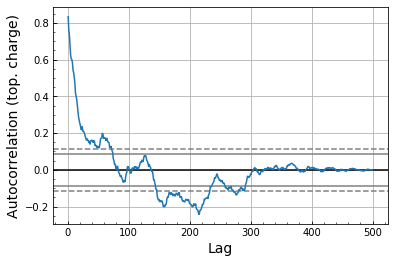

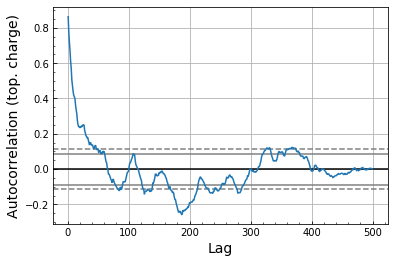

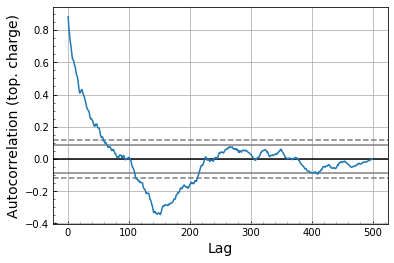

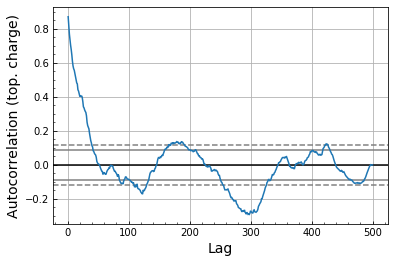

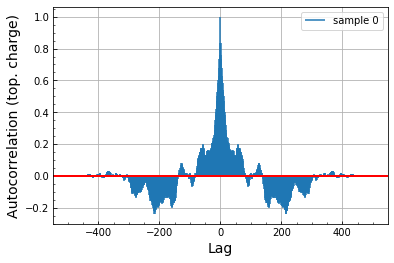

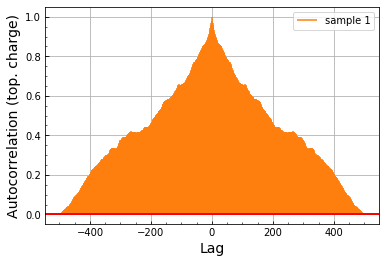

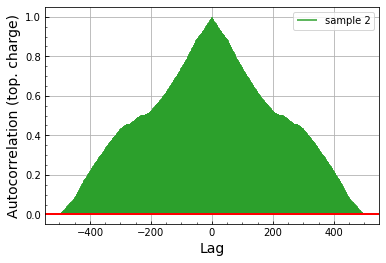

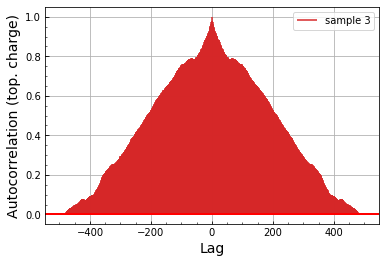

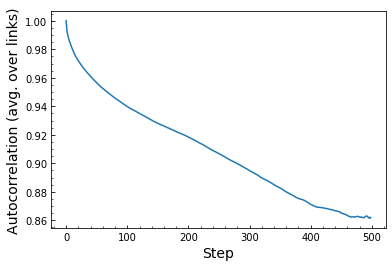

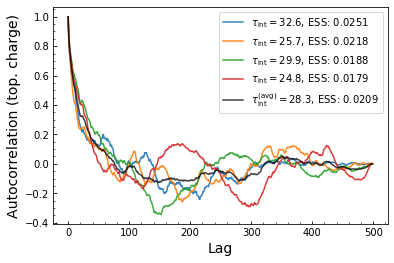

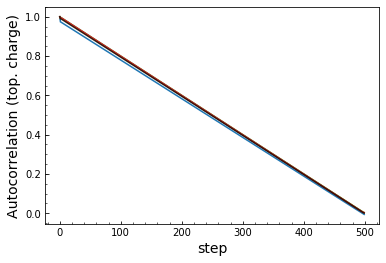

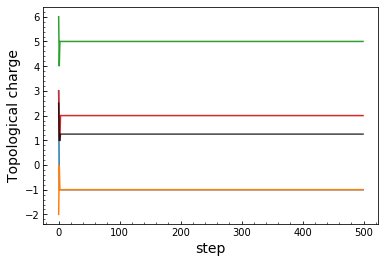

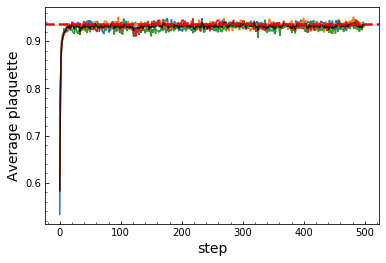

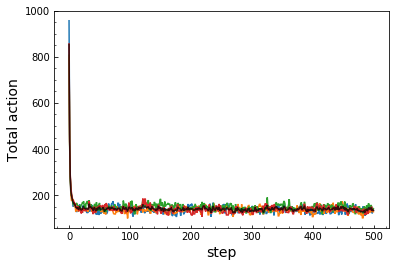

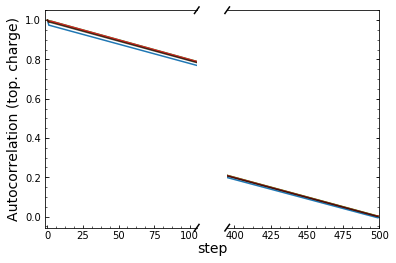

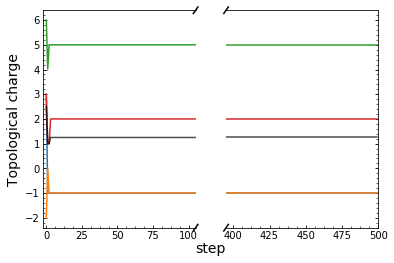

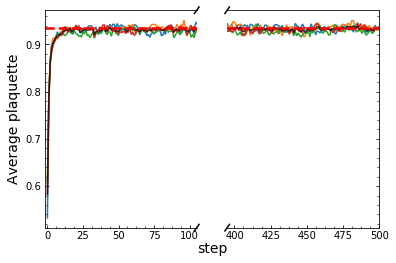

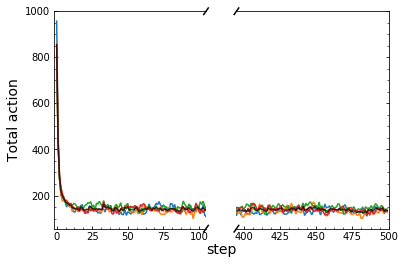

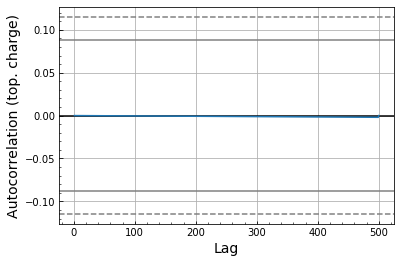

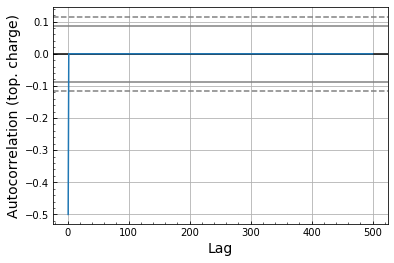

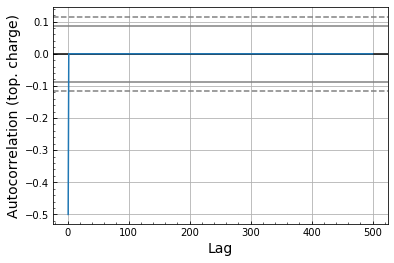

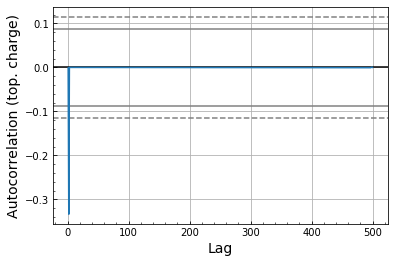

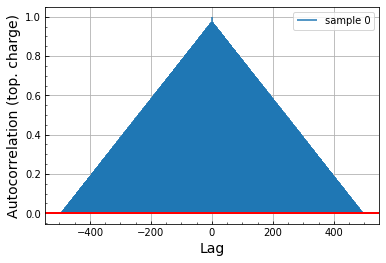

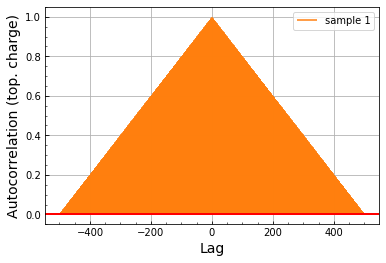

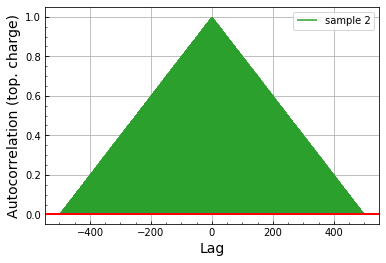

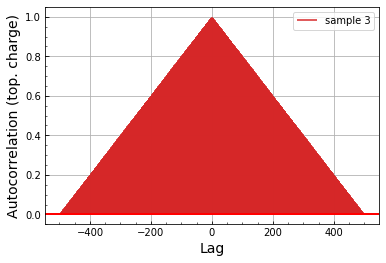

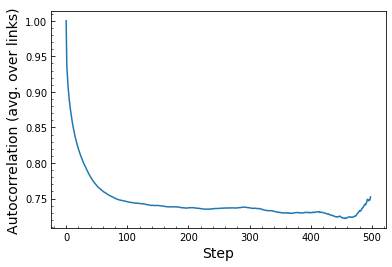

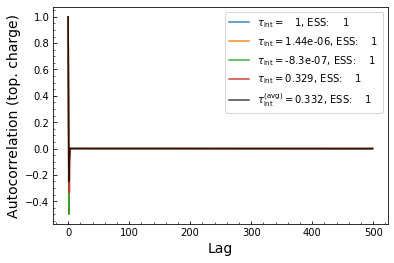

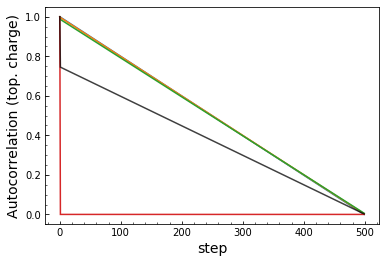

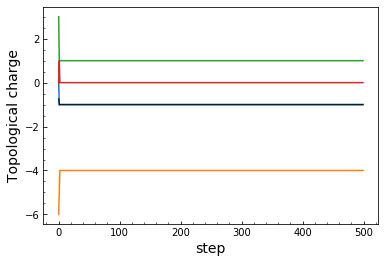

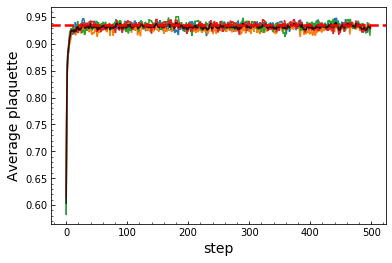

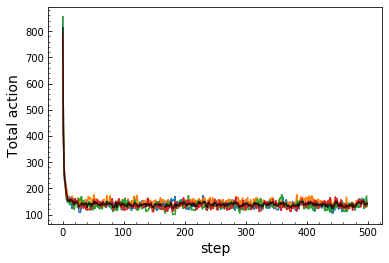

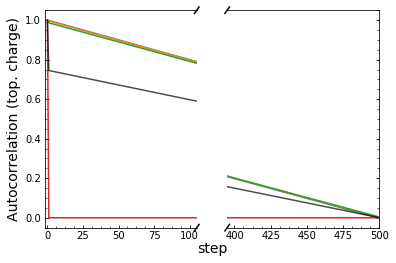

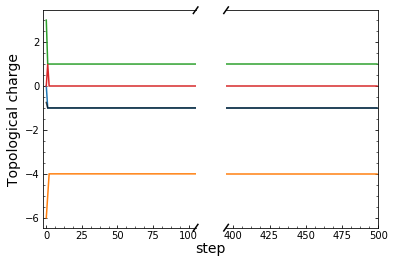

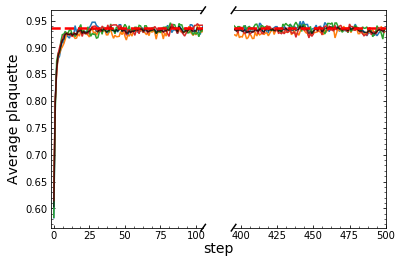

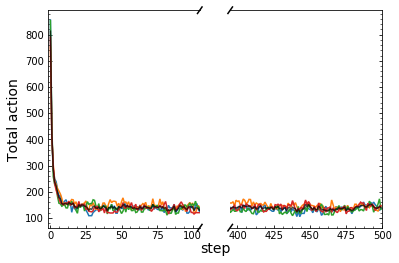

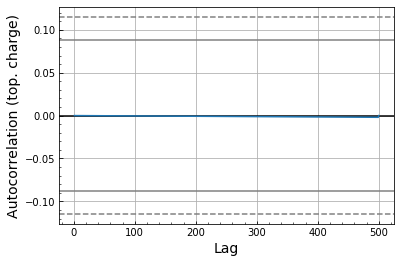

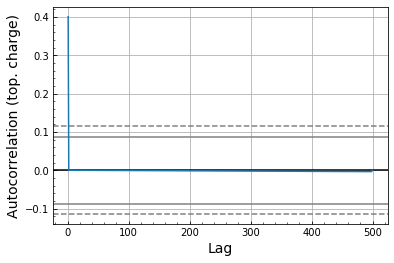

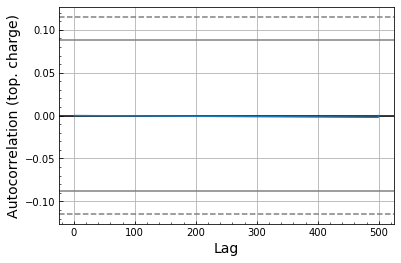

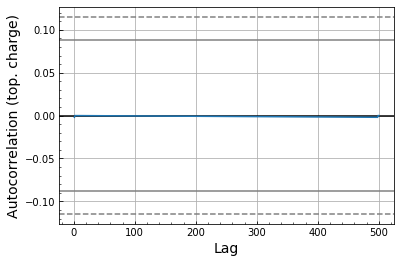

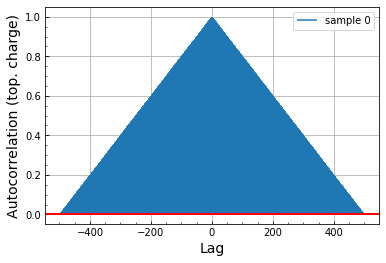

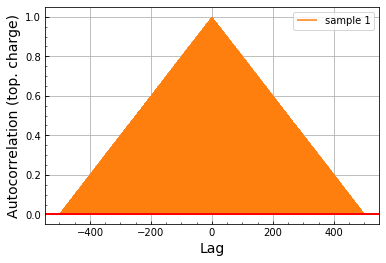

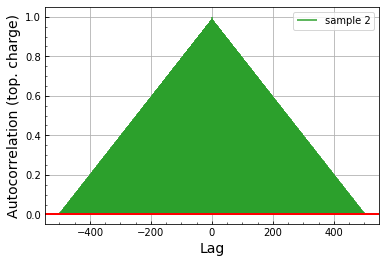

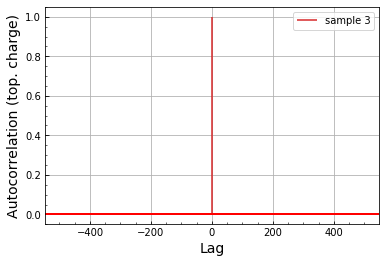

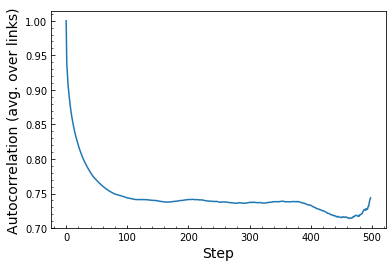

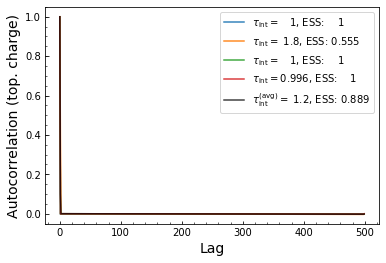

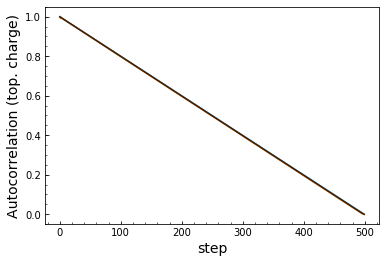

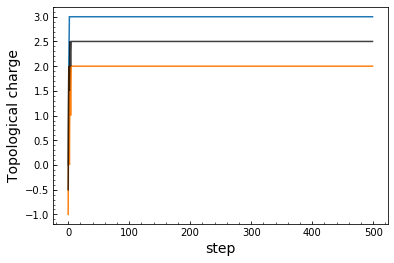

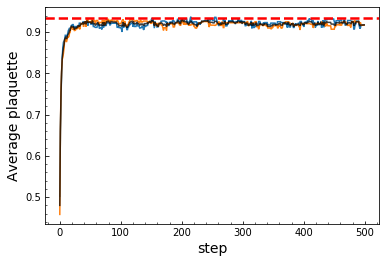

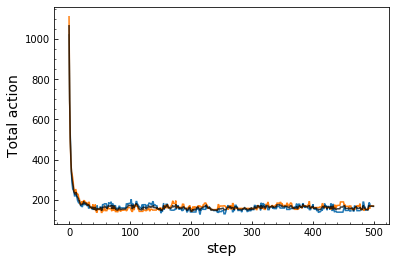

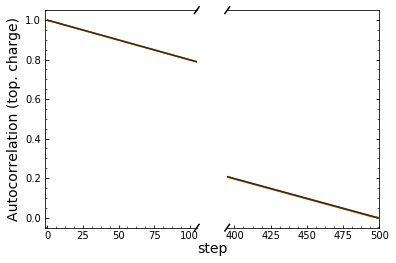

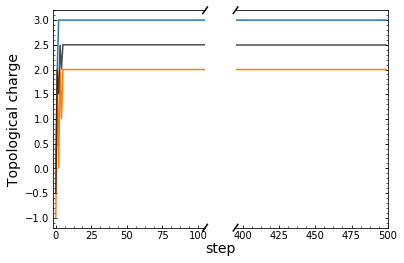

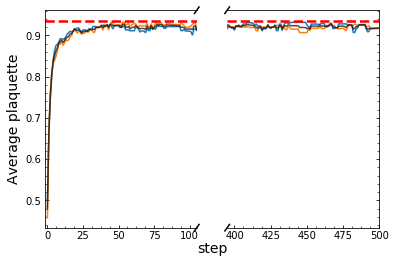

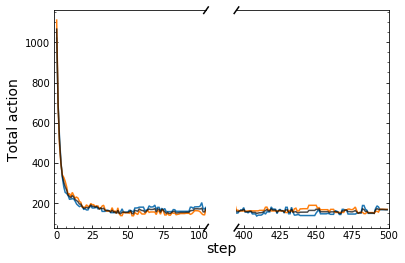

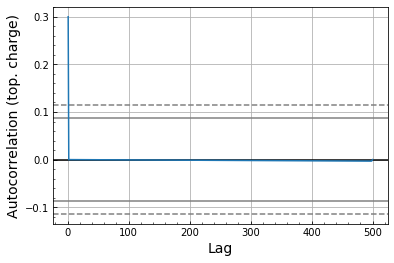

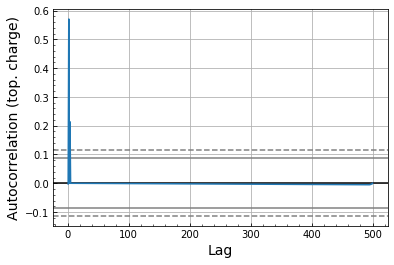

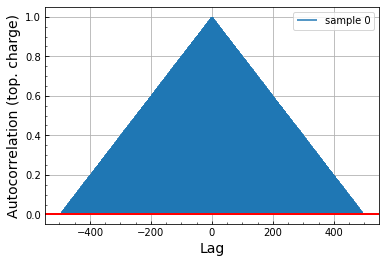

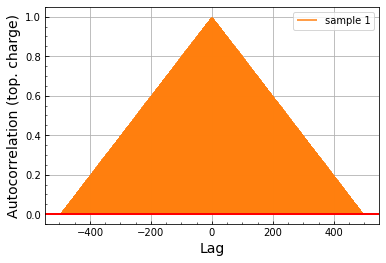

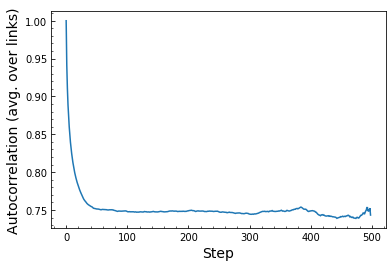

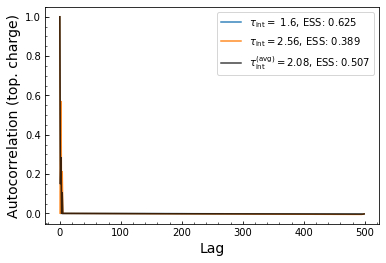

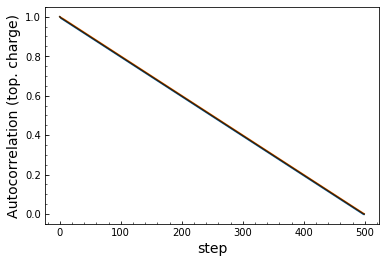

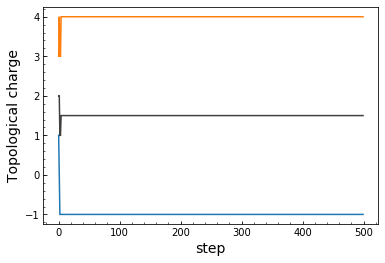

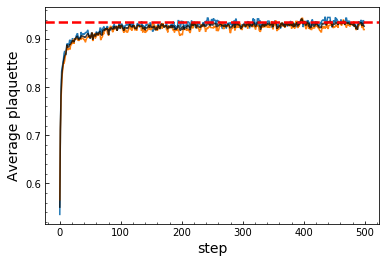

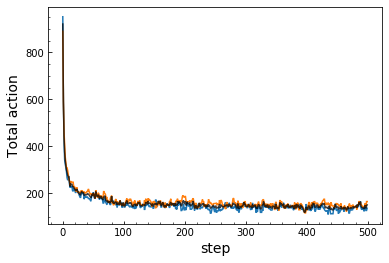

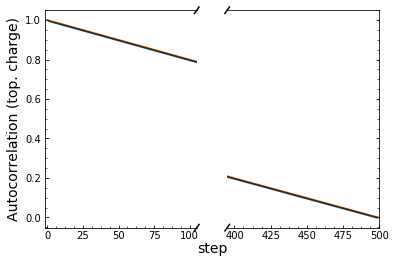

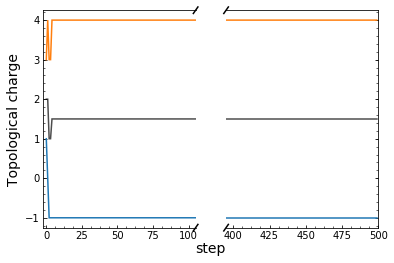

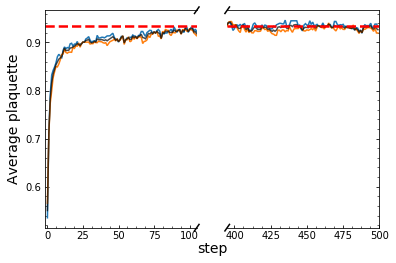

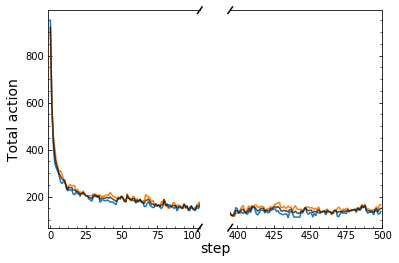

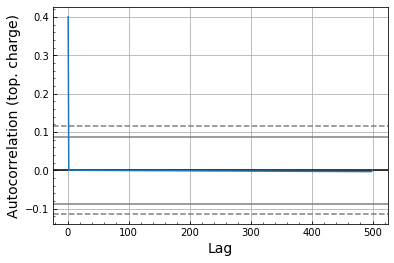

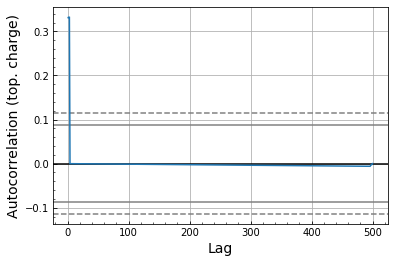

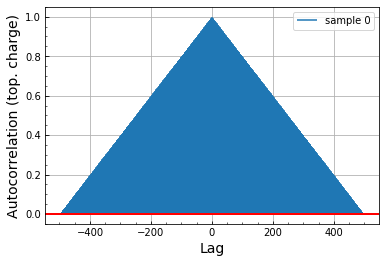

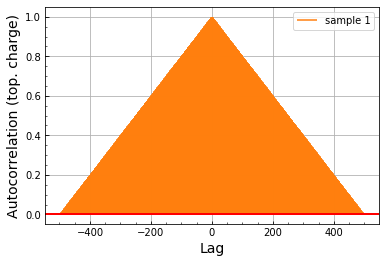

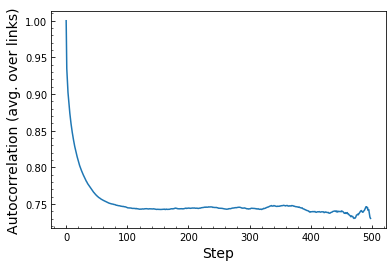

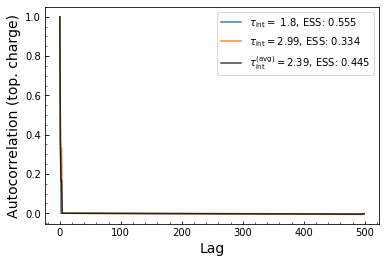

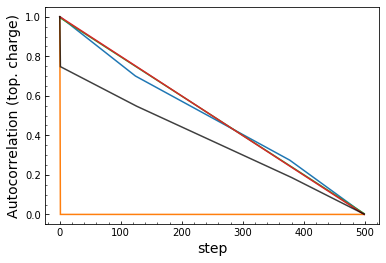

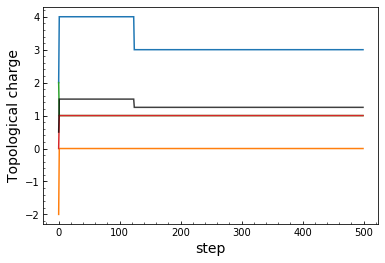

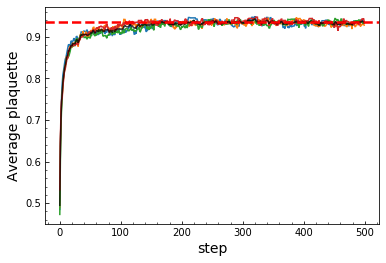

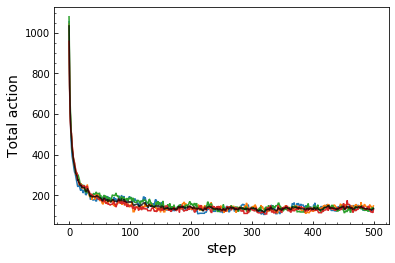

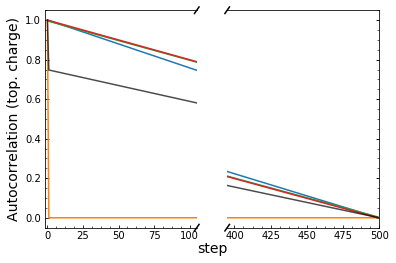

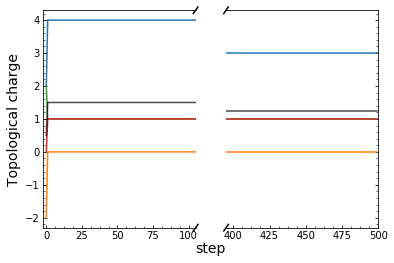

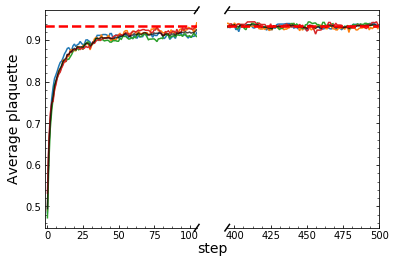

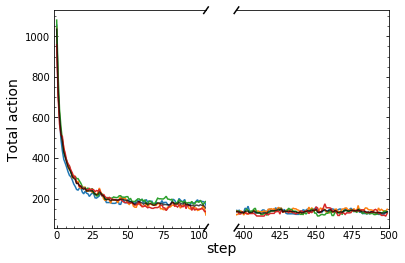

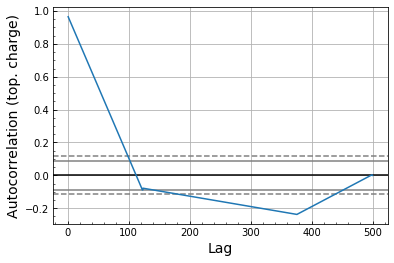

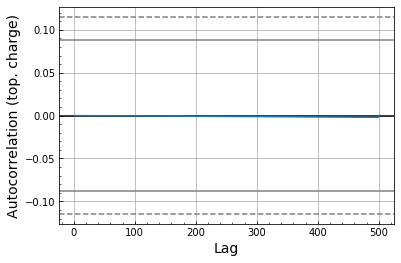

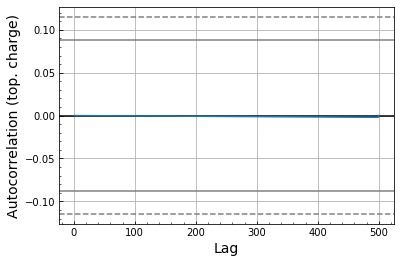

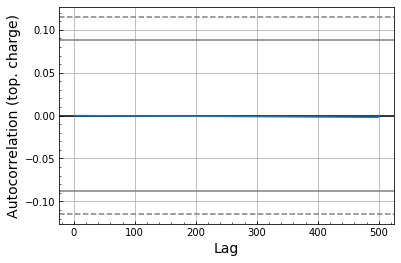

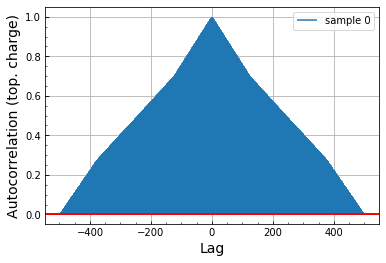

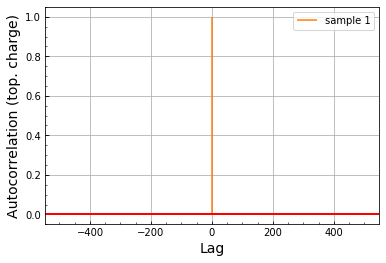

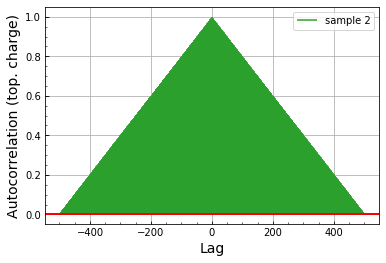

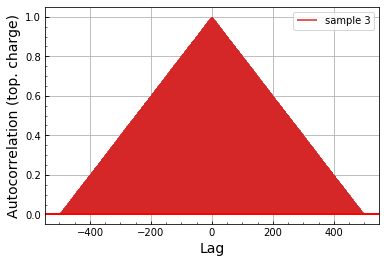

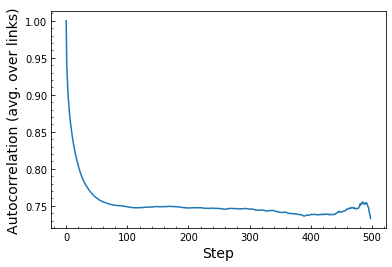

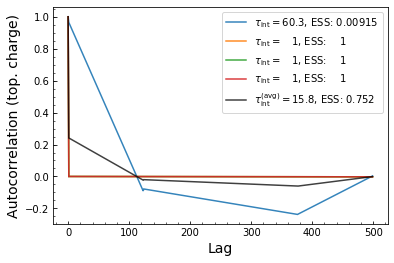

In [8]:
bad_dirs = []
for log_dir in log_dirs:
    try:
        calc_observables_generate_plots(log_dir)
    except:
        bad_dirs.append(log_dir)
        continue

In [6]:
lattice = GaugeLattice(time_size=8, 
                       space_size=8,
                       dim=2, 
                       beta=8., 
                       link_type='U1',
                       num_samples=5,
                       rand=False)

In [7]:
lattice.links.shape

(8, 8, 2)

## Calculate observables and create plots step by step, dir by dir...

In [72]:
log_dir = (
    '../../gauge_logs_graph/run_144/'
)

figs_dir = os.path.join(log_dir, 'figures')
autocorr_dir = os.path.join(figs_dir, 'autocorrelation_plots')
check_else_make_dir(autocorr_dir)

Making directory: ../../gauge_logs_graph/run_144/figures/autocorrelation_plots


### Calculate observables

In [73]:
params, samples, observables = calc_observables_from_log_dir(log_dir)
if isinstance(observables, dict):
    actions = {}
    avg_plaquettes = {}
    top_charges = {}
    for key, val in observables.items():
        _actions, _avg_plaquettes, _top_charges = val
        actions[key] = _actions
        avg_plaquettes[key] = _avg_plaquettes
        top_charges[key] = _top_charges
else:
    actions, avg_plaquettes, top_charges = observables

print('\n' + 80 * '-')
for key, val in params.items():
    print(f'{key}: {val}')
print(80 * '-')

Loading samples history from: ../../gauge_logs_graph/run_144/samples_history/samples_history_500.pkl.
Reading samples from ../../gauge_logs_graph/run_144/samples_history/samples_history_500.pkl.
Loading samples history from: ../../gauge_logs_graph/run_144/samples_history/samples_history_1000.pkl.
Reading samples from ../../gauge_logs_graph/run_144/samples_history/samples_history_1000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_144/samples_history/samples_history_100.pkl.
Reading samples from ../../gauge_logs_graph/run_144/samples_history/samples_history_100.pkl.
Loading samples history from: ../../gauge_logs_graph/run_144/samples_history/samples_history_200.pkl.
Reading samples from ../../gauge_logs_graph/run_144/samples_history/samples_history_200.pkl.
Loading samples history from: ../../gauge_logs_graph/run_144/samples_history/samples_history_5000.pkl.
Reading samples from ../../gauge_logs_graph/run_144/samples_history/samples_history_5000.pkl.
Unable to find ../../

step: 70 time/step: 0.05784 avg action: 45.73  avg plaquette: 0.9107 top charges: 


[2, 1, -2, 1, -2]


step: 71 time/step: 0.06447 avg action: 46.92  avg plaquette: 0.9084 top charges: 


[2, 1, -2, 1, -1]


step: 72 time/step: 0.05368 avg action: 49.31  avg plaquette: 0.9037 top charges: 


[1, 2, -2, 1, -1]


step: 73 time/step: 0.05434 avg action: 41.89  avg plaquette: 0.9182 top charges: 


[1, 1, -1, 2, -2]


step: 74 time/step: 0.05657 avg action: 47.15  avg plaquette: 0.9079 top charges: 


[1, 2, -2, 2, -1]


step: 75 time/step: 0.06282 avg action: 46.58  avg plaquette: 0.909  top charges: 


[1, 1, -1, 2, -1]


step: 76 time/step: 0.05632 avg action: 44.55  avg plaquette: 0.913  top charges: 


[2, 1, -1, 2, -1]


step: 77 time/step: 0.05506 avg action: 40.51  avg plaquette: 0.9209 top charges: 


[2, 1, -2, 1, -2]


step: 78 time/step: 0.05383 avg action: 43.98  avg plaquette: 0.9141 top charges: 


[2, 2, -2, 1, -1]


step: 79 time/step: 0.05618 avg action: 47.13  avg plaq

step: 149 time/step: 0.05702 avg action: 41.27  avg plaquette: 0.9194 top charges: 


[1, 2, -1, 1, -2]


step: 150 time/step: 0.05707 avg action: 38.62  avg plaquette: 0.9246 top charges: 


[1, 1, -1, 2, -2]


step: 151 time/step: 0.05463 avg action: 44.51  avg plaquette: 0.9131 top charges: 


[1, 1, -1, 2, -2]


step: 152 time/step: 0.05811 avg action: 44.19  avg plaquette: 0.9137 top charges: 


[2, 2, -2, 2, -2]


step: 153 time/step: 0.05645 avg action: 43.47  avg plaquette: 0.9151 top charges: 


[1, 2, -1, 2, -1]


step: 154 time/step: 0.05844 avg action:  44.5  avg plaquette: 0.9131 top charges: 


[1, 1, -1, 1, -2]


step: 155 time/step: 0.05804 avg action: 46.47  avg plaquette: 0.9092 top charges: 


[1, 2, -2, 1, -1]


step: 156 time/step: 0.05999 avg action: 41.48  avg plaquette: 0.919  top charges: 


[1, 2, -1, 2, -1]


step: 157 time/step: 0.05891 avg action: 42.15  avg plaquette: 0.9177 top charges: 


[1, 2, -1, 2, -2]


step: 158 time/step: 0.05812 avg action: 43.74

step: 230 time/step: 0.05288 avg action: 44.31  avg plaquette: 0.9135 top charges: 


[1, 1, -1, 2, -1]


step: 231 time/step: 0.05609 avg action:  44.4  avg plaquette: 0.9133 top charges: 


[1, 1, -1, 2, -2]


step: 232 time/step: 0.05611 avg action: 40.65  avg plaquette: 0.9206 top charges: 


[1, 2, -2, 1, -1]


step: 233 time/step: 0.05939 avg action: 45.67  avg plaquette: 0.9108 top charges: 


[2, 1, -1, 2, -1]


step: 234 time/step: 0.05748 avg action: 42.61  avg plaquette: 0.9168 top charges: 


[2, 1, -1, 1, -1]


step: 235 time/step: 0.05671 avg action: 46.25  avg plaquette: 0.9097 top charges: 


[2, 1, -2, 1, -1]


step: 236 time/step: 0.05447 avg action: 39.57  avg plaquette: 0.9227 top charges: 


[2, 1, -1, 1, -2]


step: 237 time/step: 0.05378 avg action: 42.48  avg plaquette: 0.917  top charges: 


[1, 2, -1, 2, -2]


step: 238 time/step: 0.05611 avg action: 41.89  avg plaquette: 0.9182 top charges: 


[2, 2, -2, 1, -1]


step: 239 time/step: 0.05675 avg action: 44.31

step: 309 time/step: 0.08014 avg action:  45.3  avg plaquette: 0.9115 top charges: 


[2, 2, -1, 1, -1]


step: 310 time/step: 0.05648 avg action: 44.88  avg plaquette: 0.9123 top charges: 


[2, 2, -1, 1, -1]


step: 311 time/step: 0.05844 avg action: 43.42  avg plaquette: 0.9152 top charges: 


[1, 1, -1, 1, -1]


step: 312 time/step: 0.05536 avg action: 41.57  avg plaquette: 0.9188 top charges: 


[2, 2, -1, 2, -2]


step: 313 time/step: 0.05644 avg action: 46.76  avg plaquette: 0.9087 top charges: 


[1, 2, -1, 2, -2]


step: 314 time/step: 0.05779 avg action: 45.63  avg plaquette: 0.9109 top charges: 


[1, 2, -1, 2, -2]


step: 315 time/step: 0.05525 avg action: 46.95  avg plaquette: 0.9083 top charges: 


[1, 2, -2, 1, -2]


step: 316 time/step: 0.06459 avg action: 44.74  avg plaquette: 0.9126 top charges: 


[2, 2, -2, 2, -1]


step: 317 time/step: 0.06058 avg action: 45.96  avg plaquette: 0.9102 top charges: 


[1, 2, -1, 2, -1]


step: 318 time/step: 0.05544 avg action:  46.7

step: 390 time/step: 0.05549 avg action: 45.77  avg plaquette: 0.9106 top charges: 


[2, 2, -2, 1, -2]


step: 391 time/step: 0.05839 avg action: 43.06  avg plaquette: 0.9159 top charges: 


[1, 1, -2, 2, -2]


step: 392 time/step: 0.05638 avg action: 43.32  avg plaquette: 0.9154 top charges: 


[2, 1, -2, 2, -1]


step: 393 time/step: 0.0601 avg action: 40.42  avg plaquette: 0.921  top charges: 


[1, 2, -1, 2, -2]


step: 394 time/step: 0.05295 avg action: 42.17  avg plaquette: 0.9176 top charges: 


[1, 1, -2, 1, -1]


step: 395 time/step: 0.05138 avg action: 48.22  avg plaquette: 0.9058 top charges: 


[1, 1, -1, 1, -1]


step: 396 time/step: 0.05232 avg action: 47.46  avg plaquette: 0.9073 top charges: 


[1, 2, -1, 1, -2]


step: 397 time/step: 0.05147 avg action: 41.93  avg plaquette: 0.9181 top charges: 


[2, 2, -1, 2, -1]


step: 398 time/step: 0.0547 avg action: 44.19  avg plaquette: 0.9137 top charges: 


[2, 2, -2, 1, -2]


step: 399 time/step: 0.05369 avg action:  41.3  

step: 470 time/step: 0.05488 avg action: 45.17  avg plaquette: 0.9118 top charges: 


[1, 2, -2, 2, -1]


step: 471 time/step: 0.05823 avg action: 46.98  avg plaquette: 0.9082 top charges: 


[2, 1, -2, 2, -2]


step: 472 time/step: 0.05623 avg action: 45.13  avg plaquette: 0.9119 top charges: 


[2, 2, -2, 2, -2]


step: 473 time/step: 0.05787 avg action: 44.33  avg plaquette: 0.9134 top charges: 


[2, 1, -2, 2, -1]


step: 474 time/step: 0.06273 avg action: 48.42  avg plaquette: 0.9054 top charges: 


[1, 1, -1, 1, -2]


step: 475 time/step: 0.06313 avg action: 48.46  avg plaquette: 0.9053 top charges: 


[2, 1, -2, 2, -2]


step: 476 time/step: 0.05699 avg action: 43.43  avg plaquette: 0.9152 top charges: 


[1, 2, -1, 2, -1]


step: 477 time/step: 0.05901 avg action: 42.19  avg plaquette: 0.9176 top charges: 


[1, 1, -2, 2, -1]


step: 478 time/step: 0.05966 avg action: 45.25  avg plaquette: 0.9116 top charges: 


[1, 2, -2, 2, -1]


step: 479 time/step: 0.06146 avg action: 44.72

step: 50 time/step: 0.05797 avg action: 36.25  avg plaquette: 0.9292 top charges: 


[-1, 0, 0, -1, 0]


step: 51 time/step: 0.06384 avg action: 36.42  avg plaquette: 0.9289 top charges: 


[-1, 0, 0, -2, 0]


step: 52 time/step: 0.0612 avg action: 40.44  avg plaquette: 0.921  top charges: 


[-1, 0, 0, -1, 0]


step: 53 time/step: 0.06754 avg action: 35.08  avg plaquette: 0.9315 top charges: 


[0, 0, 0, -1, 0]


step: 54 time/step: 0.06127 avg action: 37.51  avg plaquette: 0.9267 top charges: 


[-1, 1, 0, -1, 0]


step: 55 time/step: 0.06128 avg action: 36.04  avg plaquette: 0.9296 top charges: 


[-1, 1, 0, -2, 0]


step: 56 time/step: 0.05872 avg action: 37.74  avg plaquette: 0.9263 top charges: 


[-1, 0, 0, -1, 0]


step: 57 time/step: 0.05756 avg action: 39.03  avg plaquette: 0.9238 top charges: 


[0, 0, 0, -2, 0]


step: 58 time/step: 0.05711 avg action: 34.59  avg plaquette: 0.9324 top charges: 


[0, 1, 0, -2, 0]


step: 59 time/step: 0.05776 avg action: 35.45  avg plaquett

step: 130 time/step: 0.06003 avg action: 36.42  avg plaquette: 0.9289 top charges: 


[-1, 0, 0, -2, 0]


step: 131 time/step: 0.05956 avg action:  36.9  avg plaquette: 0.9279 top charges: 


[0, 1, 0, -1, 0]


step: 132 time/step: 0.05758 avg action: 36.48  avg plaquette: 0.9287 top charges: 


[0, 1, 0, -2, 0]


step: 133 time/step: 0.05813 avg action:  38.5  avg plaquette: 0.9248 top charges: 


[0, 0, 0, -1, 0]


step: 134 time/step: 0.0596 avg action: 34.84  avg plaquette: 0.932  top charges: 


[-1, 0, 0, -1, 0]


step: 135 time/step: 0.05836 avg action: 39.03  avg plaquette: 0.9238 top charges: 


[-1, 0, 0, -2, 0]


step: 136 time/step: 0.05381 avg action: 33.06  avg plaquette: 0.9354 top charges: 


[-1, 0, 0, -2, 0]


step: 137 time/step: 0.05035 avg action: 32.94  avg plaquette: 0.9357 top charges: 


[-1, 0, 0, -2, 0]


step: 138 time/step: 0.05093 avg action:  37.4  avg plaquette: 0.9269 top charges: 


[-1, 0, 0, -2, 0]


step: 139 time/step: 0.05357 avg action: 35.42  av

step: 209 time/step: 0.07875 avg action: 41.54  avg plaquette: 0.9189 top charges: 


[-1, 0, 0, -2, 0]


step: 210 time/step: 0.06546 avg action: 40.58  avg plaquette: 0.9207 top charges: 


[-1, 1, 0, -1, 0]


step: 211 time/step: 0.06335 avg action: 39.13  avg plaquette: 0.9236 top charges: 


[-1, 0, 0, -1, 0]


step: 212 time/step: 0.06491 avg action: 38.32  avg plaquette: 0.9252 top charges: 


[0, 0, 0, -1, 0]


step: 213 time/step: 0.07064 avg action: 37.77  avg plaquette: 0.9262 top charges: 


[0, 1, 0, -2, 0]


step: 214 time/step: 0.06652 avg action: 37.91  avg plaquette: 0.9259 top charges: 


[0, 0, 0, -2, 0]


step: 215 time/step: 0.06495 avg action: 40.93  avg plaquette: 0.9201 top charges: 


[-1, 0, 0, -1, 0]


step: 216 time/step: 0.06345 avg action:  38.7  avg plaquette: 0.9244 top charges: 


[0, 0, 0, -1, 0]


step: 217 time/step: 0.06878 avg action: 32.31  avg plaquette: 0.9369 top charges: 


[0, 0, 0, -2, 0]


step: 218 time/step: 0.07715 avg action: 31.41  avg

step: 288 time/step: 0.0603 avg action: 39.24  avg plaquette: 0.9234 top charges: 


[-1, 0, 0, -1, 0]


step: 289 time/step: 0.05891 avg action: 38.87  avg plaquette: 0.9241 top charges: 


[-1, 1, 0, -1, 0]


step: 290 time/step: 0.05699 avg action:  39.2  avg plaquette: 0.9234 top charges: 


[0, 1, 0, -2, 0]


step: 291 time/step: 0.05689 avg action: 40.01  avg plaquette: 0.9219 top charges: 


[-1, 0, 0, -1, 0]


step: 292 time/step: 0.05801 avg action: 33.35  avg plaquette: 0.9349 top charges: 


[0, 0, 0, -2, 0]


step: 293 time/step: 0.05902 avg action: 35.27  avg plaquette: 0.9311 top charges: 


[-1, 1, 0, -2, 0]


step: 294 time/step: 0.05724 avg action: 38.22  avg plaquette: 0.9253 top charges: 


[-1, 0, 0, -2, 0]


step: 295 time/step: 0.05687 avg action: 34.37  avg plaquette: 0.9329 top charges: 


[-1, 1, 0, -2, 0]


step: 296 time/step: 0.05599 avg action: 34.17  avg plaquette: 0.9333 top charges: 


[-1, 0, 0, -1, 0]


step: 297 time/step: 0.05925 avg action: 31.85  a

step: 368 time/step: 0.05168 avg action: 33.39  avg plaquette: 0.9348 top charges: 


[0, 1, 0, -1, 0]


step: 369 time/step: 0.05631 avg action: 33.37  avg plaquette: 0.9348 top charges: 


[-1, 1, 0, -2, 0]


step: 370 time/step: 0.05337 avg action: 31.49  avg plaquette: 0.9385 top charges: 


[0, 1, 0, -1, 0]


step: 371 time/step: 0.05224 avg action: 34.77  avg plaquette: 0.9321 top charges: 


[-1, 0, 0, -1, 0]


step: 372 time/step: 0.05734 avg action: 36.18  avg plaquette: 0.9293 top charges: 


[-1, 0, 0, -1, 0]


step: 373 time/step: 0.06165 avg action: 38.53  avg plaquette: 0.9247 top charges: 


[0, 1, 0, -1, 0]


step: 374 time/step: 0.05879 avg action: 42.09  avg plaquette: 0.9178 top charges: 


[0, 1, 0, -2, 0]


step: 375 time/step: 0.05808 avg action: 32.92  avg plaquette: 0.9357 top charges: 


[-1, 0, 0, -1, 0]


step: 376 time/step: 0.0615 avg action: 38.96  avg plaquette: 0.9239 top charges: 


[-1, 1, 0, -2, 0]


step: 377 time/step: 0.05938 avg action: 38.33  avg

step: 448 time/step: 0.05487 avg action: 39.52  avg plaquette: 0.9228 top charges: 


[-1, 1, 0, -1, 0]


step: 449 time/step: 0.05724 avg action: 41.82  avg plaquette: 0.9183 top charges: 


[-1, 0, 0, -1, 0]


step: 450 time/step: 0.05438 avg action: 38.55  avg plaquette: 0.9247 top charges: 


[0, 0, 0, -1, 0]


step: 451 time/step: 0.0544 avg action: 40.86  avg plaquette: 0.9202 top charges: 


[0, 0, 0, -2, 0]


step: 452 time/step: 0.05639 avg action: 40.05  avg plaquette: 0.9218 top charges: 


[0, 1, 0, -2, 0]


step: 453 time/step: 0.05554 avg action:  42.2  avg plaquette: 0.9176 top charges: 


[0, 1, 0, -1, 0]


step: 454 time/step: 0.0549 avg action:  41.1  avg plaquette: 0.9197 top charges: 


[-1, 0, 0, -2, 0]


step: 455 time/step: 0.05458 avg action: 34.23  avg plaquette: 0.9331 top charges: 


[-1, 1, 0, -1, 0]


step: 456 time/step: 0.05576 avg action: 38.25  avg plaquette: 0.9253 top charges: 


[0, 0, 0, -1, 0]


step: 457 time/step: 0.07809 avg action: 37.28  avg p

step: 528 time/step: 0.06215 avg action: 32.56  avg plaquette: 0.9364 top charges: 


[0, 1, 0, -1, 0]


step: 529 time/step: 0.05376 avg action: 36.66  avg plaquette: 0.9284 top charges: 


[0, 0, 0, -2, 0]


step: 530 time/step: 0.05566 avg action: 36.79  avg plaquette: 0.9282 top charges: 


[0, 0, 0, -2, 0]


step: 531 time/step: 0.05672 avg action: 37.02  avg plaquette: 0.9277 top charges: 


[0, 0, 0, -2, 0]


step: 532 time/step: 0.05658 avg action: 35.31  avg plaquette: 0.931  top charges: 


[0, 1, 0, -2, 0]


step: 533 time/step: 0.05569 avg action:  34.1  avg plaquette: 0.9334 top charges: 


[-1, 0, 0, -1, 0]


step: 534 time/step: 0.05585 avg action: 33.34  avg plaquette: 0.9349 top charges: 


[0, 0, 0, -2, 0]


step: 535 time/step: 0.05593 avg action:  33.7  avg plaquette: 0.9342 top charges: 


[0, 0, 0, -2, 0]


step: 536 time/step: 0.05694 avg action: 32.97  avg plaquette: 0.9356 top charges: 


[0, 0, 0, -2, 0]


step: 537 time/step: 0.05607 avg action: 37.22  avg pl

step: 608 time/step: 0.05845 avg action: 34.12  avg plaquette: 0.9334 top charges: 


[0, 1, 0, -2, 0]


step: 609 time/step: 0.05843 avg action: 35.68  avg plaquette: 0.9303 top charges: 


[0, 0, 0, -1, 0]


step: 610 time/step: 0.05334 avg action: 38.27  avg plaquette: 0.9253 top charges: 


[-1, 0, 0, -2, 0]


step: 611 time/step: 0.05328 avg action:  36.7  avg plaquette: 0.9283 top charges: 


[-1, 0, 0, -1, 0]


step: 612 time/step: 0.05236 avg action: 40.65  avg plaquette: 0.9206 top charges: 


[-1, 0, 0, -2, 0]


step: 613 time/step: 0.05279 avg action: 42.61  avg plaquette: 0.9168 top charges: 


[-1, 0, 0, -1, 0]


step: 614 time/step: 0.05297 avg action: 43.28  avg plaquette: 0.9155 top charges: 


[0, 1, 0, -2, 0]


step: 615 time/step: 0.05119 avg action: 38.58  avg plaquette: 0.9246 top charges: 


[-1, 0, 0, -2, 0]


step: 616 time/step: 0.05372 avg action: 39.42  avg plaquette: 0.923  top charges: 


[0, 1, 0, -1, 0]


step: 617 time/step: 0.05594 avg action: 37.37  av

step: 688 time/step: 0.05679 avg action: 38.49  avg plaquette: 0.9248 top charges: 


[-1, 1, 0, -2, 0]


step: 689 time/step: 0.06013 avg action: 36.03  avg plaquette: 0.9296 top charges: 


[-1, 1, 0, -2, 0]


step: 690 time/step: 0.05601 avg action: 35.72  avg plaquette: 0.9302 top charges: 


[0, 1, 0, -2, 0]


step: 691 time/step: 0.05577 avg action: 37.76  avg plaquette: 0.9262 top charges: 


[0, 0, 0, -2, 0]


step: 692 time/step: 0.05767 avg action: 44.19  avg plaquette: 0.9137 top charges: 


[-1, 0, 0, -2, 0]


step: 693 time/step: 0.05963 avg action: 43.29  avg plaquette: 0.9155 top charges: 


[-1, 1, 0, -2, 0]


step: 694 time/step: 0.06327 avg action: 38.07  avg plaquette: 0.9257 top charges: 


[0, 1, 0, -1, 0]


step: 695 time/step: 0.06362 avg action: 35.49  avg plaquette: 0.9307 top charges: 


[-1, 1, 0, -1, 0]


step: 696 time/step: 0.07006 avg action: 34.02  avg plaquette: 0.9336 top charges: 


[0, 0, 0, -1, 0]


step: 697 time/step: 0.06308 avg action: 35.63  av

step: 769 time/step: 0.05777 avg action: 42.21  avg plaquette: 0.9176 top charges: 


[0, 0, 0, -1, 0]


step: 770 time/step: 0.05776 avg action: 32.39  avg plaquette: 0.9367 top charges: 


[0, 1, 0, -2, 0]


step: 771 time/step: 0.05654 avg action: 31.26  avg plaquette: 0.9389 top charges: 


[0, 1, 0, -1, 0]


step: 772 time/step: 0.05669 avg action: 38.89  avg plaquette: 0.924  top charges: 


[0, 0, 0, -1, 0]


step: 773 time/step: 0.05649 avg action:  35.1  avg plaquette: 0.9314 top charges: 


[-1, 0, 0, -1, 0]


step: 774 time/step: 0.05664 avg action: 33.49  avg plaquette: 0.9346 top charges: 


[-1, 1, 0, -1, 0]


step: 775 time/step: 0.05494 avg action: 38.56  avg plaquette: 0.9247 top charges: 


[-1, 0, 0, -1, 0]


step: 776 time/step: 0.05543 avg action: 40.09  avg plaquette: 0.9217 top charges: 


[-1, 0, 0, -1, 0]


step: 777 time/step: 0.05736 avg action: 37.53  avg plaquette: 0.9267 top charges: 


[-1, 1, 0, -1, 0]


step: 778 time/step: 0.05512 avg action: 37.32  av

step: 849 time/step: 0.04968 avg action: 37.43  avg plaquette: 0.9269 top charges: 


[0, 1, 0, -1, 0]


step: 850 time/step: 0.05253 avg action:  36.6  avg plaquette: 0.9285 top charges: 


[-1, 1, 0, -2, 0]


step: 851 time/step: 0.05008 avg action: 36.14  avg plaquette: 0.9294 top charges: 


[0, 0, 0, -2, 0]


step: 852 time/step: 0.05346 avg action: 40.88  avg plaquette: 0.9201 top charges: 


[-1, 1, 0, -2, 0]


step: 853 time/step: 0.05272 avg action: 41.99  avg plaquette: 0.918  top charges: 


[-1, 0, 0, -2, 0]


step: 854 time/step: 0.0586 avg action: 41.14  avg plaquette: 0.9196 top charges: 


[0, 1, 0, -2, 0]


step: 855 time/step: 0.05438 avg action: 39.53  avg plaquette: 0.9228 top charges: 


[-1, 0, 0, -2, 0]


step: 856 time/step: 0.05535 avg action: 39.02  avg plaquette: 0.9238 top charges: 


[0, 1, 0, -1, 0]


step: 857 time/step: 0.05864 avg action: 38.04  avg plaquette: 0.9257 top charges: 


[-1, 1, 0, -1, 0]


step: 858 time/step: 0.05931 avg action: 32.13  avg

step: 929 time/step: 0.05524 avg action: 37.38  avg plaquette: 0.927  top charges: 


[0, 1, 0, -1, 0]


step: 930 time/step: 0.05535 avg action: 37.26  avg plaquette: 0.9272 top charges: 


[-1, 1, 0, -1, 0]


step: 931 time/step: 0.06367 avg action: 36.24  avg plaquette: 0.9292 top charges: 


[0, 1, 0, -2, 0]


step: 932 time/step: 0.07482 avg action:  34.3  avg plaquette: 0.933  top charges: 


[0, 1, 0, -1, 0]


step: 933 time/step: 0.07164 avg action:   35   avg plaquette: 0.9316 top charges: 


[0, 0, 0, -2, 0]


step: 934 time/step: 0.08033 avg action: 31.97  avg plaquette: 0.9376 top charges: 


[0, 1, 0, -2, 0]


step: 935 time/step: 0.06649 avg action: 36.87  avg plaquette: 0.928  top charges: 


[-1, 1, 0, -1, 0]


step: 936 time/step: 0.06779 avg action: 39.62  avg plaquette: 0.9226 top charges: 


[0, 1, 0, -2, 0]


step: 937 time/step:  0.07  avg action: 35.53  avg plaquette: 0.9306 top charges: 


[0, 1, 0, -2, 0]


step: 938 time/step: 0.07289 avg action:  36.2  avg pl

step: 7 time/step: 0.05323 avg action: 55.94  avg plaquette: 0.8907 top charges: 


[-1, -1, -1, -1, -5]


step: 8 time/step: 0.05563 avg action:  53.8  avg plaquette: 0.8949 top charges: 


[-2, -2, 0, -1, -5]


step: 9 time/step: 0.05456 avg action: 54.74  avg plaquette: 0.8931 top charges: 


[-1, -2, 0, -1, -4]


step: 10 time/step: 0.05272 avg action: 52.95  avg plaquette: 0.8966 top charges: 


[-2, -1, -1, -2, -5]


step: 11 time/step: 0.05435 avg action: 51.58  avg plaquette: 0.8993 top charges: 


[-2, -2, 0, -2, -4]


step: 12 time/step: 0.05411 avg action: 55.55  avg plaquette: 0.8915 top charges: 


[-2, -2, 0, -1, -5]


step: 13 time/step: 0.05291 avg action:  56.5  avg plaquette: 0.8897 top charges: 


[-2, -1, 0, -2, -4]


step: 14 time/step: 0.05304 avg action: 56.45  avg plaquette: 0.8897 top charges: 


[-2, -1, -1, -2, -5]


step: 15 time/step: 0.05371 avg action: 53.86  avg plaquette: 0.8948 top charges: 


[-1, -2, -1, -2, -5]


step: 16 time/step: 0.05394 avg acti

step: 86 time/step: 0.05476 avg action: 50.67  avg plaquette: 0.901  top charges: 


[-1, -1, 0, -1, -4]


step: 87 time/step: 0.06253 avg action: 53.91  avg plaquette: 0.8947 top charges: 


[-2, -1, 0, -1, -4]


step: 88 time/step: 0.05582 avg action: 53.64  avg plaquette: 0.8952 top charges: 


[-1, -2, 0, -2, -4]


step: 89 time/step: 0.07677 avg action: 50.57  avg plaquette: 0.9012 top charges: 


[-1, -2, 0, -2, -5]


step: 90 time/step: 0.06632 avg action: 49.37  avg plaquette: 0.9036 top charges: 


[-2, -2, 0, -2, -5]


step: 91 time/step: 0.06741 avg action: 54.16  avg plaquette: 0.8942 top charges: 


[-1, -2, 0, -2, -4]


step: 92 time/step: 0.05453 avg action: 53.37  avg plaquette: 0.8958 top charges: 


[-1, -1, 0, -2, -5]


step: 93 time/step: 0.05531 avg action: 54.19  avg plaquette: 0.8942 top charges: 


[-1, -1, 0, -2, -4]


step: 94 time/step: 0.05414 avg action: 48.45  avg plaquette: 0.9054 top charges: 


[-1, -1, -1, -2, -5]


step: 95 time/step: 0.05461 avg acti

step: 66 time/step: 0.05073 avg action: 44.81  avg plaquette: 0.9125 top charges: 


[-2, -1, 0, 0, 3]


step: 67 time/step: 0.05869 avg action: 41.84  avg plaquette: 0.9183 top charges: 


[-2, -1, 0, 0, 3]


step: 68 time/step: 0.05438 avg action: 45.89  avg plaquette: 0.9104 top charges: 


[-2, 0, 0, 0, 3]


step: 69 time/step: 0.0538 avg action: 43.29  avg plaquette: 0.9155 top charges: 


[-2, -1, 0, 0, 2]


step: 70 time/step: 0.05371 avg action: 43.85  avg plaquette: 0.9144 top charges: 


[-3, 0, 0, -1, 2]


step: 71 time/step: 0.0541 avg action: 42.44  avg plaquette: 0.9171 top charges: 


[-3, -1, 0, 0, 3]


step: 72 time/step: 0.05299 avg action: 45.58  avg plaquette: 0.911  top charges: 


[-3, -1, 0, 0, 3]


step: 73 time/step: 0.0551 avg action: 42.72  avg plaquette: 0.9166 top charges: 


[-2, 0, 0, 0, 3]


step: 74 time/step: 0.05654 avg action: 39.56  avg plaquette: 0.9227 top charges: 


[-2, -1, 0, 0, 3]


step: 75 time/step: 0.05435 avg action:  41.7  avg plaquette

step: 146 time/step: 0.06241 avg action: 45.72  avg plaquette: 0.9107 top charges: 


[-3, 0, 0, -1, 3]


step: 147 time/step: 0.06922 avg action: 44.48  avg plaquette: 0.9131 top charges: 


[-3, -1, 0, -1, 3]


step: 148 time/step: 0.07139 avg action: 43.66  avg plaquette: 0.9147 top charges: 


[-2, -1, 0, 0, 3]


step: 149 time/step: 0.05838 avg action: 39.32  avg plaquette: 0.9232 top charges: 


[-3, 0, 0, -1, 2]


step: 150 time/step: 0.06282 avg action: 38.85  avg plaquette: 0.9241 top charges: 


[-3, -1, 0, 0, 2]


step: 151 time/step: 0.0636 avg action: 39.87  avg plaquette: 0.9221 top charges: 


[-3, 0, 0, 0, 3]


step: 152 time/step: 0.09709 avg action: 41.05  avg plaquette: 0.9198 top charges: 


[-2, 0, 0, 0, 3]


step: 153 time/step: 0.1062 avg action: 47.17  avg plaquette: 0.9079 top charges: 


[-3, -1, 0, 0, 2]


step: 154 time/step: 0.0827 avg action: 41.68  avg plaquette: 0.9186 top charges: 


[-3, 0, 0, 0, 2]


step: 155 time/step: 0.07811 avg action: 43.98  avg

step: 25 time/step: 0.05329 avg action: 35.83  avg plaquette:  0.93  top charges: 


[1, 1, -2, 0, -1]


step: 26 time/step: 0.05736 avg action: 32.93  avg plaquette: 0.9357 top charges: 


[1, 1, -2, 0, 0]


step: 27 time/step: 0.05639 avg action: 37.27  avg plaquette: 0.9272 top charges: 


[0, 1, -2, 0, -1]


step: 28 time/step: 0.05639 avg action: 36.13  avg plaquette: 0.9294 top charges: 


[1, 1, -2, 0, 0]


step: 29 time/step: 0.05807 avg action: 35.17  avg plaquette: 0.9313 top charges: 


[1, 1, -1, 0, -1]


step: 30 time/step: 0.05878 avg action:  39.5  avg plaquette: 0.9228 top charges: 


[0, 1, -1, 0, 0]


step: 31 time/step: 0.05492 avg action: 37.52  avg plaquette: 0.9267 top charges: 


[0, 1, -1, 0, 0]


step: 32 time/step: 0.05291 avg action: 38.12  avg plaquette: 0.9256 top charges: 


[0, 2, -1, 0, 0]


step: 33 time/step: 0.05273 avg action:  35.8  avg plaquette: 0.9301 top charges: 


[1, 1, -1, 0, -1]


step: 34 time/step: 0.05194 avg action: 34.62  avg plaquette

step: 104 time/step: 0.04993 avg action: 38.37  avg plaquette: 0.9251 top charges: 


[0, 2, -2, 0, 0]


step: 105 time/step: 0.06213 avg action: 34.99  avg plaquette: 0.9317 top charges: 


[0, 2, -2, 0, 0]


step: 106 time/step: 0.05427 avg action: 41.32  avg plaquette: 0.9193 top charges: 


[0, 1, -1, 0, -1]


step: 107 time/step: 0.05924 avg action: 41.78  avg plaquette: 0.9184 top charges: 


[1, 1, -1, 0, 0]


step: 108 time/step: 0.06548 avg action: 39.98  avg plaquette: 0.9219 top charges: 


[0, 2, -1, 0, -1]


step: 109 time/step: 0.06051 avg action: 43.44  avg plaquette: 0.9152 top charges: 


[0, 2, -2, 0, 0]


step: 110 time/step: 0.0568 avg action: 41.47  avg plaquette: 0.919  top charges: 


[0, 2, -1, 0, 0]


step: 111 time/step: 0.05865 avg action: 43.41  avg plaquette: 0.9152 top charges: 


[0, 1, -2, 0, -1]


step: 112 time/step: 0.05794 avg action: 38.12  avg plaquette: 0.9256 top charges: 


[0, 1, -1, 0, -1]


step: 113 time/step: 0.06015 avg action: 44.99  avg 

step: 184 time/step: 0.05602 avg action: 43.28  avg plaquette: 0.9155 top charges: 


[1, 2, -2, 0, -1]


step: 185 time/step: 0.05932 avg action:  39.9  avg plaquette: 0.9221 top charges: 


[0, 2, -1, 0, 0]


step: 186 time/step: 0.05705 avg action: 40.07  avg plaquette: 0.9217 top charges: 


[0, 2, -2, 0, -1]


step: 187 time/step: 0.0613 avg action: 39.19  avg plaquette: 0.9234 top charges: 


[1, 2, -2, 0, -1]


step: 188 time/step: 0.05913 avg action:   38   avg plaquette: 0.9258 top charges: 


[1, 1, -1, 0, -1]


step: 189 time/step: 0.05798 avg action: 36.97  avg plaquette: 0.9278 top charges: 


[1, 2, -1, 0, 0]


step: 190 time/step: 0.05721 avg action: 37.68  avg plaquette: 0.9264 top charges: 


[0, 1, -2, 0, -1]


step: 191 time/step: 0.05618 avg action: 37.39  avg plaquette: 0.927  top charges: 


[0, 2, -2, 0, 0]


step: 192 time/step: 0.06082 avg action: 37.28  avg plaquette: 0.9272 top charges: 


[0, 1, -2, 0, -1]


step: 193 time/step: 0.06085 avg action: 38.03  av

step: 264 time/step: 0.05434 avg action: 38.52  avg plaquette: 0.9248 top charges: 


[1, 2, -1, 0, -1]


step: 265 time/step: 0.05297 avg action: 38.86  avg plaquette: 0.9241 top charges: 


[0, 1, -2, 0, 0]


step: 266 time/step: 0.05434 avg action: 42.41  avg plaquette: 0.9172 top charges: 


[0, 1, -1, 0, 0]


step: 267 time/step: 0.05376 avg action: 40.88  avg plaquette: 0.9202 top charges: 


[1, 2, -1, 0, -1]


step: 268 time/step: 0.05624 avg action:  40.6  avg plaquette: 0.9207 top charges: 


[0, 2, -2, 0, 0]


step: 269 time/step: 0.06414 avg action: 38.44  avg plaquette: 0.9249 top charges: 


[0, 1, -2, 0, 0]


step: 270 time/step: 0.0569 avg action: 36.91  avg plaquette: 0.9279 top charges: 


[1, 1, -1, 0, 0]


step: 271 time/step: 0.05713 avg action: 35.72  avg plaquette: 0.9302 top charges: 


[1, 2, -1, 0, 0]


step: 272 time/step: 0.05841 avg action:  38.8  avg plaquette: 0.9242 top charges: 


[1, 1, -1, 0, 0]


step: 273 time/step: 0.06051 avg action: 35.84  avg pl

step: 345 time/step: 0.05506 avg action: 40.89  avg plaquette: 0.9201 top charges: 


[0, 1, -2, 0, 0]


step: 346 time/step: 0.05746 avg action: 38.41  avg plaquette: 0.925  top charges: 


[1, 1, -1, 0, -1]


step: 347 time/step: 0.05109 avg action: 36.76  avg plaquette: 0.9282 top charges: 


[0, 1, -1, 0, 0]


step: 348 time/step: 0.04953 avg action: 36.06  avg plaquette: 0.9296 top charges: 


[1, 1, -1, 0, 0]


step: 349 time/step: 0.05169 avg action: 39.23  avg plaquette: 0.9234 top charges: 


[1, 1, -2, 0, 0]


step: 350 time/step: 0.05272 avg action:   41   avg plaquette: 0.9199 top charges: 


[1, 1, -2, 0, -1]


step: 351 time/step: 0.054  avg action: 39.54  avg plaquette: 0.9228 top charges: 


[1, 2, -1, 0, 0]


step: 352 time/step: 0.04939 avg action: 40.94  avg plaquette:  0.92  top charges: 


[1, 1, -1, 0, -1]


step: 353 time/step: 0.05421 avg action: 41.01  avg plaquette: 0.9199 top charges: 


[1, 2, -2, 0, -1]


step: 354 time/step: 0.06114 avg action: 38.45  avg 

step: 425 time/step: 0.05876 avg action: 37.27  avg plaquette: 0.9272 top charges: 


[0, 2, -2, 0, -1]


step: 426 time/step: 0.05978 avg action: 35.61  avg plaquette: 0.9305 top charges: 


[0, 1, -1, 0, -1]


step: 427 time/step: 0.05972 avg action: 42.16  avg plaquette: 0.9177 top charges: 


[0, 2, -2, 0, -1]


step: 428 time/step: 0.0575 avg action: 38.46  avg plaquette: 0.9249 top charges: 


[1, 2, -1, 0, 0]


step: 429 time/step: 0.06191 avg action: 34.72  avg plaquette: 0.9322 top charges: 


[1, 2, -2, 0, -1]


step: 430 time/step: 0.05836 avg action: 40.14  avg plaquette: 0.9216 top charges: 


[1, 2, -2, 0, -1]


step: 431 time/step: 0.059  avg action:  39.9  avg plaquette: 0.9221 top charges: 


[0, 2, -2, 0, 0]


step: 432 time/step: 0.05742 avg action: 38.83  avg plaquette: 0.9242 top charges: 


[1, 1, -1, 0, -1]


step: 433 time/step: 0.0592 avg action: 40.93  avg plaquette: 0.9201 top charges: 


[0, 1, -1, 0, -1]


step: 434 time/step: 0.05963 avg action: 40.28  avg

step: 504 time/step: 0.05934 avg action: 39.83  avg plaquette: 0.9222 top charges: 


[1, 2, -2, 0, -1]


step: 505 time/step: 0.05644 avg action:  40.1  avg plaquette: 0.9217 top charges: 


[1, 1, -1, 0, -1]


step: 506 time/step: 0.05441 avg action: 43.28  avg plaquette: 0.9155 top charges: 


[0, 1, -2, 0, -1]


step: 507 time/step: 0.05553 avg action:  39.6  avg plaquette: 0.9226 top charges: 


[0, 1, -2, 0, 0]


step: 508 time/step: 0.05543 avg action: 41.29  avg plaquette: 0.9194 top charges: 


[0, 1, -2, 0, -1]


step: 509 time/step: 0.055  avg action: 42.18  avg plaquette: 0.9176 top charges: 


[0, 2, -2, 0, 0]


step: 510 time/step: 0.05413 avg action: 41.89  avg plaquette: 0.9182 top charges: 


[1, 1, -2, 0, 0]


step: 511 time/step: 0.05526 avg action: 39.43  avg plaquette: 0.923  top charges: 


[0, 2, -2, 0, -1]


step: 512 time/step: 0.05512 avg action: 39.71  avg plaquette: 0.9224 top charges: 


[0, 1, -2, 0, -1]


step: 513 time/step: 0.05679 avg action: 40.87  av

step: 585 time/step: 0.05948 avg action: 34.71  avg plaquette: 0.9322 top charges: 


[0, 2, -1, 0, 0]


step: 586 time/step: 0.05277 avg action:  38.6  avg plaquette: 0.9246 top charges: 


[0, 1, -2, 0, 0]


step: 587 time/step: 0.05018 avg action:  40.2  avg plaquette: 0.9215 top charges: 


[0, 1, -2, 0, 0]


step: 588 time/step: 0.04894 avg action: 33.84  avg plaquette: 0.9339 top charges: 


[0, 2, -2, 0, 0]


step: 589 time/step: 0.04847 avg action: 37.62  avg plaquette: 0.9265 top charges: 


[0, 1, -1, 0, -1]


step: 590 time/step: 0.06554 avg action: 36.57  avg plaquette: 0.9286 top charges: 


[0, 1, -2, 0, -1]


step: 591 time/step: 0.05237 avg action: 38.01  avg plaquette: 0.9258 top charges: 


[1, 2, -2, 0, -1]


step: 592 time/step: 0.0584 avg action: 34.59  avg plaquette: 0.9324 top charges: 


[1, 2, -1, 0, 0]


step: 593 time/step: 0.0579 avg action: 33.98  avg plaquette: 0.9336 top charges: 


[1, 1, -2, 0, 0]


step: 594 time/step: 0.05742 avg action: 40.18  avg pl

step: 663 time/step: 0.05604 avg action: 38.41  avg plaquette: 0.925  top charges: 


[1, 2, -2, 0, 0]


step: 664 time/step: 0.05673 avg action: 37.57  avg plaquette: 0.9266 top charges: 


[1, 1, -2, 0, -1]


step: 665 time/step: 0.05472 avg action: 36.11  avg plaquette: 0.9295 top charges: 


[1, 1, -1, 0, -1]


step: 666 time/step: 0.05592 avg action: 37.78  avg plaquette: 0.9262 top charges: 


[1, 1, -1, 0, 0]


step: 667 time/step: 0.05524 avg action: 37.97  avg plaquette: 0.9258 top charges: 


[0, 2, -1, 0, -1]


step: 668 time/step: 0.05578 avg action: 39.01  avg plaquette: 0.9238 top charges: 


[0, 2, -1, 0, 0]


step: 669 time/step: 0.05595 avg action: 38.76  avg plaquette: 0.9243 top charges: 


[1, 2, -2, 0, -1]


step: 670 time/step: 0.05685 avg action: 41.85  avg plaquette: 0.9183 top charges: 


[0, 2, -2, 0, 0]


step: 671 time/step: 0.05788 avg action:  36.6  avg plaquette: 0.9285 top charges: 


[1, 1, -1, 0, -1]


step: 672 time/step: 0.05892 avg action: 39.13  av

step: 743 time/step: 0.05977 avg action: 35.23  avg plaquette: 0.9312 top charges: 


[1, 2, -1, 0, 0]


step: 744 time/step: 0.07095 avg action: 37.02  avg plaquette: 0.9277 top charges: 


[1, 2, -2, 0, 0]


step: 745 time/step: 0.07768 avg action: 40.34  avg plaquette: 0.9212 top charges: 


[1, 2, -2, 0, -1]


step: 746 time/step: 0.06761 avg action: 34.32  avg plaquette: 0.933  top charges: 


[1, 2, -1, 0, 0]


step: 747 time/step: 0.07346 avg action: 34.46  avg plaquette: 0.9327 top charges: 


[0, 1, -2, 0, -1]


step: 748 time/step: 0.08075 avg action: 37.05  avg plaquette: 0.9276 top charges: 


[1, 1, -2, 0, 0]


step: 749 time/step: 0.1195 avg action:  36.5  avg plaquette: 0.9287 top charges: 


[0, 1, -2, 0, 0]


step: 750 time/step: 0.6616 avg action: 38.13  avg plaquette: 0.9255 top charges: 


[1, 1, -1, 0, 0]


step: 751 time/step: 0.5866 avg action: 40.17  avg plaquette: 0.9215 top charges: 


[0, 2, -1, 0, 0]


step: 752 time/step:  0.52  avg action:  34.4  avg plaqu

step: 822 time/step: 0.06082 avg action:  43.6  avg plaquette: 0.9148 top charges: 


[0, 2, -2, 0, -1]


step: 823 time/step: 0.06188 avg action: 40.92  avg plaquette: 0.9201 top charges: 


[1, 1, -2, 0, 0]


step: 824 time/step: 0.05878 avg action: 38.08  avg plaquette: 0.9256 top charges: 


[1, 2, -2, 0, 0]


step: 825 time/step: 0.05804 avg action: 35.77  avg plaquette: 0.9301 top charges: 


[0, 2, -1, 0, -1]


step: 826 time/step: 0.05934 avg action: 40.13  avg plaquette: 0.9216 top charges: 


[0, 1, -1, 0, -1]


step: 827 time/step: 0.0579 avg action:  46.8  avg plaquette: 0.9086 top charges: 


[1, 1, -1, 0, -1]


step: 828 time/step: 0.0575 avg action: 42.16  avg plaquette: 0.9177 top charges: 


[1, 1, -1, 0, 0]


step: 829 time/step: 0.05863 avg action: 41.06  avg plaquette: 0.9198 top charges: 


[1, 1, -1, 0, -1]


step: 830 time/step: 0.06107 avg action: 35.53  avg plaquette: 0.9306 top charges: 


[1, 2, -2, 0, 0]


step: 831 time/step: 0.05809 avg action: 41.91  avg 

step: 901 time/step: 0.06148 avg action: 35.65  avg plaquette: 0.9304 top charges: 


[0, 1, -2, 0, 0]


step: 902 time/step: 0.05601 avg action: 38.93  avg plaquette: 0.924  top charges: 


[1, 1, -2, 0, 0]


step: 903 time/step: 0.05303 avg action: 39.95  avg plaquette: 0.922  top charges: 


[1, 1, -2, 0, 0]


step: 904 time/step: 0.05286 avg action: 39.18  avg plaquette: 0.9235 top charges: 


[0, 2, -1, 0, -1]


step: 905 time/step: 0.05255 avg action: 39.79  avg plaquette: 0.9223 top charges: 


[1, 2, -2, 0, 0]


step: 906 time/step: 0.05903 avg action: 42.14  avg plaquette: 0.9177 top charges: 


[0, 2, -2, 0, 0]


step: 907 time/step: 0.05155 avg action: 38.91  avg plaquette: 0.924  top charges: 


[0, 2, -2, 0, -1]


step: 908 time/step: 0.05924 avg action: 38.68  avg plaquette: 0.9245 top charges: 


[0, 2, -1, 0, -1]


step: 909 time/step: 0.05551 avg action: 43.02  avg plaquette: 0.916  top charges: 


[1, 2, -1, 0, 0]


step: 910 time/step: 0.06011 avg action: 40.23  avg 

step: 980 time/step: 0.05469 avg action: 41.64  avg plaquette: 0.9187 top charges: 


[1, 1, -2, 0, 0]


step: 981 time/step: 0.0603 avg action: 43.59  avg plaquette: 0.9149 top charges: 


[0, 2, -1, 0, -1]


step: 982 time/step: 0.05622 avg action: 33.93  avg plaquette: 0.9337 top charges: 


[1, 1, -2, 0, 0]


step: 983 time/step: 0.05628 avg action: 35.81  avg plaquette: 0.9301 top charges: 


[0, 2, -1, 0, 0]


step: 984 time/step: 0.05821 avg action: 36.14  avg plaquette: 0.9294 top charges: 


[0, 1, -2, 0, -1]


step: 985 time/step: 0.05929 avg action: 40.14  avg plaquette: 0.9216 top charges: 


[0, 1, -2, 0, -1]


step: 986 time/step: 0.05921 avg action: 35.57  avg plaquette: 0.9305 top charges: 


[1, 1, -2, 0, 0]


step: 987 time/step: 0.05739 avg action: 42.08  avg plaquette: 0.9178 top charges: 


[0, 1, -2, 0, 0]


step: 988 time/step: 0.0607 avg action: 37.36  avg plaquette: 0.927  top charges: 


[0, 2, -2, 0, 0]


step: 989 time/step: 0.06843 avg action: 43.46  avg pl

step: 1059 time/step: 0.0791 avg action: 36.41  avg plaquette: 0.9289 top charges: 


[0, 1, -1, 0, 0]


step: 1060 time/step: 0.07024 avg action: 36.42  avg plaquette: 0.9289 top charges: 


[1, 2, -2, 0, -1]


step: 1061 time/step: 0.08046 avg action: 39.86  avg plaquette: 0.9221 top charges: 


[1, 2, -2, 0, -1]


step: 1062 time/step: 0.06829 avg action: 42.08  avg plaquette: 0.9178 top charges: 


[0, 1, -1, 0, 0]


step: 1063 time/step: 0.07362 avg action: 39.72  avg plaquette: 0.9224 top charges: 


[0, 2, -2, 0, 0]


step: 1064 time/step: 0.06153 avg action: 39.23  avg plaquette: 0.9234 top charges: 


[1, 1, -2, 0, -1]


step: 1065 time/step: 0.05932 avg action: 40.46  avg plaquette: 0.921  top charges: 


[1, 2, -2, 0, -1]


step: 1066 time/step: 0.06127 avg action: 34.82  avg plaquette: 0.932  top charges: 


[1, 2, -1, 0, -1]


step: 1067 time/step: 0.05631 avg action: 42.35  avg plaquette: 0.9173 top charges: 


[0, 1, -2, 0, -1]


step: 1068 time/step: 0.05182 avg action:

step: 1139 time/step: 0.07015 avg action: 37.63  avg plaquette: 0.9265 top charges: 


[1, 2, -2, 0, -1]


step: 1140 time/step: 0.06503 avg action:  39.5  avg plaquette: 0.9228 top charges: 


[1, 1, -2, 0, 0]


step: 1141 time/step: 0.06072 avg action: 38.63  avg plaquette: 0.9245 top charges: 


[1, 1, -1, 0, 0]


step: 1142 time/step: 0.05931 avg action: 37.45  avg plaquette: 0.9269 top charges: 


[0, 1, -1, 0, -1]


step: 1143 time/step: 0.06278 avg action: 37.99  avg plaquette: 0.9258 top charges: 


[1, 2, -2, 0, -1]


step: 1144 time/step: 0.06177 avg action:  38.2  avg plaquette: 0.9254 top charges: 


[0, 1, -1, 0, 0]


step: 1145 time/step: 0.05996 avg action: 40.54  avg plaquette: 0.9208 top charges: 


[0, 1, -2, 0, -1]


step: 1146 time/step: 0.05917 avg action:  37.9  avg plaquette: 0.926  top charges: 


[0, 1, -2, 0, 0]


step: 1147 time/step: 0.06198 avg action:  36.3  avg plaquette: 0.9291 top charges: 


[0, 1, -1, 0, 0]


step: 1148 time/step: 0.05904 avg action: 

step: 1219 time/step: 0.06338 avg action:  38.1  avg plaquette: 0.9256 top charges: 


[1, 2, -1, 0, 0]


step: 1220 time/step: 0.06235 avg action: 40.77  avg plaquette: 0.9204 top charges: 


[0, 2, -1, 0, 0]


step: 1221 time/step: 0.06213 avg action: 38.42  avg plaquette: 0.925  top charges: 


[0, 2, -1, 0, 0]


step: 1222 time/step: 0.06117 avg action: 39.93  avg plaquette: 0.922  top charges: 


[0, 1, -1, 0, -1]


step: 1223 time/step: 0.0623 avg action: 39.88  avg plaquette: 0.9221 top charges: 


[1, 1, -2, 0, -1]


step: 1224 time/step: 0.05771 avg action: 41.87  avg plaquette: 0.9182 top charges: 


[0, 1, -1, 0, -1]


step: 1225 time/step: 0.06149 avg action: 37.05  avg plaquette: 0.9276 top charges: 


[0, 2, -2, 0, -1]


step: 1226 time/step: 0.05955 avg action: 37.23  avg plaquette: 0.9273 top charges: 


[1, 2, -2, 0, 0]


step: 1227 time/step: 0.06436 avg action: 37.91  avg plaquette: 0.926  top charges: 


[1, 2, -1, 0, 0]


step: 1228 time/step: 0.06299 avg action: 3

step: 1298 time/step: 0.05287 avg action: 40.65  avg plaquette: 0.9206 top charges: 


[1, 1, -2, 0, 0]


step: 1299 time/step: 0.05699 avg action: 36.67  avg plaquette: 0.9284 top charges: 


[0, 2, -1, 0, -1]


step: 1300 time/step: 0.05179 avg action: 41.71  avg plaquette: 0.9185 top charges: 


[0, 1, -2, 0, 0]


step: 1301 time/step: 0.05414 avg action: 36.98  avg plaquette: 0.9278 top charges: 


[0, 2, -2, 0, -1]


step: 1302 time/step: 0.05834 avg action: 37.56  avg plaquette: 0.9266 top charges: 


[1, 2, -2, 0, 0]


step: 1303 time/step: 0.05783 avg action: 39.16  avg plaquette: 0.9235 top charges: 


[1, 2, -2, 0, 0]


step: 1304 time/step: 0.05623 avg action: 36.51  avg plaquette: 0.9287 top charges: 


[0, 2, -2, 0, -1]


step: 1305 time/step: 0.05632 avg action: 36.41  avg plaquette: 0.9289 top charges: 


[0, 1, -1, 0, 0]


step: 1306 time/step: 0.05753 avg action: 35.85  avg plaquette:  0.93  top charges: 


[1, 1, -2, 0, 0]


step: 1307 time/step: 0.05601 avg action: 3

step: 1378 time/step: 0.05821 avg action: 35.44  avg plaquette: 0.9308 top charges: 


[1, 1, -2, 0, -1]


step: 1379 time/step: 0.05736 avg action: 39.08  avg plaquette: 0.9237 top charges: 


[0, 1, -1, 0, 0]


step: 1380 time/step: 0.05731 avg action:  36.9  avg plaquette: 0.9279 top charges: 


[0, 1, -2, 0, 0]


step: 1381 time/step: 0.05569 avg action: 36.74  avg plaquette: 0.9282 top charges: 


[0, 1, -2, 0, 0]


step: 1382 time/step: 0.05714 avg action: 33.31  avg plaquette: 0.9349 top charges: 


[0, 2, -2, 0, 0]


step: 1383 time/step: 0.05635 avg action: 40.41  avg plaquette: 0.9211 top charges: 


[1, 1, -2, 0, 0]


step: 1384 time/step: 0.05527 avg action:   42   avg plaquette: 0.918  top charges: 


[0, 1, -2, 0, -1]


step: 1385 time/step: 0.05713 avg action: 38.33  avg plaquette: 0.9251 top charges: 


[0, 2, -2, 0, 0]


step: 1386 time/step: 0.0591 avg action: 43.04  avg plaquette: 0.9159 top charges: 


[1, 1, -2, 0, -1]


step: 1387 time/step: 0.0618 avg action:  40

step: 1457 time/step: 0.0611 avg action: 40.33  avg plaquette: 0.9212 top charges: 


[0, 1, -1, 0, 0]


step: 1458 time/step: 0.05955 avg action: 37.19  avg plaquette: 0.9274 top charges: 


[0, 1, -2, 0, 0]


step: 1459 time/step: 0.05996 avg action: 40.68  avg plaquette: 0.9205 top charges: 


[1, 2, -1, 0, -1]


step: 1460 time/step: 0.05968 avg action: 40.85  avg plaquette: 0.9202 top charges: 


[1, 1, -2, 0, 0]


step: 1461 time/step: 0.06354 avg action:  42.3  avg plaquette: 0.9174 top charges: 


[1, 2, -1, 0, -1]


step: 1462 time/step: 0.06011 avg action: 40.68  avg plaquette: 0.9206 top charges: 


[0, 2, -1, 0, 0]


step: 1463 time/step: 0.05923 avg action: 43.68  avg plaquette: 0.9147 top charges: 


[1, 2, -2, 0, -1]


step: 1464 time/step: 0.05817 avg action: 42.69  avg plaquette: 0.9166 top charges: 


[1, 1, -1, 0, 0]


step: 1465 time/step: 0.05945 avg action: 39.46  avg plaquette: 0.9229 top charges: 


[1, 2, -1, 0, -1]


step: 1466 time/step: 0.05483 avg action: 3

step: 1536 time/step: 0.05152 avg action:  35.4  avg plaquette: 0.9309 top charges: 


[0, 1, -2, 0, 0]


step: 1537 time/step: 0.05357 avg action: 36.09  avg plaquette: 0.9295 top charges: 


[0, 1, -2, 0, 0]


step: 1538 time/step: 0.04938 avg action: 36.62  avg plaquette: 0.9285 top charges: 


[0, 1, -2, 0, 0]


step: 1539 time/step: 0.05014 avg action: 39.28  avg plaquette: 0.9233 top charges: 


[1, 2, -2, 0, 0]


step: 1540 time/step: 0.05644 avg action: 42.63  avg plaquette: 0.9167 top charges: 


[0, 2, -1, 0, 0]


step: 1541 time/step: 0.05473 avg action: 38.73  avg plaquette: 0.9244 top charges: 


[0, 1, -2, 0, -1]


step: 1542 time/step: 0.05537 avg action: 39.46  avg plaquette: 0.9229 top charges: 


[0, 1, -2, 0, -1]


step: 1543 time/step: 0.05728 avg action: 37.98  avg plaquette: 0.9258 top charges: 


[1, 2, -1, 0, -1]


step: 1544 time/step: 0.05755 avg action: 36.51  avg plaquette: 0.9287 top charges: 


[1, 1, -2, 0, 0]


step: 1545 time/step: 0.05782 avg action: 3

step: 1616 time/step: 0.05767 avg action: 40.81  avg plaquette: 0.9203 top charges: 


[0, 2, -2, 0, -1]


step: 1617 time/step: 0.0574 avg action: 38.01  avg plaquette: 0.9258 top charges: 


[0, 2, -2, 0, -1]


step: 1618 time/step: 0.05767 avg action:   42   avg plaquette: 0.918  top charges: 


[0, 2, -2, 0, 0]


step: 1619 time/step: 0.06869 avg action: 37.92  avg plaquette: 0.9259 top charges: 


[1, 2, -1, 0, 0]


step: 1620 time/step: 0.08896 avg action: 38.46  avg plaquette: 0.9249 top charges: 


[0, 2, -2, 0, -1]


step: 1621 time/step: 0.06303 avg action: 37.94  avg plaquette: 0.9259 top charges: 


[0, 1, -1, 0, 0]


step: 1622 time/step: 0.06228 avg action: 36.59  avg plaquette: 0.9285 top charges: 


[0, 2, -1, 0, -1]


step: 1623 time/step: 0.06383 avg action: 40.84  avg plaquette: 0.9202 top charges: 


[0, 1, -1, 0, 0]


step: 1624 time/step: 0.06125 avg action: 36.28  avg plaquette: 0.9292 top charges: 


[0, 2, -2, 0, 0]


step: 1625 time/step: 0.06737 avg action: 4

step: 1696 time/step: 0.0589 avg action: 38.44  avg plaquette: 0.9249 top charges: 


[0, 2, -1, 0, -1]


step: 1697 time/step: 0.05608 avg action: 39.36  avg plaquette: 0.9231 top charges: 


[1, 1, -1, 0, 0]


step: 1698 time/step: 0.05703 avg action: 36.86  avg plaquette: 0.928  top charges: 


[0, 2, -2, 0, -1]


step: 1699 time/step: 0.05775 avg action: 33.38  avg plaquette: 0.9348 top charges: 


[1, 2, -2, 0, 0]


step: 1700 time/step: 0.05974 avg action: 40.18  avg plaquette: 0.9215 top charges: 


[1, 1, -1, 0, 0]


step: 1701 time/step: 0.05761 avg action: 37.56  avg plaquette: 0.9266 top charges: 


[1, 2, -1, 0, 0]


step: 1702 time/step: 0.05651 avg action: 38.21  avg plaquette: 0.9254 top charges: 


[0, 2, -1, 0, -1]


step: 1703 time/step: 0.05698 avg action: 37.35  avg plaquette: 0.927  top charges: 


[0, 1, -1, 0, 0]


step: 1704 time/step: 0.05845 avg action:   35   avg plaquette: 0.9316 top charges: 


[1, 2, -1, 0, -1]


step: 1705 time/step: 0.06205 avg action: 3

step: 1775 time/step: 0.0514 avg action: 42.26  avg plaquette: 0.9175 top charges: 


[1, 1, -1, 0, -1]


step: 1776 time/step: 0.0537 avg action: 37.66  avg plaquette: 0.9265 top charges: 


[0, 2, -1, 0, 0]


step: 1777 time/step: 0.05202 avg action: 40.88  avg plaquette: 0.9202 top charges: 


[0, 1, -2, 0, -1]


step: 1778 time/step: 0.05201 avg action: 39.68  avg plaquette: 0.9225 top charges: 


[0, 1, -2, 0, 0]


step: 1779 time/step: 0.05664 avg action: 43.47  avg plaquette: 0.9151 top charges: 


[1, 1, -2, 0, 0]


step: 1780 time/step: 0.05211 avg action:  37.4  avg plaquette: 0.927  top charges: 


[1, 1, -2, 0, -1]


step: 1781 time/step: 0.05327 avg action: 37.53  avg plaquette: 0.9267 top charges: 


[1, 1, -2, 0, -1]


step: 1782 time/step: 0.05712 avg action: 38.22  avg plaquette: 0.9254 top charges: 


[0, 1, -1, 0, -1]


step: 1783 time/step: 0.05544 avg action: 39.26  avg plaquette: 0.9233 top charges: 


[0, 1, -2, 0, -1]


step: 1784 time/step: 0.05673 avg action: 

step: 1855 time/step: 0.05494 avg action: 36.05  avg plaquette: 0.9296 top charges: 


[0, 1, -2, 0, 0]


step: 1856 time/step: 0.05499 avg action: 37.75  avg plaquette: 0.9263 top charges: 


[0, 2, -2, 0, 0]


step: 1857 time/step: 0.05381 avg action: 35.62  avg plaquette: 0.9304 top charges: 


[1, 1, -2, 0, 0]


step: 1858 time/step: 0.05405 avg action: 39.13  avg plaquette: 0.9236 top charges: 


[1, 2, -1, 0, -1]


step: 1859 time/step: 0.05561 avg action: 40.75  avg plaquette: 0.9204 top charges: 


[0, 2, -2, 0, 0]


step: 1860 time/step: 0.057  avg action: 34.62  avg plaquette: 0.9324 top charges: 


[0, 1, -1, 0, 0]


step: 1861 time/step: 0.05512 avg action: 32.56  avg plaquette: 0.9364 top charges: 


[1, 2, -2, 0, 0]


step: 1862 time/step: 0.05414 avg action: 39.87  avg plaquette: 0.9221 top charges: 


[0, 1, -1, 0, -1]


step: 1863 time/step: 0.05819 avg action: 43.88  avg plaquette: 0.9143 top charges: 


[1, 1, -2, 0, 0]


step: 1864 time/step: 0.05668 avg action: 40.

step: 1935 time/step: 0.07248 avg action: 42.73  avg plaquette: 0.9165 top charges: 


[1, 1, -2, 0, 0]


step: 1936 time/step: 0.06963 avg action: 37.65  avg plaquette: 0.9265 top charges: 


[0, 1, -2, 0, 0]


step: 1937 time/step: 0.07757 avg action: 35.31  avg plaquette: 0.931  top charges: 


[0, 1, -2, 0, 0]


step: 1938 time/step: 0.06543 avg action: 42.67  avg plaquette: 0.9167 top charges: 


[1, 1, -2, 0, -1]


step: 1939 time/step: 0.0563 avg action: 40.82  avg plaquette: 0.9203 top charges: 


[0, 1, -2, 0, -1]


step: 1940 time/step: 0.06047 avg action: 38.13  avg plaquette: 0.9255 top charges: 


[0, 2, -2, 0, 0]


step: 1941 time/step: 0.05835 avg action: 36.88  avg plaquette: 0.928  top charges: 


[0, 2, -2, 0, -1]


step: 1942 time/step: 0.06355 avg action: 40.88  avg plaquette: 0.9202 top charges: 


[1, 1, -2, 0, 0]


step: 1943 time/step: 0.06486 avg action: 38.47  avg plaquette: 0.9249 top charges: 


[0, 2, -1, 0, 0]


step: 1944 time/step: 0.06196 avg action: 40

step: 2014 time/step: 0.05669 avg action: 36.49  avg plaquette: 0.9287 top charges: 


[0, 1, -1, 0, -1]


step: 2015 time/step: 0.05501 avg action: 35.64  avg plaquette: 0.9304 top charges: 


[0, 2, -2, 0, 0]


step: 2016 time/step: 0.05713 avg action: 36.73  avg plaquette: 0.9283 top charges: 


[1, 2, -1, 0, 0]


step: 2017 time/step: 0.05751 avg action:  34.9  avg plaquette: 0.9318 top charges: 


[1, 2, -1, 0, -1]


step: 2018 time/step: 0.05285 avg action: 36.11  avg plaquette: 0.9295 top charges: 


[0, 2, -1, 0, 0]


step: 2019 time/step: 0.05482 avg action: 39.15  avg plaquette: 0.9235 top charges: 


[0, 1, -1, 0, 0]


step: 2020 time/step: 0.05112 avg action: 37.73  avg plaquette: 0.9263 top charges: 


[0, 1, -2, 0, 0]


step: 2021 time/step: 0.05145 avg action: 38.72  avg plaquette: 0.9244 top charges: 


[1, 1, -1, 0, 0]


step: 2022 time/step: 0.05554 avg action: 36.29  avg plaquette: 0.9291 top charges: 


[0, 1, -2, 0, -1]


step: 2023 time/step: 0.05762 avg action: 3

step: 2093 time/step: 0.06205 avg action: 34.42  avg plaquette: 0.9328 top charges: 


[0, 2, -2, 0, -1]


step: 2094 time/step: 0.05792 avg action: 35.98  avg plaquette: 0.9297 top charges: 


[0, 2, -2, 0, -1]


step: 2095 time/step: 0.05982 avg action: 39.74  avg plaquette: 0.9224 top charges: 


[1, 2, -1, 0, -1]


step: 2096 time/step: 0.06428 avg action: 40.92  avg plaquette: 0.9201 top charges: 


[1, 2, -1, 0, -1]


step: 2097 time/step: 0.06326 avg action: 37.09  avg plaquette: 0.9276 top charges: 


[0, 1, -2, 0, 0]


step: 2098 time/step: 0.06035 avg action: 38.16  avg plaquette: 0.9255 top charges: 


[0, 1, -1, 0, -1]


step: 2099 time/step: 0.05762 avg action: 38.61  avg plaquette: 0.9246 top charges: 


[0, 2, -2, 0, -1]


step: 2100 time/step: 0.05785 avg action: 40.01  avg plaquette: 0.9219 top charges: 


[0, 2, -2, 0, 0]


step: 2101 time/step: 0.05958 avg action: 36.76  avg plaquette: 0.9282 top charges: 


[0, 2, -1, 0, 0]


step: 2102 time/step: 0.05609 avg action

step: 2173 time/step: 0.0549 avg action: 39.46  avg plaquette: 0.9229 top charges: 


[0, 2, -2, 0, 0]


step: 2174 time/step: 0.05751 avg action: 41.79  avg plaquette: 0.9184 top charges: 


[1, 2, -2, 0, 0]


step: 2175 time/step: 0.05367 avg action: 35.84  avg plaquette:  0.93  top charges: 


[1, 1, -2, 0, -1]


step: 2176 time/step: 0.0533 avg action: 36.74  avg plaquette: 0.9282 top charges: 


[0, 1, -1, 0, -1]


step: 2177 time/step: 0.05541 avg action: 35.73  avg plaquette: 0.9302 top charges: 


[0, 2, -2, 0, 0]


step: 2178 time/step: 0.05553 avg action: 36.83  avg plaquette: 0.9281 top charges: 


[1, 1, -2, 0, 0]


step: 2179 time/step: 0.06098 avg action:  36.1  avg plaquette: 0.9295 top charges: 


[1, 2, -1, 0, -1]


step: 2180 time/step: 0.05411 avg action: 39.61  avg plaquette: 0.9226 top charges: 


[1, 2, -2, 0, 0]


step: 2181 time/step: 0.05367 avg action: 40.64  avg plaquette: 0.9206 top charges: 


[0, 2, -2, 0, -1]


step: 2182 time/step: 0.05574 avg action: 42

step: 2253 time/step: 0.06074 avg action: 38.74  avg plaquette: 0.9243 top charges: 


[0, 2, -2, 0, -1]


step: 2254 time/step: 0.05622 avg action:  35.1  avg plaquette: 0.9314 top charges: 


[1, 2, -1, 0, 0]


step: 2255 time/step: 0.0555 avg action: 35.88  avg plaquette: 0.9299 top charges: 


[1, 1, -1, 0, -1]


step: 2256 time/step: 0.05738 avg action: 35.69  avg plaquette: 0.9303 top charges: 


[1, 1, -2, 0, 0]


step: 2257 time/step: 0.05581 avg action:  37.1  avg plaquette: 0.9275 top charges: 


[0, 1, -2, 0, -1]


step: 2258 time/step: 0.06272 avg action: 39.54  avg plaquette: 0.9228 top charges: 


[1, 1, -1, 0, 0]


step: 2259 time/step: 0.06096 avg action: 39.14  avg plaquette: 0.9236 top charges: 


[0, 1, -2, 0, -1]


step: 2260 time/step: 0.0608 avg action: 33.96  avg plaquette: 0.9337 top charges: 


[1, 1, -1, 0, 0]


step: 2261 time/step: 0.06406 avg action: 37.83  avg plaquette: 0.9261 top charges: 


[1, 1, -2, 0, 0]


step: 2262 time/step: 0.05503 avg action: 40

step: 2331 time/step: 0.05125 avg action: 42.78  avg plaquette: 0.9165 top charges: 


[1, 2, -1, 0, 0]


step: 2332 time/step: 0.05376 avg action: 41.14  avg plaquette: 0.9196 top charges: 


[0, 2, -1, 0, -1]


step: 2333 time/step: 0.06249 avg action: 42.96  avg plaquette: 0.9161 top charges: 


[1, 1, -1, 0, 0]


step: 2334 time/step: 0.06157 avg action:  39.7  avg plaquette: 0.9225 top charges: 


[1, 1, -1, 0, 0]


step: 2335 time/step: 0.06031 avg action:  37.9  avg plaquette: 0.926  top charges: 


[0, 2, -2, 0, 0]


step: 2336 time/step: 0.05821 avg action: 43.25  avg plaquette: 0.9155 top charges: 


[0, 1, -2, 0, -1]


step: 2337 time/step: 0.055  avg action: 41.11  avg plaquette: 0.9197 top charges: 


[0, 1, -1, 0, 0]


step: 2338 time/step: 0.05606 avg action: 42.88  avg plaquette: 0.9162 top charges: 


[1, 2, -2, 0, -1]


step: 2339 time/step: 0.05908 avg action: 40.83  avg plaquette: 0.9202 top charges: 


[1, 1, -1, 0, 0]


step: 2340 time/step: 0.06314 avg action: 42

step: 2411 time/step: 0.05305 avg action: 37.81  avg plaquette: 0.9261 top charges: 


[0, 2, -1, 0, 0]


step: 2412 time/step: 0.05492 avg action: 34.84  avg plaquette: 0.932  top charges: 


[1, 1, -2, 0, -1]


step: 2413 time/step: 0.05684 avg action:  36.5  avg plaquette: 0.9287 top charges: 


[0, 1, -2, 0, 0]


step: 2414 time/step: 0.06001 avg action: 37.93  avg plaquette: 0.9259 top charges: 


[1, 2, -1, 0, -1]


step: 2415 time/step: 0.07479 avg action: 35.27  avg plaquette: 0.9311 top charges: 


[1, 1, -2, 0, -1]


step: 2416 time/step: 0.05716 avg action: 37.74  avg plaquette: 0.9263 top charges: 


[0, 1, -2, 0, 0]


step: 2417 time/step: 0.05681 avg action: 39.51  avg plaquette: 0.9228 top charges: 


[0, 1, -2, 0, -1]


step: 2418 time/step: 0.05672 avg action: 37.77  avg plaquette: 0.9262 top charges: 


[0, 1, -2, 0, -1]


step: 2419 time/step: 0.0612 avg action:  41.4  avg plaquette: 0.9191 top charges: 


[0, 1, -1, 0, -1]


step: 2420 time/step: 0.06367 avg action:

step: 2489 time/step: 0.06881 avg action: 44.05  avg plaquette: 0.914  top charges: 


[1, 1, -1, 0, 0]


step: 2490 time/step: 0.08468 avg action: 39.45  avg plaquette: 0.9229 top charges: 


[0, 1, -1, 0, -1]


step: 2491 time/step: 0.07663 avg action: 39.24  avg plaquette: 0.9234 top charges: 


[0, 1, -1, 0, 0]


step: 2492 time/step: 0.08248 avg action: 36.79  avg plaquette: 0.9281 top charges: 


[1, 1, -2, 0, 0]


step: 2493 time/step: 0.06468 avg action: 38.69  avg plaquette: 0.9244 top charges: 


[1, 1, -1, 0, -1]


step: 2494 time/step: 0.05559 avg action: 39.45  avg plaquette: 0.9229 top charges: 


[0, 2, -1, 0, -1]


step: 2495 time/step: 0.05515 avg action: 37.12  avg plaquette: 0.9275 top charges: 


[0, 1, -2, 0, 0]


step: 2496 time/step: 0.0631 avg action: 34.82  avg plaquette: 0.932  top charges: 


[1, 2, -2, 0, -1]


step: 2497 time/step: 0.06542 avg action: 39.06  avg plaquette: 0.9237 top charges: 


[1, 2, -2, 0, 0]


step: 2498 time/step: 0.06198 avg action: 3

step: 2567 time/step: 0.06439 avg action: 38.82  avg plaquette: 0.9242 top charges: 


[1, 1, -1, 0, 0]


step: 2568 time/step: 0.056  avg action: 37.43  avg plaquette: 0.9269 top charges: 


[1, 1, -1, 0, 0]


step: 2569 time/step: 0.05676 avg action: 43.16  avg plaquette: 0.9157 top charges: 


[1, 2, -1, 0, -1]


step: 2570 time/step: 0.05641 avg action: 43.91  avg plaquette: 0.9142 top charges: 


[1, 2, -2, 0, -1]


step: 2571 time/step: 0.06217 avg action: 42.83  avg plaquette: 0.9163 top charges: 


[0, 2, -1, 0, 0]


step: 2572 time/step: 0.05806 avg action: 35.76  avg plaquette: 0.9302 top charges: 


[1, 2, -2, 0, 0]


step: 2573 time/step: 0.05665 avg action: 39.44  avg plaquette: 0.923  top charges: 


[0, 2, -1, 0, 0]


step: 2574 time/step: 0.059  avg action: 38.15  avg plaquette: 0.9255 top charges: 


[1, 2, -1, 0, 0]


step: 2575 time/step: 0.07497 avg action: 41.45  avg plaquette: 0.919  top charges: 


[1, 2, -2, 0, 0]


step: 2576 time/step: 0.06378 avg action:  37.

step: 2647 time/step: 0.06521 avg action: 39.37  avg plaquette: 0.9231 top charges: 


[0, 1, -1, 0, 0]


step: 2648 time/step: 0.07016 avg action: 39.52  avg plaquette: 0.9228 top charges: 


[0, 1, -1, 0, 0]


step: 2649 time/step: 0.07681 avg action: 40.72  avg plaquette: 0.9205 top charges: 


[0, 2, -2, 0, 0]


step: 2650 time/step: 0.07523 avg action: 41.86  avg plaquette: 0.9183 top charges: 


[0, 1, -2, 0, -1]


step: 2651 time/step: 0.07561 avg action: 38.62  avg plaquette: 0.9246 top charges: 


[1, 1, -1, 0, 0]


step: 2652 time/step: 0.06144 avg action: 40.36  avg plaquette: 0.9212 top charges: 


[0, 2, -1, 0, 0]


step: 2653 time/step: 0.06023 avg action: 42.64  avg plaquette: 0.9167 top charges: 


[1, 2, -1, 0, -1]


step: 2654 time/step: 0.06447 avg action: 44.21  avg plaquette: 0.9136 top charges: 


[0, 1, -1, 0, -1]


step: 2655 time/step: 0.0821 avg action: 43.41  avg plaquette: 0.9152 top charges: 


[1, 2, -2, 0, -1]


step: 2656 time/step: 0.06709 avg action: 3

step: 2724 time/step: 0.05806 avg action:  34.7  avg plaquette: 0.9322 top charges: 


[1, 2, -1, 0, 0]


step: 2725 time/step: 0.05973 avg action: 39.23  avg plaquette: 0.9234 top charges: 


[1, 2, -2, 0, -1]


step: 2726 time/step: 0.05446 avg action: 35.78  avg plaquette: 0.9301 top charges: 


[1, 1, -1, 0, -1]


step: 2727 time/step: 0.05439 avg action: 40.09  avg plaquette: 0.9217 top charges: 


[0, 1, -2, 0, 0]


step: 2728 time/step: 0.06041 avg action: 43.93  avg plaquette: 0.9142 top charges: 


[1, 1, -1, 0, 0]


step: 2729 time/step: 0.05502 avg action: 44.16  avg plaquette: 0.9138 top charges: 


[0, 1, -2, 0, 0]


step: 2730 time/step: 0.05768 avg action:  40.3  avg plaquette: 0.9213 top charges: 


[0, 1, -1, 0, 0]


step: 2731 time/step: 0.05741 avg action: 37.24  avg plaquette: 0.9273 top charges: 


[1, 1, -1, 0, -1]


step: 2732 time/step: 0.06311 avg action: 33.27  avg plaquette: 0.935  top charges: 


[0, 2, -2, 0, 0]


step: 2733 time/step: 0.06037 avg action: 3

step: 2804 time/step: 0.05583 avg action: 41.06  avg plaquette: 0.9198 top charges: 


[0, 2, -1, 0, -1]


step: 2805 time/step: 0.0596 avg action: 39.72  avg plaquette: 0.9224 top charges: 


[0, 1, -1, 0, -1]


step: 2806 time/step: 0.05573 avg action: 40.94  avg plaquette:  0.92  top charges: 


[0, 2, -1, 0, 0]


step: 2807 time/step: 0.06236 avg action: 33.46  avg plaquette: 0.9347 top charges: 


[1, 1, -2, 0, 0]


step: 2808 time/step: 0.05587 avg action: 38.53  avg plaquette: 0.9247 top charges: 


[0, 2, -2, 0, 0]


step: 2809 time/step: 0.05836 avg action: 40.94  avg plaquette:  0.92  top charges: 


[1, 2, -1, 0, -1]


step: 2810 time/step: 0.05437 avg action: 37.87  avg plaquette: 0.926  top charges: 


[1, 2, -2, 0, 0]


step: 2811 time/step: 0.05399 avg action: 36.41  avg plaquette: 0.9289 top charges: 


[0, 2, -1, 0, -1]


step: 2812 time/step: 0.05688 avg action: 37.92  avg plaquette: 0.9259 top charges: 


[0, 1, -1, 0, -1]


step: 2813 time/step: 0.06164 avg action: 

step: 2884 time/step: 0.05676 avg action: 39.51  avg plaquette: 0.9228 top charges: 


[1, 2, -1, 0, 0]


step: 2885 time/step: 0.06205 avg action: 40.55  avg plaquette: 0.9208 top charges: 


[1, 1, -2, 0, 0]


step: 2886 time/step: 0.06069 avg action: 38.77  avg plaquette: 0.9243 top charges: 


[0, 2, -2, 0, -1]


step: 2887 time/step: 0.05345 avg action: 36.76  avg plaquette: 0.9282 top charges: 


[0, 2, -2, 0, -1]


step: 2888 time/step: 0.0521 avg action: 38.53  avg plaquette: 0.9247 top charges: 


[0, 1, -1, 0, -1]


step: 2889 time/step: 0.05314 avg action: 40.03  avg plaquette: 0.9218 top charges: 


[0, 2, -2, 0, 0]


step: 2890 time/step: 0.05159 avg action: 42.86  avg plaquette: 0.9163 top charges: 


[1, 2, -2, 0, 0]


step: 2891 time/step: 0.05329 avg action: 43.17  avg plaquette: 0.9157 top charges: 


[1, 2, -1, 0, -1]


step: 2892 time/step: 0.05005 avg action: 42.76  avg plaquette: 0.9165 top charges: 


[0, 2, -1, 0, 0]


step: 2893 time/step: 0.06181 avg action: 4

step: 2965 time/step: 0.05481 avg action:  40.7  avg plaquette: 0.9205 top charges: 


[0, 2, -1, 0, -1]


step: 2966 time/step: 0.0584 avg action: 38.47  avg plaquette: 0.9249 top charges: 


[1, 1, -2, 0, 0]


step: 2967 time/step: 0.0579 avg action: 37.51  avg plaquette: 0.9267 top charges: 


[1, 2, -2, 0, 0]


step: 2968 time/step: 0.05609 avg action: 39.97  avg plaquette: 0.9219 top charges: 


[1, 2, -2, 0, 0]


step: 2969 time/step: 0.05508 avg action: 39.01  avg plaquette: 0.9238 top charges: 


[0, 2, -2, 0, 0]


step: 2970 time/step: 0.0588 avg action: 41.82  avg plaquette: 0.9183 top charges: 


[1, 1, -1, 0, 0]


step: 2971 time/step: 0.06096 avg action: 35.65  avg plaquette: 0.9304 top charges: 


[1, 2, -2, 0, -1]


step: 2972 time/step: 0.05983 avg action:  36.3  avg plaquette: 0.9291 top charges: 


[1, 2, -1, 0, 0]


step: 2973 time/step: 0.06291 avg action: 39.46  avg plaquette: 0.9229 top charges: 


[0, 2, -2, 0, -1]


step: 2974 time/step: 0.0579 avg action: 37.38

step: 3045 time/step: 0.05908 avg action:  40.6  avg plaquette: 0.9207 top charges: 


[0, 1, -2, 0, 0]


step: 3046 time/step: 0.05648 avg action: 41.52  avg plaquette: 0.9189 top charges: 


[0, 1, -2, 0, -1]


step: 3047 time/step: 0.0559 avg action: 39.43  avg plaquette: 0.923  top charges: 


[0, 2, -2, 0, -1]


step: 3048 time/step: 0.05668 avg action: 38.57  avg plaquette: 0.9247 top charges: 


[0, 1, -2, 0, -1]


step: 3049 time/step: 0.06113 avg action: 36.01  avg plaquette: 0.9297 top charges: 


[0, 2, -2, 0, -1]


step: 3050 time/step: 0.05717 avg action: 39.48  avg plaquette: 0.9229 top charges: 


[0, 2, -1, 0, 0]


step: 3051 time/step: 0.0563 avg action: 40.29  avg plaquette: 0.9213 top charges: 


[1, 2, -1, 0, 0]


step: 3052 time/step: 0.05543 avg action:  43.1  avg plaquette: 0.9158 top charges: 


[1, 2, -1, 0, 0]


step: 3053 time/step: 0.05497 avg action: 45.54  avg plaquette: 0.9111 top charges: 


[1, 2, -2, 0, -1]


step: 3054 time/step: 0.05417 avg action: 4

step: 3125 time/step: 0.05087 avg action: 35.24  avg plaquette: 0.9312 top charges: 


[1, 1, -1, 0, 0]


step: 3126 time/step: 0.05324 avg action: 38.02  avg plaquette: 0.9257 top charges: 


[1, 2, -1, 0, 0]


step: 3127 time/step: 0.05298 avg action: 38.26  avg plaquette: 0.9253 top charges: 


[1, 2, -1, 0, 0]


step: 3128 time/step: 0.05119 avg action: 34.26  avg plaquette: 0.9331 top charges: 


[1, 1, -2, 0, 0]


step: 3129 time/step: 0.05449 avg action: 35.29  avg plaquette: 0.9311 top charges: 


[1, 2, -2, 0, 0]


step: 3130 time/step: 0.05462 avg action: 37.36  avg plaquette: 0.927  top charges: 


[0, 2, -2, 0, 0]


step: 3131 time/step: 0.05373 avg action: 33.09  avg plaquette: 0.9354 top charges: 


[0, 2, -1, 0, -1]


step: 3132 time/step: 0.05158 avg action: 37.55  avg plaquette: 0.9267 top charges: 


[0, 1, -2, 0, -1]


step: 3133 time/step: 0.05363 avg action: 38.72  avg plaquette: 0.9244 top charges: 


[0, 1, -2, 0, -1]


step: 3134 time/step: 0.05428 avg action: 4

step: 3204 time/step: 0.06473 avg action: 33.62  avg plaquette: 0.9343 top charges: 


[0, 2, -2, 0, -1]


step: 3205 time/step: 0.05946 avg action: 39.68  avg plaquette: 0.9225 top charges: 


[1, 1, -1, 0, -1]


step: 3206 time/step: 0.06107 avg action:   36   avg plaquette: 0.9297 top charges: 


[1, 2, -1, 0, -1]


step: 3207 time/step: 0.06073 avg action: 35.47  avg plaquette: 0.9307 top charges: 


[0, 2, -1, 0, -1]


step: 3208 time/step: 0.05909 avg action: 40.57  avg plaquette: 0.9208 top charges: 


[1, 2, -1, 0, -1]


step: 3209 time/step: 0.0584 avg action: 36.45  avg plaquette: 0.9288 top charges: 


[0, 1, -1, 0, 0]


step: 3210 time/step: 0.05707 avg action: 38.37  avg plaquette: 0.9251 top charges: 


[1, 1, -2, 0, 0]


step: 3211 time/step: 0.06019 avg action: 39.87  avg plaquette: 0.9221 top charges: 


[1, 2, -1, 0, -1]


step: 3212 time/step: 0.0745 avg action: 40.98  avg plaquette:  0.92  top charges: 


[1, 1, -2, 0, -1]


step: 3213 time/step: 0.05578 avg action:

step: 3283 time/step: 0.05705 avg action:  34.5  avg plaquette: 0.9326 top charges: 


[1, 1, -2, 0, 0]


step: 3284 time/step: 0.0576 avg action: 35.31  avg plaquette: 0.931  top charges: 


[1, 1, -2, 0, -1]


step: 3285 time/step: 0.05659 avg action: 39.15  avg plaquette: 0.9235 top charges: 


[1, 1, -2, 0, 0]


step: 3286 time/step: 0.05907 avg action: 39.22  avg plaquette: 0.9234 top charges: 


[1, 1, -2, 0, 0]


step: 3287 time/step: 0.05915 avg action: 35.12  avg plaquette: 0.9314 top charges: 


[1, 2, -2, 0, -1]


step: 3288 time/step: 0.05872 avg action: 36.03  avg plaquette: 0.9296 top charges: 


[1, 2, -1, 0, -1]


step: 3289 time/step: 0.0573 avg action: 37.43  avg plaquette: 0.9269 top charges: 


[1, 2, -1, 0, -1]


step: 3290 time/step: 0.05635 avg action: 39.17  avg plaquette: 0.9235 top charges: 


[0, 1, -1, 0, 0]


step: 3291 time/step: 0.05851 avg action: 40.55  avg plaquette: 0.9208 top charges: 


[0, 2, -1, 0, 0]


step: 3292 time/step: 0.0626 avg action:  36

step: 3361 time/step: 0.0547 avg action: 40.26  avg plaquette: 0.9214 top charges: 


[1, 2, -2, 0, -1]


step: 3362 time/step: 0.05575 avg action: 36.29  avg plaquette: 0.9291 top charges: 


[1, 2, -1, 0, 0]


step: 3363 time/step: 0.05049 avg action: 36.13  avg plaquette: 0.9294 top charges: 


[0, 2, -1, 0, 0]


step: 3364 time/step: 0.05285 avg action: 36.01  avg plaquette: 0.9297 top charges: 


[1, 2, -2, 0, -1]


step: 3365 time/step: 0.05619 avg action:  35.1  avg plaquette: 0.9314 top charges: 


[0, 2, -1, 0, -1]


step: 3366 time/step: 0.06012 avg action: 33.93  avg plaquette: 0.9337 top charges: 


[1, 1, -1, 0, 0]


step: 3367 time/step: 0.061  avg action: 36.71  avg plaquette: 0.9283 top charges: 


[1, 1, -2, 0, -1]


step: 3368 time/step: 0.06484 avg action: 39.49  avg plaquette: 0.9229 top charges: 


[0, 1, -1, 0, 0]


step: 3369 time/step: 0.0621 avg action: 37.82  avg plaquette: 0.9261 top charges: 


[0, 1, -1, 0, -1]


step: 3370 time/step: 0.06217 avg action: 36

step: 3441 time/step: 0.0584 avg action: 40.21  avg plaquette: 0.9215 top charges: 


[0, 1, -2, 0, 0]


step: 3442 time/step: 0.06294 avg action:  37.4  avg plaquette: 0.9269 top charges: 


[0, 1, -2, 0, 0]


step: 3443 time/step: 0.05833 avg action: 40.08  avg plaquette: 0.9217 top charges: 


[0, 2, -1, 0, -1]


step: 3444 time/step: 0.05905 avg action:  35.3  avg plaquette: 0.9311 top charges: 


[1, 1, -2, 0, 0]


step: 3445 time/step: 0.06238 avg action: 35.25  avg plaquette: 0.9312 top charges: 


[0, 1, -1, 0, 0]


step: 3446 time/step: 0.06104 avg action: 40.11  avg plaquette: 0.9217 top charges: 


[1, 1, -2, 0, -1]


step: 3447 time/step: 0.05566 avg action: 37.55  avg plaquette: 0.9267 top charges: 


[1, 2, -2, 0, -1]


step: 3448 time/step: 0.05624 avg action:  39.4  avg plaquette: 0.9231 top charges: 


[1, 2, -2, 0, -1]


step: 3449 time/step: 0.06004 avg action: 40.39  avg plaquette: 0.9211 top charges: 


[1, 1, -1, 0, -1]


step: 3450 time/step: 0.0664 avg action: 4

step: 3520 time/step: 0.06904 avg action: 37.68  avg plaquette: 0.9264 top charges: 


[0, 1, -1, 0, 0]


step: 3521 time/step: 0.06656 avg action: 41.76  avg plaquette: 0.9184 top charges: 


[0, 2, -2, 0, -1]


step: 3522 time/step: 0.05624 avg action: 38.58  avg plaquette: 0.9246 top charges: 


[1, 1, -2, 0, 0]


step: 3523 time/step: 0.05609 avg action: 42.41  avg plaquette: 0.9172 top charges: 


[1, 2, -2, 0, -1]


step: 3524 time/step: 0.05944 avg action: 40.84  avg plaquette: 0.9202 top charges: 


[0, 2, -1, 0, -1]


step: 3525 time/step: 0.05993 avg action: 41.63  avg plaquette: 0.9187 top charges: 


[0, 1, -2, 0, -1]


step: 3526 time/step: 0.05939 avg action:  45.1  avg plaquette: 0.9119 top charges: 


[0, 2, -1, 0, -1]


step: 3527 time/step: 0.06385 avg action: 37.58  avg plaquette: 0.9266 top charges: 


[0, 1, -1, 0, -1]


step: 3528 time/step: 0.066  avg action: 35.21  avg plaquette: 0.9312 top charges: 


[1, 1, -1, 0, 0]


step: 3529 time/step: 0.06179 avg action:

step: 3600 time/step: 0.05173 avg action: 41.88  avg plaquette: 0.9182 top charges: 


[1, 2, -2, 0, 0]


step: 3601 time/step: 0.05311 avg action: 38.16  avg plaquette: 0.9255 top charges: 


[1, 2, -1, 0, 0]


step: 3602 time/step: 0.05354 avg action: 36.99  avg plaquette: 0.9278 top charges: 


[1, 2, -2, 0, -1]


step: 3603 time/step: 0.05208 avg action: 36.57  avg plaquette: 0.9286 top charges: 


[0, 2, -2, 0, -1]


step: 3604 time/step: 0.05901 avg action: 36.15  avg plaquette: 0.9294 top charges: 


[0, 1, -2, 0, 0]


step: 3605 time/step: 0.05657 avg action: 38.22  avg plaquette: 0.9253 top charges: 


[0, 2, -2, 0, 0]


step: 3606 time/step: 0.05955 avg action:  38.5  avg plaquette: 0.9248 top charges: 


[0, 2, -1, 0, 0]


step: 3607 time/step: 0.06999 avg action: 38.12  avg plaquette: 0.9256 top charges: 


[0, 1, -2, 0, -1]


step: 3608 time/step: 0.06429 avg action: 35.68  avg plaquette: 0.9303 top charges: 


[1, 2, -2, 0, -1]


step: 3609 time/step: 0.05737 avg action: 

step: 3679 time/step: 0.06171 avg action: 40.18  avg plaquette: 0.9215 top charges: 


[0, 2, -2, 0, 0]


step: 3680 time/step: 0.06661 avg action: 40.21  avg plaquette: 0.9215 top charges: 


[0, 1, -1, 0, 0]


step: 3681 time/step: 0.06732 avg action: 41.24  avg plaquette: 0.9195 top charges: 


[1, 1, -1, 0, 0]


step: 3682 time/step: 0.06351 avg action: 37.02  avg plaquette: 0.9277 top charges: 


[1, 2, -1, 0, 0]


step: 3683 time/step: 0.06699 avg action: 34.67  avg plaquette: 0.9323 top charges: 


[0, 2, -1, 0, 0]


step: 3684 time/step: 0.07119 avg action: 34.53  avg plaquette: 0.9326 top charges: 


[0, 2, -1, 0, 0]


step: 3685 time/step: 0.06862 avg action: 37.55  avg plaquette: 0.9267 top charges: 


[0, 2, -2, 0, 0]


step: 3686 time/step: 0.07091 avg action: 39.21  avg plaquette: 0.9234 top charges: 


[1, 2, -2, 0, 0]


step: 3687 time/step: 0.06962 avg action: 45.74  avg plaquette: 0.9107 top charges: 


[1, 1, -2, 0, 0]


step: 3688 time/step: 0.06675 avg action: 39.0

step: 3756 time/step: 0.05919 avg action: 41.17  avg plaquette: 0.9196 top charges: 


[1, 2, -1, 0, -1]


step: 3757 time/step: 0.05963 avg action: 42.02  avg plaquette: 0.9179 top charges: 


[1, 1, -1, 0, -1]


step: 3758 time/step: 0.05806 avg action: 41.25  avg plaquette: 0.9194 top charges: 


[1, 2, -1, 0, -1]


step: 3759 time/step: 0.06306 avg action: 42.01  avg plaquette: 0.9179 top charges: 


[1, 2, -1, 0, 0]


step: 3760 time/step: 0.0633 avg action: 39.51  avg plaquette: 0.9228 top charges: 


[1, 2, -1, 0, -1]


step: 3761 time/step: 0.0553 avg action: 36.72  avg plaquette: 0.9283 top charges: 


[1, 2, -2, 0, -1]


step: 3762 time/step: 0.05832 avg action: 38.93  avg plaquette: 0.924  top charges: 


[0, 2, -1, 0, -1]


step: 3763 time/step: 0.05698 avg action: 44.31  avg plaquette: 0.9135 top charges: 


[0, 1, -1, 0, -1]


step: 3764 time/step: 0.06267 avg action:  40.3  avg plaquette: 0.9213 top charges: 


[0, 1, -2, 0, -1]


step: 3765 time/step: 0.05809 avg action

step: 3836 time/step: 0.05195 avg action: 35.55  avg plaquette: 0.9306 top charges: 


[1, 2, -2, 0, -1]


step: 3837 time/step: 0.05333 avg action: 35.63  avg plaquette: 0.9304 top charges: 


[0, 1, -2, 0, -1]


step: 3838 time/step: 0.05123 avg action:  38.7  avg plaquette: 0.9244 top charges: 


[1, 1, -2, 0, 0]


step: 3839 time/step: 0.0519 avg action: 40.76  avg plaquette: 0.9204 top charges: 


[0, 2, -2, 0, -1]


step: 3840 time/step: 0.05228 avg action: 45.16  avg plaquette: 0.9118 top charges: 


[1, 1, -2, 0, 0]


step: 3841 time/step: 0.05793 avg action: 41.31  avg plaquette: 0.9193 top charges: 


[0, 2, -2, 0, -1]


step: 3842 time/step: 0.05774 avg action:  40.5  avg plaquette: 0.9209 top charges: 


[0, 2, -2, 0, -1]


step: 3843 time/step: 0.05481 avg action: 41.93  avg plaquette: 0.9181 top charges: 


[1, 2, -1, 0, 0]


step: 3844 time/step: 0.05782 avg action:  39.6  avg plaquette: 0.9227 top charges: 


[0, 2, -1, 0, 0]


step: 3845 time/step: 0.06316 avg action: 

step: 3915 time/step: 0.05254 avg action: 42.97  avg plaquette: 0.9161 top charges: 


[1, 2, -1, 0, 0]


step: 3916 time/step: 0.05412 avg action: 38.27  avg plaquette: 0.9253 top charges: 


[0, 1, -1, 0, 0]


step: 3917 time/step: 0.05833 avg action: 39.64  avg plaquette: 0.9226 top charges: 


[1, 2, -1, 0, -1]


step: 3918 time/step: 0.06073 avg action: 35.27  avg plaquette: 0.9311 top charges: 


[0, 2, -1, 0, 0]


step: 3919 time/step: 0.06102 avg action: 39.62  avg plaquette: 0.9226 top charges: 


[0, 1, -1, 0, 0]


step: 3920 time/step: 0.05774 avg action: 36.56  avg plaquette: 0.9286 top charges: 


[0, 1, -2, 0, -1]


step: 3921 time/step: 0.0568 avg action: 38.45  avg plaquette: 0.9249 top charges: 


[1, 2, -1, 0, -1]


step: 3922 time/step: 0.06424 avg action:  36.9  avg plaquette: 0.9279 top charges: 


[1, 1, -2, 0, -1]


step: 3923 time/step: 0.07325 avg action: 38.22  avg plaquette: 0.9254 top charges: 


[1, 1, -1, 0, -1]


step: 3924 time/step: 0.064  avg action: 3

step: 3994 time/step: 0.06134 avg action:  42.4  avg plaquette: 0.9172 top charges: 


[1, 2, -1, 0, 0]


step: 3995 time/step: 0.06184 avg action: 43.01  avg plaquette: 0.916  top charges: 


[1, 1, -1, 0, 0]


step: 3996 time/step: 0.0558 avg action: 40.66  avg plaquette: 0.9206 top charges: 


[0, 2, -1, 0, -1]


step: 3997 time/step: 0.05962 avg action: 43.13  avg plaquette: 0.9158 top charges: 


[1, 2, -2, 0, -1]


step: 3998 time/step: 0.05632 avg action: 40.54  avg plaquette: 0.9208 top charges: 


[1, 1, -1, 0, -1]


step: 3999 time/step: 0.05715 avg action: 39.97  avg plaquette: 0.9219 top charges: 


[1, 1, -2, 0, -1]


step: 4000 time/step: 0.0572 avg action: 37.14  avg plaquette: 0.9275 top charges: 


[0, 1, -2, 0, 0]


step: 4001 time/step: 0.05652 avg action: 37.36  avg plaquette: 0.927  top charges: 


[1, 2, -1, 0, -1]


step: 4002 time/step: 0.06035 avg action: 39.33  avg plaquette: 0.9232 top charges: 


[0, 2, -2, 0, -1]


step: 4003 time/step: 0.06203 avg action: 

step: 4073 time/step: 0.055  avg action:  38.6  avg plaquette: 0.9246 top charges: 


[0, 1, -1, 0, 0]


step: 4074 time/step: 0.05678 avg action: 36.61  avg plaquette: 0.9285 top charges: 


[1, 1, -2, 0, -1]


step: 4075 time/step: 0.05747 avg action: 39.78  avg plaquette: 0.9223 top charges: 


[0, 2, -2, 0, 0]


step: 4076 time/step: 0.06219 avg action: 43.89  avg plaquette: 0.9143 top charges: 


[1, 2, -1, 0, -1]


step: 4077 time/step: 0.0607 avg action: 38.56  avg plaquette: 0.9247 top charges: 


[0, 1, -2, 0, -1]


step: 4078 time/step: 0.05596 avg action: 41.98  avg plaquette: 0.918  top charges: 


[0, 1, -1, 0, 0]


step: 4079 time/step: 0.05885 avg action: 45.68  avg plaquette: 0.9108 top charges: 


[1, 1, -1, 0, 0]


step: 4080 time/step: 0.05566 avg action: 43.48  avg plaquette: 0.9151 top charges: 


[0, 2, -1, 0, -1]


step: 4081 time/step: 0.05717 avg action: 41.76  avg plaquette: 0.9184 top charges: 


[1, 1, -1, 0, 0]


step: 4082 time/step: 0.05798 avg action: 39

step: 4153 time/step: 0.05966 avg action: 35.52  avg plaquette: 0.9306 top charges: 


[0, 1, -2, 0, -1]


step: 4154 time/step: 0.05532 avg action: 36.14  avg plaquette: 0.9294 top charges: 


[0, 2, -2, 0, -1]


step: 4155 time/step: 0.05519 avg action: 35.89  avg plaquette: 0.9299 top charges: 


[1, 2, -2, 0, 0]


step: 4156 time/step: 0.05953 avg action:  37.1  avg plaquette: 0.9275 top charges: 


[1, 1, -2, 0, 0]


step: 4157 time/step: 0.06195 avg action: 36.74  avg plaquette: 0.9282 top charges: 


[1, 2, -2, 0, -1]


step: 4158 time/step: 0.05607 avg action: 38.17  avg plaquette: 0.9254 top charges: 


[0, 1, -2, 0, 0]


step: 4159 time/step: 0.05387 avg action: 33.46  avg plaquette: 0.9346 top charges: 


[1, 1, -2, 0, 0]


step: 4160 time/step: 0.0554 avg action: 38.04  avg plaquette: 0.9257 top charges: 


[1, 2, -1, 0, -1]


step: 4161 time/step: 0.05574 avg action:  35.5  avg plaquette: 0.9307 top charges: 


[1, 1, -2, 0, 0]


step: 4162 time/step: 0.05646 avg action: 3

step: 4232 time/step: 0.05873 avg action: 43.52  avg plaquette: 0.915  top charges: 


[0, 1, -2, 0, -1]


step: 4233 time/step: 0.06191 avg action: 42.09  avg plaquette: 0.9178 top charges: 


[0, 2, -2, 0, 0]


step: 4234 time/step: 0.05705 avg action: 43.93  avg plaquette: 0.9142 top charges: 


[1, 1, -2, 0, 0]


step: 4235 time/step: 0.05778 avg action: 39.45  avg plaquette: 0.923  top charges: 


[0, 1, -2, 0, -1]


step: 4236 time/step: 0.06383 avg action: 39.05  avg plaquette: 0.9237 top charges: 


[0, 1, -2, 0, 0]


step: 4237 time/step: 0.05676 avg action: 39.12  avg plaquette: 0.9236 top charges: 


[0, 2, -1, 0, -1]


step: 4238 time/step: 0.0555 avg action: 37.93  avg plaquette: 0.9259 top charges: 


[0, 1, -1, 0, -1]


step: 4239 time/step: 0.05035 avg action:  34.2  avg plaquette: 0.9332 top charges: 


[1, 2, -2, 0, 0]


step: 4240 time/step: 0.05074 avg action: 34.41  avg plaquette: 0.9328 top charges: 


[0, 2, -2, 0, -1]


step: 4241 time/step: 0.05628 avg action: 

step: 4312 time/step: 0.05212 avg action: 38.42  avg plaquette: 0.925  top charges: 


[0, 2, -1, 0, 0]


step: 4313 time/step: 0.05507 avg action: 36.29  avg plaquette: 0.9291 top charges: 


[0, 1, -1, 0, 0]


step: 4314 time/step: 0.05303 avg action: 33.19  avg plaquette: 0.9352 top charges: 


[1, 2, -1, 0, 0]


step: 4315 time/step: 0.05388 avg action: 34.75  avg plaquette: 0.9321 top charges: 


[0, 2, -2, 0, -1]


step: 4316 time/step: 0.05498 avg action: 38.33  avg plaquette: 0.9251 top charges: 


[0, 1, -2, 0, -1]


step: 4317 time/step: 0.05909 avg action: 34.36  avg plaquette: 0.9329 top charges: 


[1, 2, -1, 0, -1]


step: 4318 time/step: 0.05619 avg action: 36.26  avg plaquette: 0.9292 top charges: 


[1, 1, -1, 0, 0]


step: 4319 time/step: 0.05716 avg action: 40.44  avg plaquette: 0.921  top charges: 


[0, 2, -2, 0, 0]


step: 4320 time/step: 0.05759 avg action: 41.52  avg plaquette: 0.9189 top charges: 


[1, 1, -1, 0, -1]


step: 4321 time/step: 0.06034 avg action: 

step: 4389 time/step: 0.06098 avg action: 37.17  avg plaquette: 0.9274 top charges: 


[1, 2, -2, 0, 0]


step: 4390 time/step: 0.06051 avg action: 36.16  avg plaquette: 0.9294 top charges: 


[0, 1, -1, 0, 0]


step: 4391 time/step: 0.05874 avg action:  38.7  avg plaquette: 0.9244 top charges: 


[1, 1, -2, 0, 0]


step: 4392 time/step: 0.06257 avg action: 40.43  avg plaquette: 0.921  top charges: 


[0, 2, -2, 0, 0]


step: 4393 time/step: 0.06447 avg action: 38.82  avg plaquette: 0.9242 top charges: 


[0, 1, -2, 0, -1]


step: 4394 time/step: 0.05845 avg action: 39.21  avg plaquette: 0.9234 top charges: 


[0, 2, -2, 0, 0]


step: 4395 time/step: 0.05657 avg action: 38.07  avg plaquette: 0.9257 top charges: 


[1, 2, -2, 0, 0]


step: 4396 time/step: 0.05657 avg action: 35.05  avg plaquette: 0.9315 top charges: 


[0, 2, -2, 0, -1]


step: 4397 time/step: 0.05888 avg action: 39.71  avg plaquette: 0.9224 top charges: 


[1, 2, -1, 0, -1]


step: 4398 time/step: 0.06019 avg action: 3

step: 4469 time/step: 0.05549 avg action: 37.51  avg plaquette: 0.9267 top charges: 


[1, 1, -2, 0, -1]


step: 4470 time/step: 0.06546 avg action: 39.63  avg plaquette: 0.9226 top charges: 


[0, 1, -1, 0, -1]


step: 4471 time/step: 0.0613 avg action: 40.26  avg plaquette: 0.9214 top charges: 


[1, 2, -2, 0, -1]


step: 4472 time/step: 0.05963 avg action: 40.03  avg plaquette: 0.9218 top charges: 


[1, 2, -1, 0, 0]


step: 4473 time/step: 0.06064 avg action: 40.03  avg plaquette: 0.9218 top charges: 


[1, 1, -1, 0, -1]


step: 4474 time/step: 0.05712 avg action: 40.07  avg plaquette: 0.9217 top charges: 


[1, 2, -1, 0, -1]


step: 4475 time/step: 0.05653 avg action: 41.91  avg plaquette: 0.9181 top charges: 


[1, 2, -1, 0, 0]


step: 4476 time/step: 0.05563 avg action: 37.91  avg plaquette: 0.926  top charges: 


[1, 2, -2, 0, 0]


step: 4477 time/step: 0.04973 avg action: 40.27  avg plaquette: 0.9213 top charges: 


[0, 1, -1, 0, 0]


step: 4478 time/step: 0.0532 avg action: 3

step: 4548 time/step: 0.06403 avg action: 36.21  avg plaquette: 0.9293 top charges: 


[0, 2, -1, 0, -1]


step: 4549 time/step: 0.06188 avg action: 38.57  avg plaquette: 0.9247 top charges: 


[0, 1, -1, 0, 0]


step: 4550 time/step: 0.0633 avg action: 41.28  avg plaquette: 0.9194 top charges: 


[1, 1, -2, 0, 0]


step: 4551 time/step: 0.06271 avg action: 40.64  avg plaquette: 0.9206 top charges: 


[1, 1, -2, 0, -1]


step: 4552 time/step: 0.06364 avg action: 41.99  avg plaquette: 0.918  top charges: 


[1, 1, -1, 0, -1]


step: 4553 time/step: 0.06386 avg action: 36.16  avg plaquette: 0.9294 top charges: 


[0, 2, -1, 0, -1]


step: 4554 time/step: 0.06407 avg action: 40.18  avg plaquette: 0.9215 top charges: 


[0, 2, -2, 0, -1]


step: 4555 time/step: 0.07947 avg action: 42.88  avg plaquette: 0.9163 top charges: 


[0, 1, -2, 0, -1]


step: 4556 time/step: 0.0859 avg action: 42.28  avg plaquette: 0.9174 top charges: 


[0, 1, -1, 0, -1]


step: 4557 time/step: 0.06903 avg action:

step: 4626 time/step: 0.06031 avg action: 41.04  avg plaquette: 0.9198 top charges: 


[1, 1, -2, 0, -1]


step: 4627 time/step: 0.06088 avg action: 41.67  avg plaquette: 0.9186 top charges: 


[0, 2, -2, 0, -1]


step: 4628 time/step: 0.05465 avg action: 41.46  avg plaquette: 0.919  top charges: 


[0, 1, -1, 0, -1]


step: 4629 time/step: 0.0574 avg action: 40.24  avg plaquette: 0.9214 top charges: 


[0, 2, -2, 0, 0]


step: 4630 time/step: 0.05894 avg action: 35.73  avg plaquette: 0.9302 top charges: 


[1, 2, -1, 0, -1]


step: 4631 time/step: 0.06498 avg action: 36.75  avg plaquette: 0.9282 top charges: 


[0, 1, -1, 0, 0]


step: 4632 time/step: 0.09138 avg action: 39.73  avg plaquette: 0.9224 top charges: 


[1, 1, -1, 0, 0]


step: 4633 time/step: 0.06629 avg action: 37.07  avg plaquette: 0.9276 top charges: 


[1, 2, -1, 0, 0]


step: 4634 time/step: 0.06077 avg action: 40.66  avg plaquette: 0.9206 top charges: 


[0, 1, -2, 0, -1]


step: 4635 time/step: 0.05784 avg action: 

step: 4705 time/step: 0.0635 avg action: 39.54  avg plaquette: 0.9228 top charges: 


[0, 1, -2, 0, 0]


step: 4706 time/step: 0.05989 avg action: 43.03  avg plaquette: 0.916  top charges: 


[1, 2, -1, 0, -1]


step: 4707 time/step: 0.05569 avg action: 43.71  avg plaquette: 0.9146 top charges: 


[0, 2, -1, 0, 0]


step: 4708 time/step: 0.05628 avg action: 45.09  avg plaquette: 0.9119 top charges: 


[1, 2, -1, 0, -1]


step: 4709 time/step: 0.05797 avg action: 35.89  avg plaquette: 0.9299 top charges: 


[1, 1, -2, 0, -1]


step: 4710 time/step: 0.0628 avg action: 38.26  avg plaquette: 0.9253 top charges: 


[1, 2, -1, 0, -1]


step: 4711 time/step: 0.06224 avg action:  41.1  avg plaquette: 0.9197 top charges: 


[0, 1, -2, 0, 0]


step: 4712 time/step: 0.06016 avg action:  37.9  avg plaquette: 0.926  top charges: 


[0, 1, -1, 0, 0]


step: 4713 time/step: 0.06257 avg action: 39.48  avg plaquette: 0.9229 top charges: 


[0, 1, -2, 0, 0]


step: 4714 time/step: 0.05853 avg action: 36

step: 4785 time/step: 0.05094 avg action: 42.39  avg plaquette: 0.9172 top charges: 


[0, 1, -1, 0, 0]


step: 4786 time/step: 0.05386 avg action: 36.88  avg plaquette: 0.928  top charges: 


[0, 2, -1, 0, -1]


step: 4787 time/step: 0.0506 avg action: 39.99  avg plaquette: 0.9219 top charges: 


[0, 1, -2, 0, -1]


step: 4788 time/step: 0.05421 avg action: 45.92  avg plaquette: 0.9103 top charges: 


[1, 2, -1, 0, 0]


step: 4789 time/step: 0.05171 avg action: 43.23  avg plaquette: 0.9156 top charges: 


[0, 2, -2, 0, 0]


step: 4790 time/step: 0.05616 avg action: 38.44  avg plaquette: 0.9249 top charges: 


[0, 2, -2, 0, 0]


step: 4791 time/step: 0.05512 avg action: 41.18  avg plaquette: 0.9196 top charges: 


[0, 2, -1, 0, -1]


step: 4792 time/step: 0.05697 avg action: 41.05  avg plaquette: 0.9198 top charges: 


[0, 2, -2, 0, 0]


step: 4793 time/step: 0.05857 avg action: 42.84  avg plaquette: 0.9163 top charges: 


[1, 1, -1, 0, 0]


step: 4794 time/step: 0.06176 avg action: 41

step: 4866 time/step: 0.05704 avg action: 42.29  avg plaquette: 0.9174 top charges: 


[0, 1, -2, 0, 0]


step: 4867 time/step: 0.06384 avg action: 41.67  avg plaquette: 0.9186 top charges: 


[1, 1, -2, 0, 0]


step: 4868 time/step: 0.0647 avg action: 42.85  avg plaquette: 0.9163 top charges: 


[1, 1, -2, 0, 0]


step: 4869 time/step: 0.06519 avg action:  40.1  avg plaquette: 0.9217 top charges: 


[0, 2, -1, 0, 0]


step: 4870 time/step: 0.06339 avg action: 36.53  avg plaquette: 0.9287 top charges: 


[1, 2, -1, 0, 0]


step: 4871 time/step: 0.05483 avg action: 36.62  avg plaquette: 0.9285 top charges: 


[1, 1, -1, 0, -1]


step: 4872 time/step: 0.05998 avg action: 42.35  avg plaquette: 0.9173 top charges: 


[1, 2, -1, 0, -1]


step: 4873 time/step: 0.06266 avg action: 41.44  avg plaquette: 0.9191 top charges: 


[0, 2, -2, 0, -1]


step: 4874 time/step: 0.07071 avg action: 42.41  avg plaquette: 0.9172 top charges: 


[0, 2, -1, 0, -1]


step: 4875 time/step: 0.06274 avg action: 3

step: 4946 time/step: 0.05977 avg action: 39.04  avg plaquette: 0.9238 top charges: 


[1, 2, -2, 0, -1]


step: 4947 time/step: 0.05742 avg action: 41.73  avg plaquette: 0.9185 top charges: 


[1, 1, -1, 0, -1]


step: 4948 time/step: 0.05776 avg action: 36.78  avg plaquette: 0.9282 top charges: 


[0, 2, -2, 0, 0]


step: 4949 time/step: 0.05671 avg action: 38.38  avg plaquette: 0.925  top charges: 


[0, 1, -1, 0, 0]


step: 4950 time/step: 0.05709 avg action: 37.22  avg plaquette: 0.9273 top charges: 


[0, 2, -2, 0, 0]


step: 4951 time/step: 0.05498 avg action: 38.74  avg plaquette: 0.9243 top charges: 


[1, 2, -2, 0, 0]


step: 4952 time/step: 0.05655 avg action: 38.94  avg plaquette: 0.9239 top charges: 


[1, 2, -2, 0, 0]


step: 4953 time/step: 0.05386 avg action: 37.94  avg plaquette: 0.9259 top charges: 


[0, 1, -2, 0, 0]


step: 4954 time/step: 0.05294 avg action: 39.97  avg plaquette: 0.9219 top charges: 


[1, 1, -1, 0, -1]


step: 4955 time/step: 0.05375 avg action: 3

### Calculate autocorr fns, integrated autocorr times (IAT $ = \tau$), and expected sample size (ESS)

In [74]:
if isinstance(top_charges, dict):
    top_charges_autocorr = {}
    top_charges_autocorr_avg = {}
    acf_dict = {}
    iat_dict = {}
    ess_dict = {}
    for key, val in top_charges.items():
        # Previous (naive) method for calculating the top. charges autocorr fn
        _autocorr, _avg = calc_top_charges_autocorr(val)
        top_charges_autocorr[key] = _autocorr
        top_charges_autocorr_avg[key] = _avg
        
        # New (better) method for calculating the top. charges autocorr fn and 
        # integrated autocorrelation time
        acf_arr, iat_arr = calc_integrated_autocorr_time(val)
        
        ess_arr = []
        for acf in acf_arr:
            ess_arr.append(calc_ESS(acf))
            
        acf_dict[key] = acf_arr
        iat_dict[key] = iat_arr
        ess_dict[key] = ess_arr
        
else:
    output = calc_top_charges_autocorr(top_charges)
    top_charges_autocorr, top_charges_autocorr_avg = output

    # New (better) method for calculating the top. charges autocorr fn and 
    # integrated autocorrelation time:
    acf_arr, iat_arr = calc_integrated_autocorr_time(top_charges)

    ESS_arr = []
    for acf in acf_arr:
        ESS_arr.append(calc_ESS(acf))

# Use naive method for calculating autocorr fn. of invidiual links in samples 
if isinstance(samples, dict):
    samples_autocorr_dict = {}
    samples_autocorr_avg_dict = {}
    for key, val in samples.items():
        samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(val)
        
        samples_autocorr_dict[key] = samples_autocorr
        samples_autocorr_avg_dict[key] = samples_autocorr_avg
else:
    samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(samples)

/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:39: RuntimeWarning: invalid value encountered in true_divide
  result /= result[result.argmax()]
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:123: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:128: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:67: RuntimeWarning: invalid value encountered in greater
  acl_spectrum = acl_spectrum * (acl_spectrum > 0.05)


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [2.67171717]

 Failed on idx: 2



### Create plots

In [75]:
figs_dir_dict = {}
for key in observables.keys():
    new_figs_dir = os.path.join(figs_dir, f'figures_{key}')
    if not os.path.isdir(new_figs_dir):
        print(f'Creating directory: {new_figs_dir}.')
        os.makedirs(new_figs_dir)
        
    figs_dir_dict[key] = new_figs_dir

Creating directory: ../../gauge_logs_graph/run_144/figures/figures_500.
Creating directory: ../../gauge_logs_graph/run_144/figures/figures_1000.
Creating directory: ../../gauge_logs_graph/run_144/figures/figures_100.
Creating directory: ../../gauge_logs_graph/run_144/figures/figures_200.
Creating directory: ../../gauge_logs_graph/run_144/figures/figures_5000.


Saving figure to ../../gauge_logs_graph/run_144/figures/figures_500/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_144/figures/figures_500/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_144/figures/figures_500/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_144/figures/figures_1000/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_144/figures/figures_1000/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_144/figures/figures_1000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_1000/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_144/figures/figures_100/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_144/figures/figures_100/average_plaquett

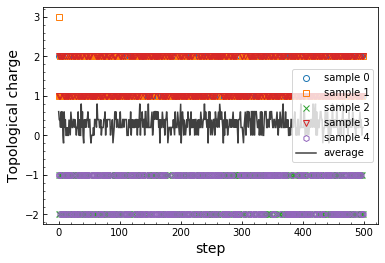

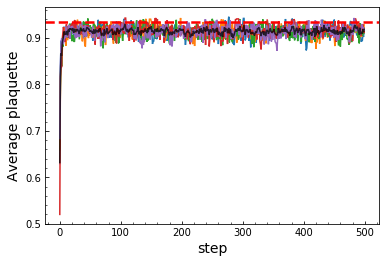

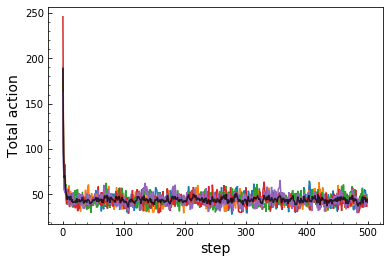

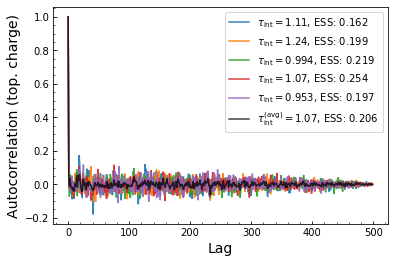

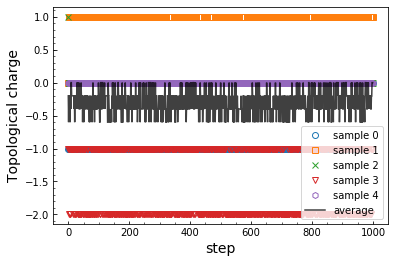

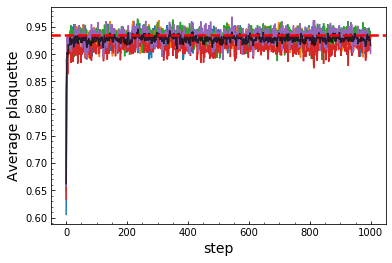

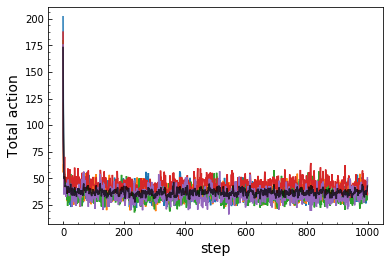

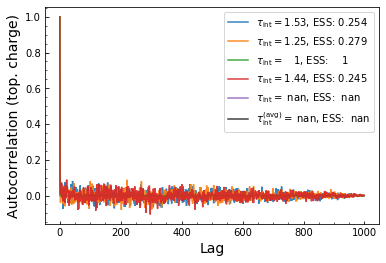

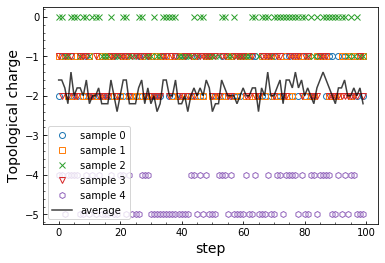

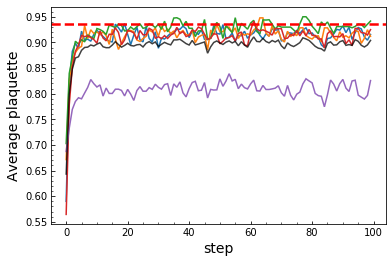

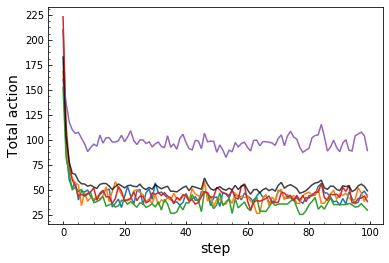

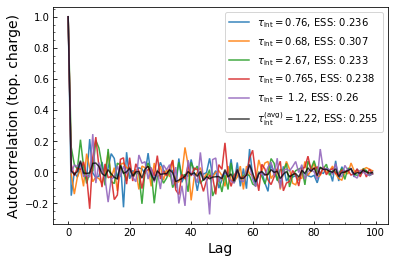

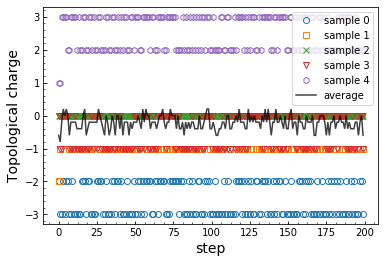

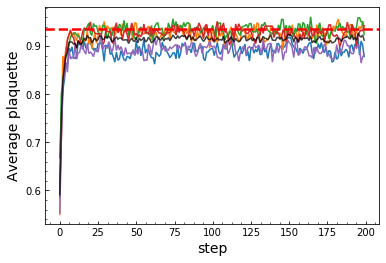

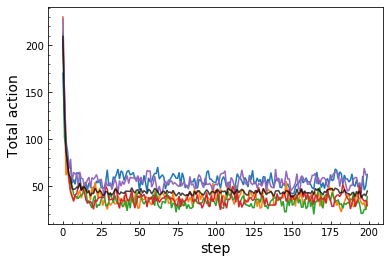

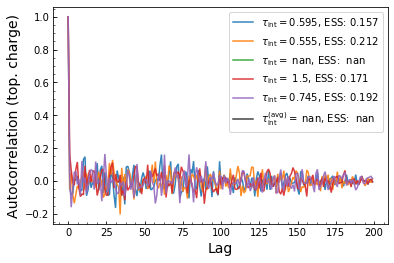

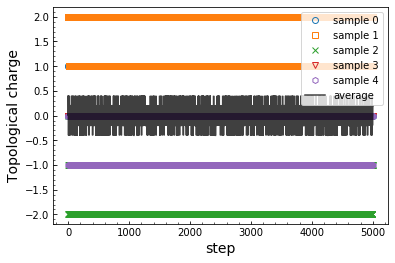

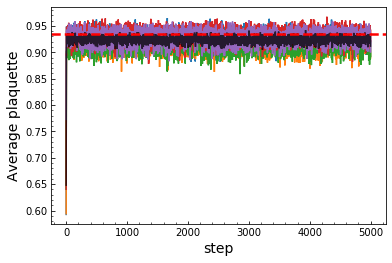

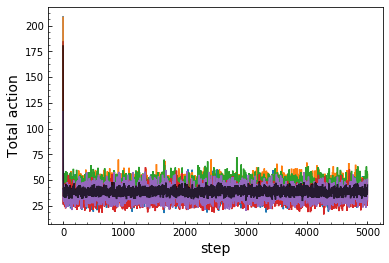

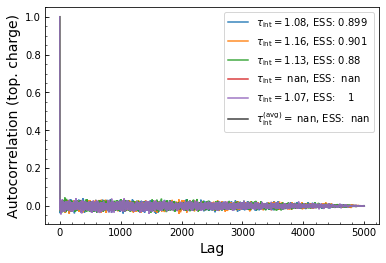

In [76]:
for key in observables.keys():
    _figs_dir = figs_dir_dict[key]
    _actions = actions[key]
    _avg_plaquettes = avg_plaquettes[key]
    _top_charges = top_charges[key]
    _top_charges_autocorr = top_charges_autocorr[key]
    _observables = (_actions, _avg_plaquettes, _top_charges)
    
    figs_axes = make_multiple_lines_plots(
        params['beta_final'], 
        _observables,
        _figs_dir, 
    )
    
    _acf_arr = acf_dict[key]
    _iat_arr = iat_dict[key]
    _ess_arr = ess_dict[key]
    fig, ax = _plot_individual_acf_iat(_acf_arr, _iat_arr, _ess_arr, _figs_dir)

#### Topological charge history

Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_figs/top_charge_history_sample_0.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_figs/top_charge_history_sample_1.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_figs/top_charge_history_sample_2.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_figs/top_charge_history_sample_3.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_figs/top_charge_history_sample_4.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_1000/top_charges_figs/top_charge_history_sample_0.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_1000/top_charges_figs/top_charge_history_sample_1.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_1000/top_charges_figs/top_charge_history_sample_2.pdf.
Saving figure to: ../../gauge_logs_graph/run_

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_figs/top_charge_history_sample_0.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_figs/top_charge_history_sample_1.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_figs/top_charge_history_sample_2.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_figs/top_charge_history_sample_3.pdf.
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_figs/top_charge_history_sample_4.pdf.


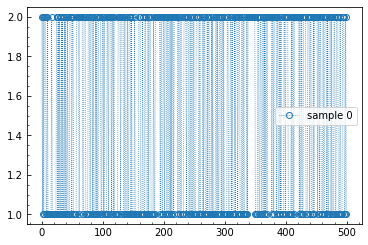

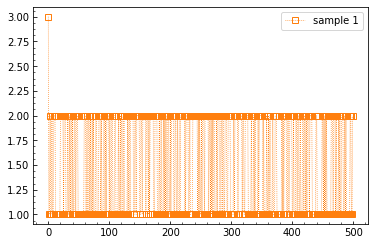

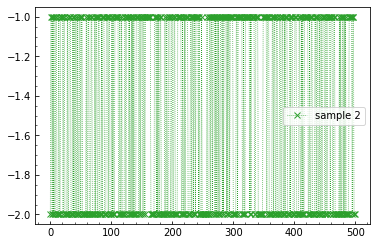

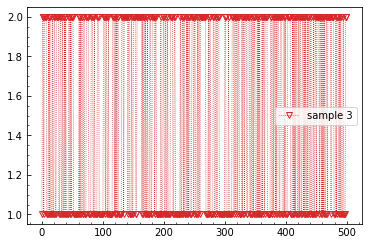

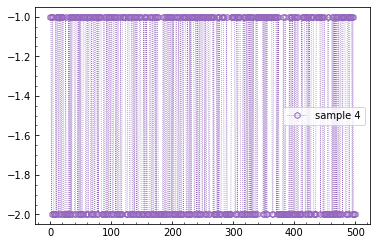

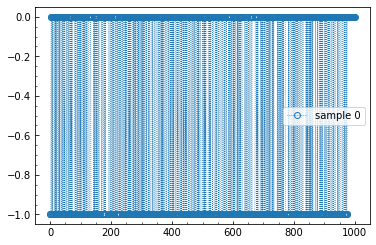

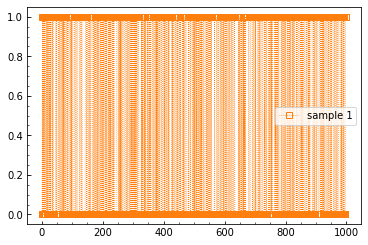

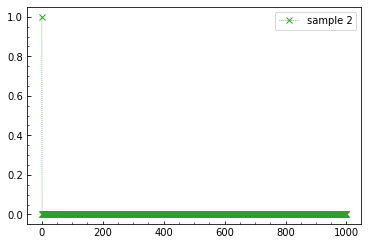

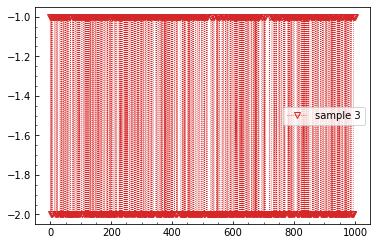

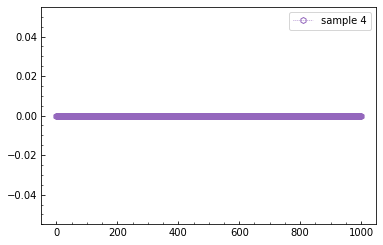

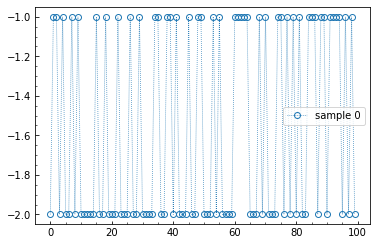

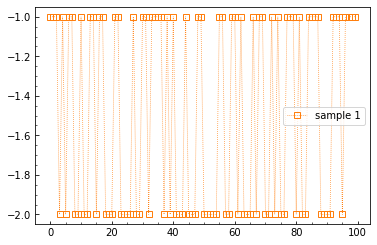

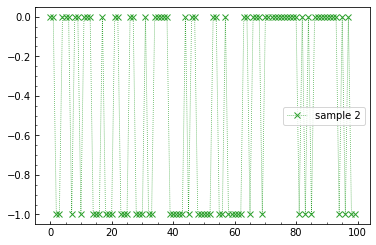

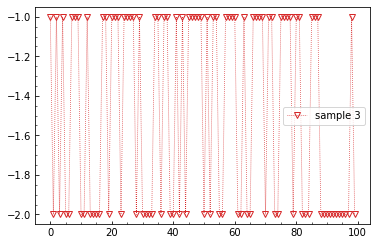

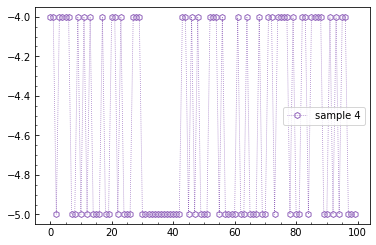

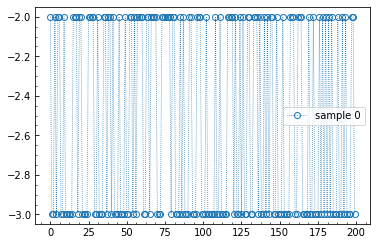

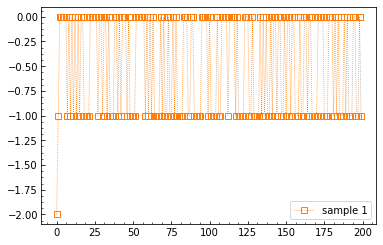

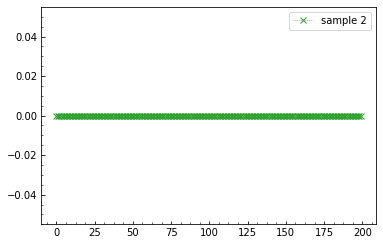

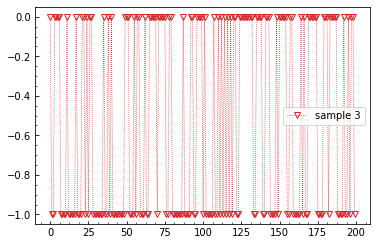

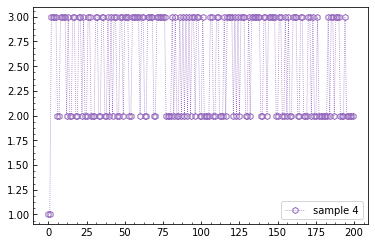

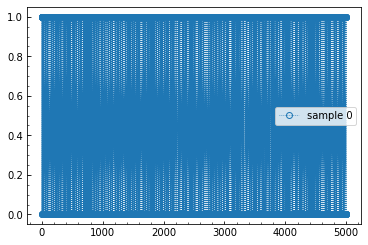

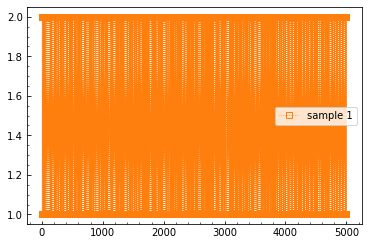

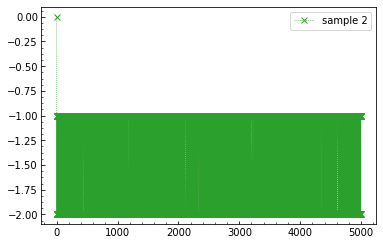

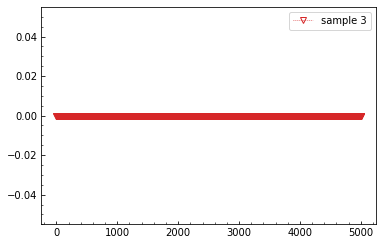

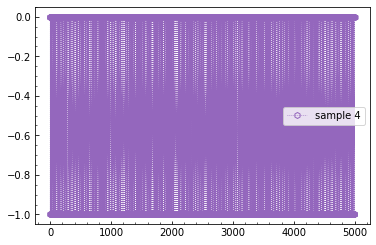

In [82]:
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_figs')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        _ = ax.plot(val[:, idx], label=f'sample {idx}', 
                    color=COLORS[idx], marker=MARKERS[idx], fillstyle='none', 
                    ls=':', lw=0.75)
        _ = ax.legend(loc='best')
        out_file = os.path.join(fig_dir, 
                                f'top_charge_history_sample_{idx}.pdf')
        print(f'Saving figure to: {out_file}.')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

#### Histograms for topological charge

Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_histograms/top_charge_history_sample_2_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_histograms/top_charge_history_sample_3_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_500/top_charges_histograms/top_charge_history_sample_4_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_1000/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_1000/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/fig

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_histograms/top_charge_history_sample_2_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_histograms/top_charge_history_sample_3_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_144/figures/figures_5000/top_charges_histograms/top_charge_history_sample_4_histogram.pdf


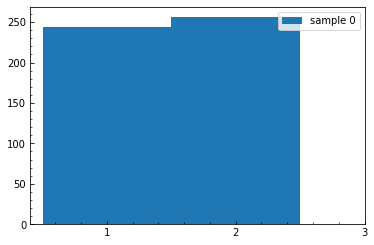

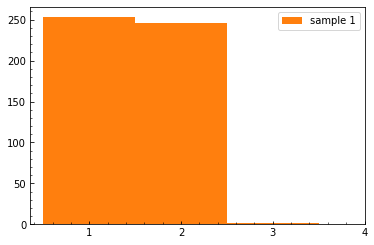

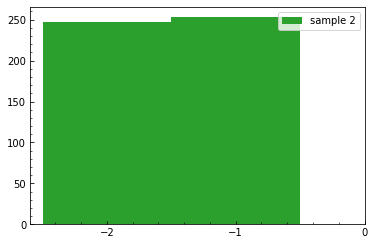

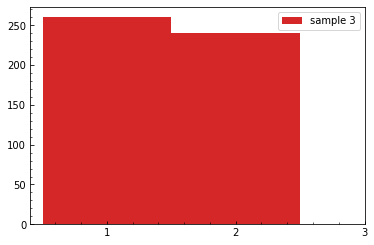

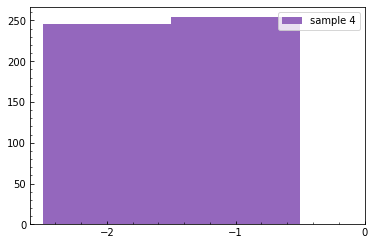

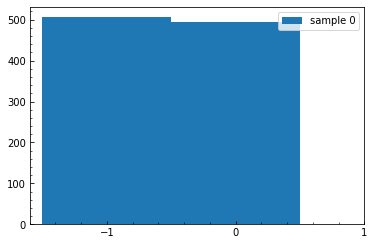

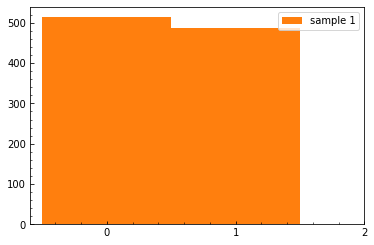

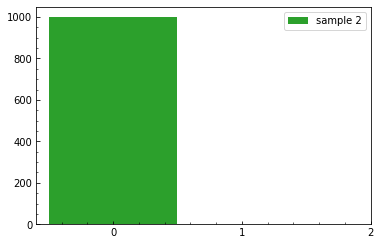

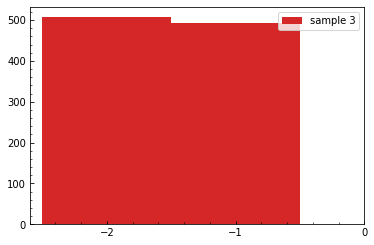

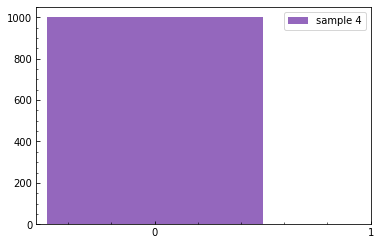

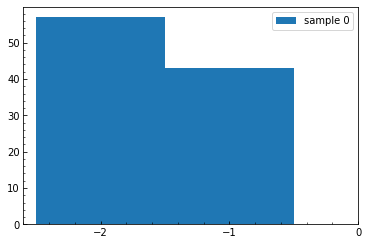

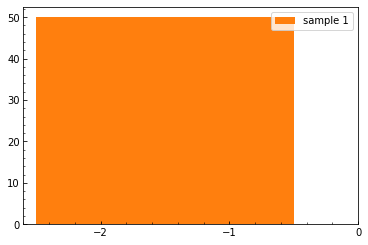

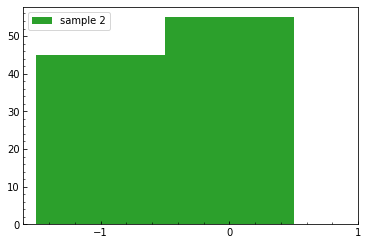

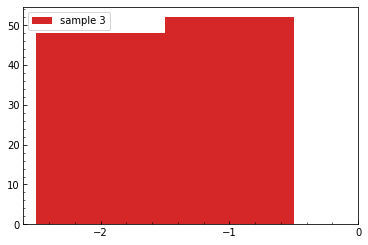

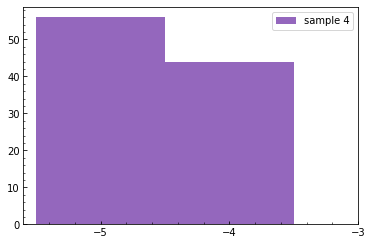

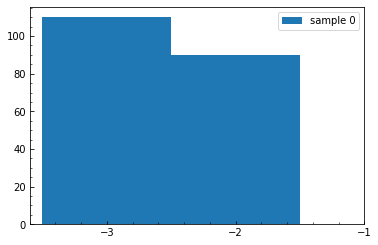

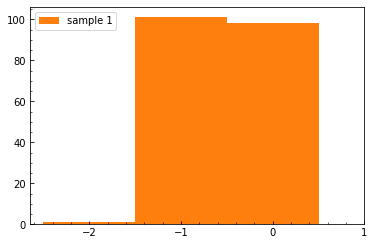

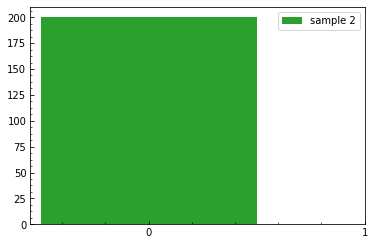

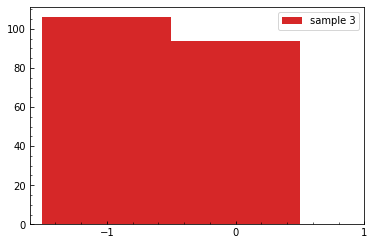

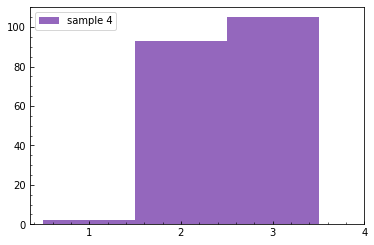

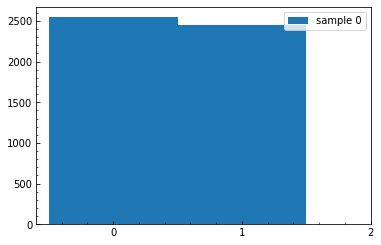

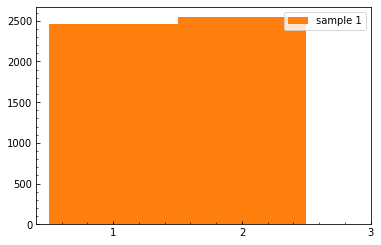

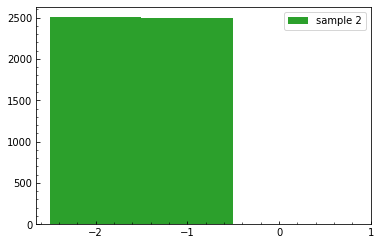

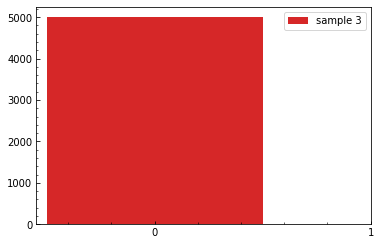

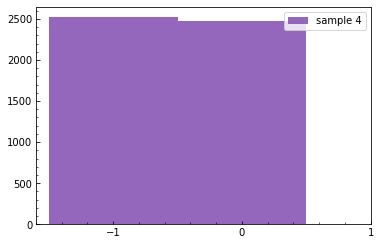

In [84]:
plt.close('all')
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_histograms')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        # the trick is to set up the bins centered on the integers, i.e.
        # -0.5, 0.5, 1,5, 2.5, ... up to max(data) + 1.5. 
        # Then you substract -0.5 to # eliminate the extra bin at the end.
        bins = np.arange(val[:, idx].min(), val[:, idx].max() + 1.5) - 0.5
        _ = ax.hist(
            val[:, idx], 
            bins, 
            color=COLORS[idx], 
            label=f'sample {idx}'
        )
        _ = ax.set_xticks(bins + 0.5)
        #ax.hist(val[:, idx])
        _ = ax.legend(loc='best')
        out_file = os.path.join(
            fig_dir, 
            f'top_charge_history_sample_{idx}_histogram.pdf'
        )
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Look at observables from samples generated during training 

In [38]:
from utils.gauge_observables import (
    _load_samples_from_file, _load_params, _calc_observables,
)

In [39]:
#log_dir = (
#    '../../gauge_logs_graph/run_96/'
#)
log_dir = '../../gauge_logs_graph/run_144/'
samples_dir = os.path.join(log_dir, 'samples_history/')
train_samples_dir = os.path.join(samples_dir, 'training/')

params = _load_params(log_dir)

figs_dir = os.path.join(log_dir, 'figures')
samples_dict, actions_dict, plaqs_dict, charges_dict = {}, {}, {}, {}

In [59]:
train_samples_files = [train_samples_dir + i 
                       for i in os.listdir(train_samples_dir) 
                       if i.endswith('.pkl')]
train_samples_files

['../../gauge_logs_graph/run_144/samples_history/training/samples_history_1000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_5000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_2500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_4000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_3500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_3000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_4500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_2000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_144/samples_history/training/samples_history_1500_TRAIN_100.pkl']

In [60]:
step_keys = [int(i.split('/')[-1].split('_')[2]) for i in train_samples_files]
step_keys

[1000, 5000, 2500, 500, 4000, 3500, 3000, 4500, 2000, 1500]

In [61]:
for idx, sample_file in enumerate(train_samples_files):
    step = step_keys[idx]
    if step not in charges_dict.keys():
        print(f"Calculating observables for {step}...")
        with open(sample_file, 'rb') as f:
            samples = pickle.load(f)

        actions, plaqs, charges = _calc_observables(samples, params)

        actions_dict[step] = actions
        plaqs_dict[step] = plaqs
        charges_dict[step] = charges

Calculating observables for 5000...
step: 0 time/step: 0.1832 avg action:  170   avg plaquette: 0.668  top charges: 


[0, 0, -2, 0, 0]


step: 1 time/step: 0.1525 avg action: 88.73  avg plaquette: 0.8267 top charges: 


[0, 0, -1, 0, 1]


step: 2 time/step: 0.1421 avg action: 59.91  avg plaquette: 0.883  top charges: 


[0, 0, -2, 0, 0]


step: 3 time/step: 0.331  avg action: 49.87  avg plaquette: 0.9026 top charges: 


[0, 0, -1, 0, 1]


step: 4 time/step: 0.144  avg action: 41.27  avg plaquette: 0.9194 top charges: 


[0, 0, -1, 0, 0]


step: 5 time/step: 0.161  avg action: 40.75  avg plaquette: 0.9204 top charges: 


[0, 0, -2, 0, 1]


step: 6 time/step: 0.1103 avg action: 40.25  avg plaquette: 0.9214 top charges: 


[0, 0, -1, 0, 1]


step: 7 time/step: 0.09228 avg action: 37.68  avg plaquette: 0.9264 top charges: 


[0, 0, -1, 0, 1]


step: 8 time/step: 0.06892 avg action: 40.39  avg plaquette: 0.9211 top charges: 


[0, 0, -1, 0, 0]


step: 9 time/step: 0.07674 avg action:  44.5

step: 80 time/step: 0.097  avg action: 35.79  avg plaquette: 0.9301 top charges: 


[0, 0, -2, 0, 0]


step: 81 time/step: 0.1088 avg action: 32.29  avg plaquette: 0.9369 top charges: 


[0, 0, -1, 0, 1]


step: 82 time/step: 0.113  avg action: 35.87  avg plaquette: 0.9299 top charges: 


[0, 0, -1, 0, 1]


step: 83 time/step: 0.1443 avg action: 40.01  avg plaquette: 0.9219 top charges: 


[0, 0, -1, 0, 0]


step: 84 time/step: 0.1157 avg action: 36.32  avg plaquette: 0.9291 top charges: 


[0, 0, -1, 0, 1]


step: 85 time/step: 0.1298 avg action: 41.73  avg plaquette: 0.9185 top charges: 


[0, 0, -2, 0, 0]


step: 86 time/step: 0.1077 avg action: 35.31  avg plaquette: 0.931  top charges: 


[0, 0, -2, 0, 0]


step: 87 time/step: 0.1085 avg action: 29.08  avg plaquette: 0.9432 top charges: 


[0, 0, -1, 0, 0]


step: 88 time/step: 0.1258 avg action: 31.53  avg plaquette: 0.9384 top charges: 


[0, 0, -2, 0, 1]


step: 89 time/step: 0.148  avg action: 35.17  avg plaquette: 0.9313 top c

step: 61 time/step: 0.1086 avg action: 39.83  avg plaquette: 0.9222 top charges: 


[-1, 0, 3, 0, 0]


step: 62 time/step: 0.09185 avg action: 42.58  avg plaquette: 0.9168 top charges: 


[-1, 0, 3, 0, 0]


step: 63 time/step: 0.1049 avg action:  38.3  avg plaquette: 0.9252 top charges: 


[0, 0, 3, 1, 0]


step: 64 time/step: 0.1608 avg action: 39.54  avg plaquette: 0.9228 top charges: 


[0, 1, 3, 1, 0]


step: 65 time/step: 0.1599 avg action: 39.57  avg plaquette: 0.9227 top charges: 


[0, 0, 2, 1, 0]


step: 66 time/step: 0.133  avg action: 39.09  avg plaquette: 0.9236 top charges: 


[0, 1, 3, 1, 0]


step: 67 time/step: 0.1282 avg action: 40.53  avg plaquette: 0.9208 top charges: 


[-1, 1, 3, 1, 0]


step: 68 time/step: 0.1567 avg action: 42.25  avg plaquette: 0.9175 top charges: 


[-1, 0, 3, 1, 0]


step: 69 time/step: 0.1168 avg action: 37.47  avg plaquette: 0.9268 top charges: 


[0, 0, 3, 0, 0]


step: 70 time/step: 0.1189 avg action:   40   avg plaquette: 0.9219 top charg

step: 40 time/step: 0.1123 avg action: 37.45  avg plaquette: 0.9269 top charges: 


[-1, -1, 0, 0, 0]


step: 41 time/step: 0.1022 avg action: 39.35  avg plaquette: 0.9231 top charges: 


[-1, 0, 0, 0, 0]


step: 42 time/step: 0.1074 avg action: 38.88  avg plaquette: 0.9241 top charges: 


[-1, 0, 0, -1, 0]


step: 43 time/step: 0.145  avg action: 35.72  avg plaquette: 0.9302 top charges: 


[-2, -1, 0, -1, -1]


step: 44 time/step: 0.1621 avg action: 40.76  avg plaquette: 0.9204 top charges: 


[-1, -1, 0, 0, 0]


step: 45 time/step: 0.09009 avg action: 36.46  avg plaquette: 0.9288 top charges: 


[-2, -1, 0, 0, 0]


step: 46 time/step: 0.09861 avg action: 37.02  avg plaquette: 0.9277 top charges: 


[-1, -1, 0, 0, -1]


step: 47 time/step: 0.09593 avg action: 37.18  avg plaquette: 0.9274 top charges: 


[-1, 0, 0, 0, 0]


step: 48 time/step: 0.09524 avg action: 39.62  avg plaquette: 0.9226 top charges: 


[-1, -1, 0, 0, -1]


step: 49 time/step: 0.09777 avg action: 36.85  avg plaquet

step: 20 time/step: 0.1226 avg action:  30.6  avg plaquette: 0.9402 top charges: 


[0, 0, 0, 0, -1]


step: 21 time/step: 0.1403 avg action:   37   avg plaquette: 0.9277 top charges: 


[0, 0, 0, 1, 0]


step: 22 time/step: 0.1274 avg action: 36.87  avg plaquette: 0.928  top charges: 


[0, 0, 0, 1, 0]


step: 23 time/step: 0.1282 avg action: 29.19  avg plaquette: 0.943  top charges: 


[0, 0, 0, 1, 0]


step: 24 time/step: 0.142  avg action:  36.1  avg plaquette: 0.9295 top charges: 


[0, 0, 0, 1, -1]


step: 25 time/step: 0.113  avg action: 35.83  avg plaquette:  0.93  top charges: 


[0, 0, 0, 0, 0]


step: 26 time/step: 0.1104 avg action: 30.95  avg plaquette: 0.9395 top charges: 


[0, 0, 0, 1, 0]


step: 27 time/step: 0.1106 avg action: 32.96  avg plaquette: 0.9356 top charges: 


[0, 0, 0, 0, 0]


step: 28 time/step: 0.164  avg action: 34.38  avg plaquette: 0.9329 top charges: 


[0, 0, 0, 0, 0]


step: 29 time/step: 0.1722 avg action: 32.45  avg plaquette: 0.9366 top charges:

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


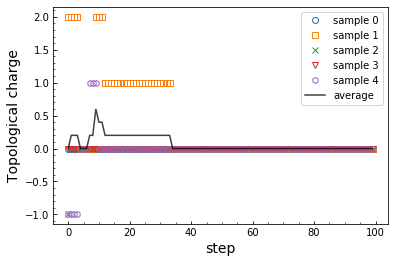

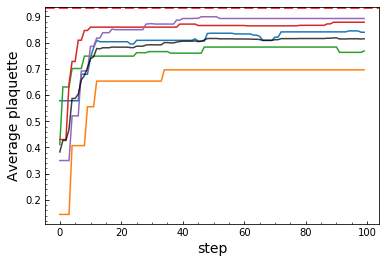

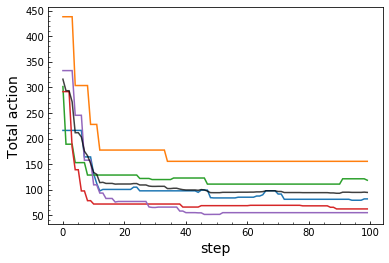

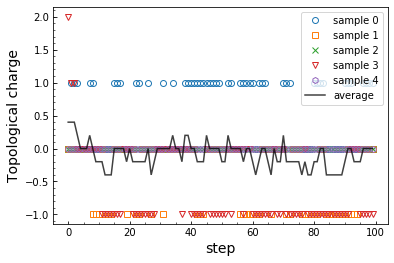

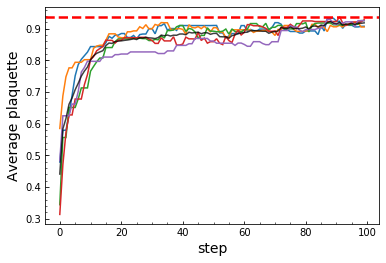

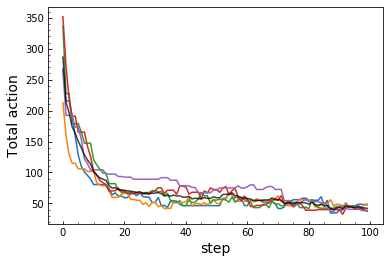

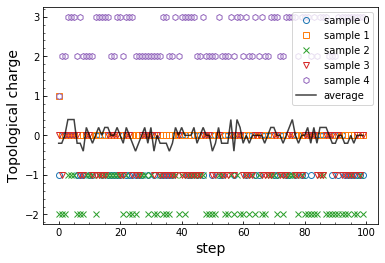

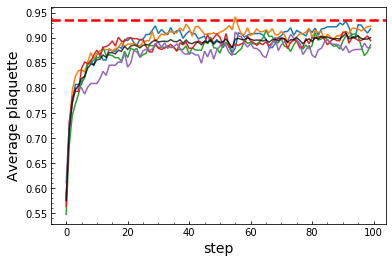

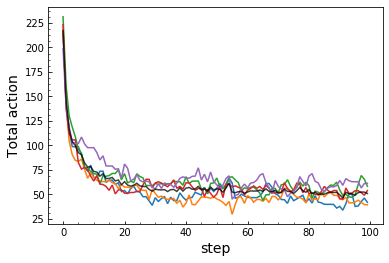

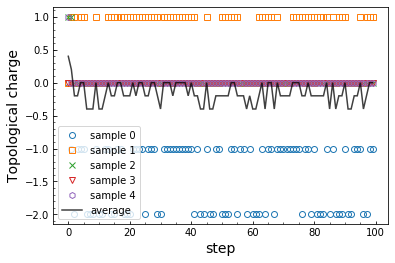

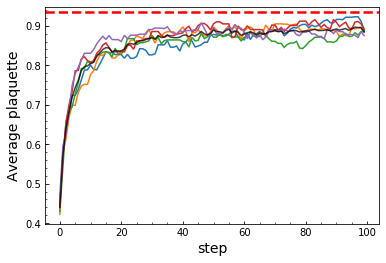

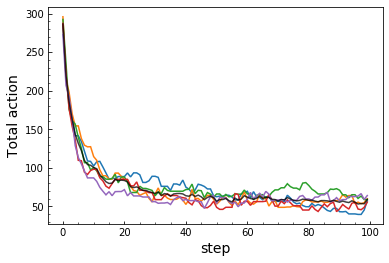

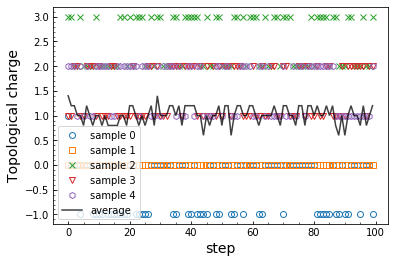

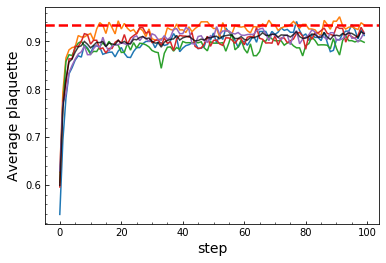

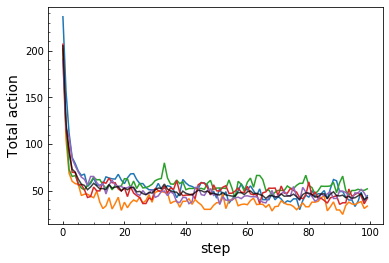

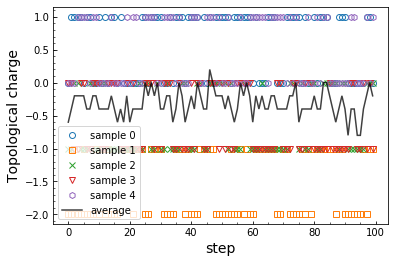

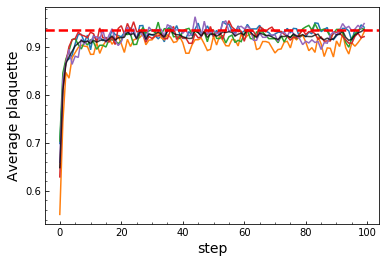

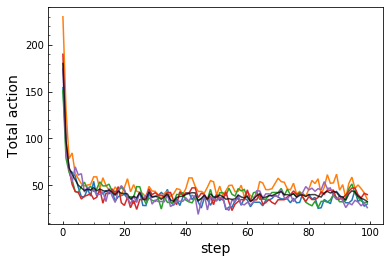

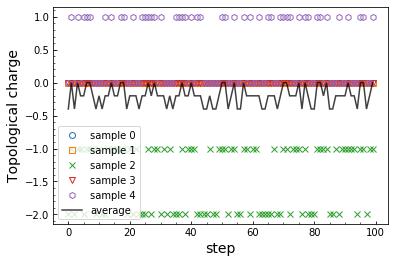

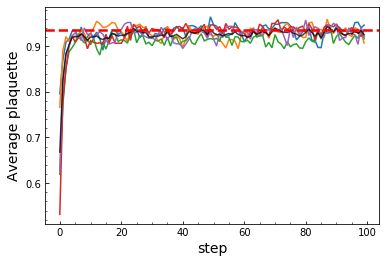

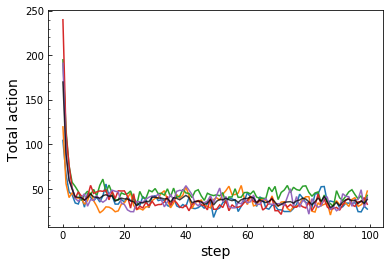

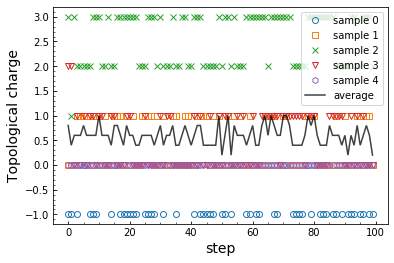

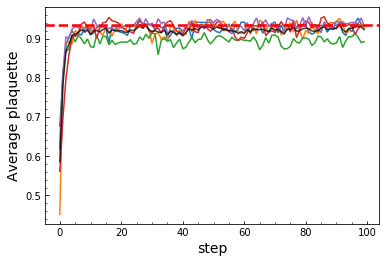

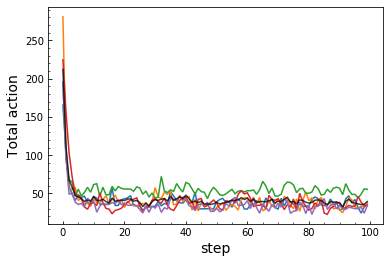

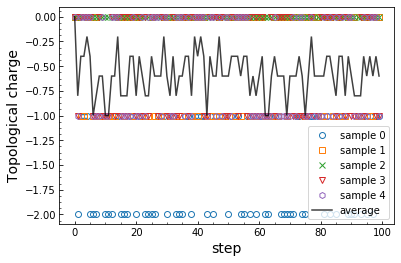

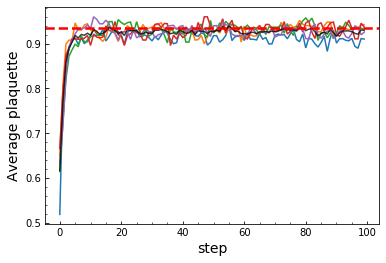

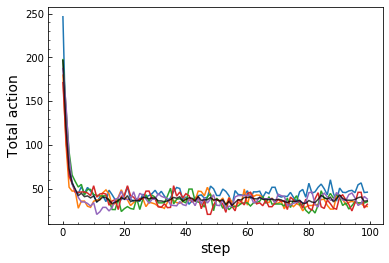

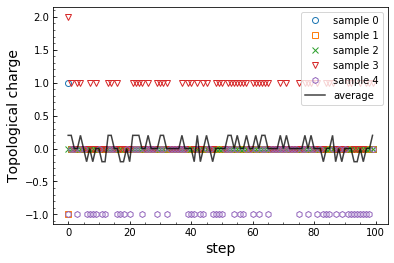

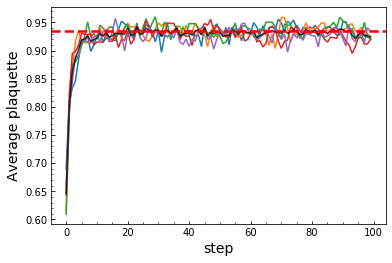

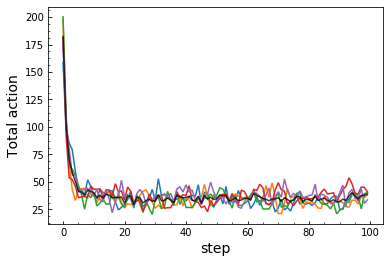

In [62]:
for key in charges_dict.keys():
    actions = actions_dict[key]
    plaqs = plaqs_dict[key]
    charges = charges_dict[key]
    observables = (actions, plaqs, charges)
    
    figs_axes = make_multiple_lines_plots(params['beta_final'], observables)

In [63]:
charges_dict.keys()

dict_keys([500, 1000, 2000, 1500, 2500, 3000, 5000, 4000, 3500, 4500])

In [64]:
charges_dict[500].shape

(100, 5)

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


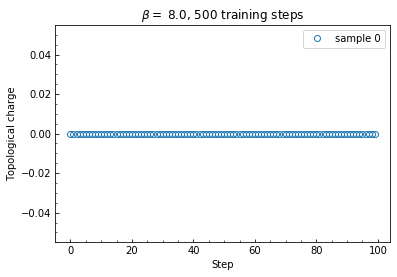

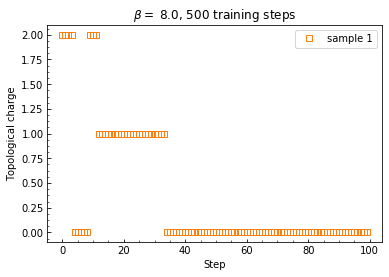

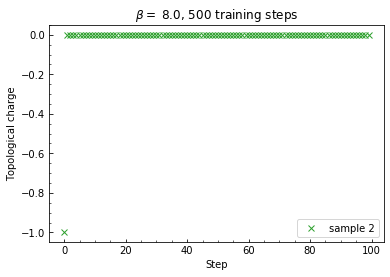

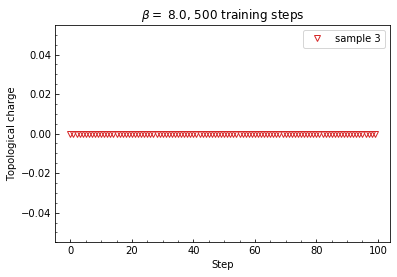

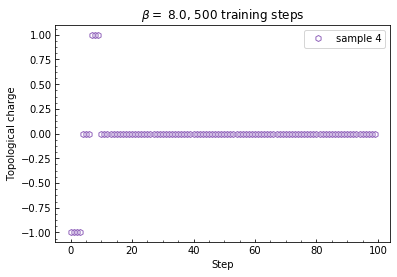

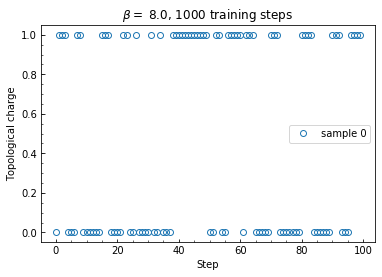

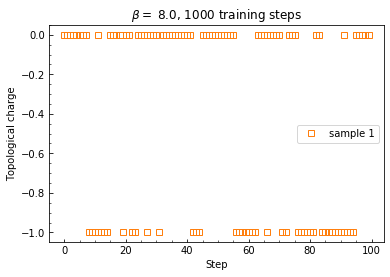

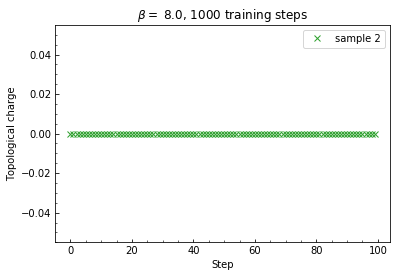

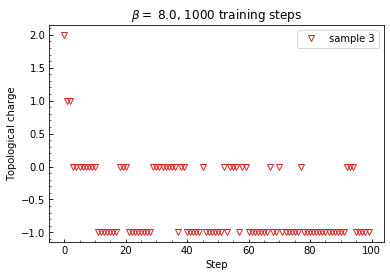

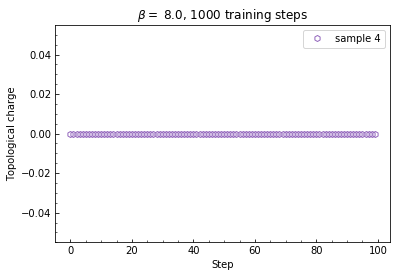

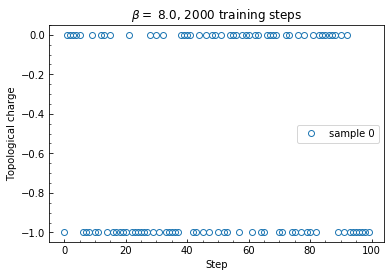

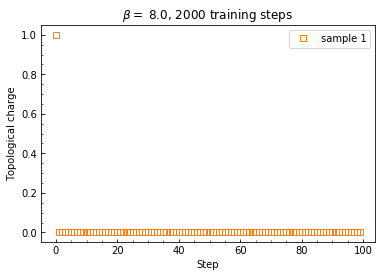

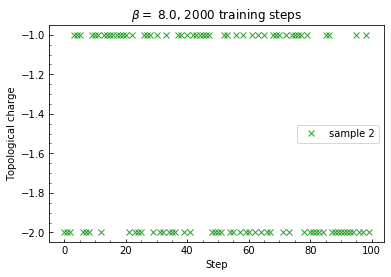

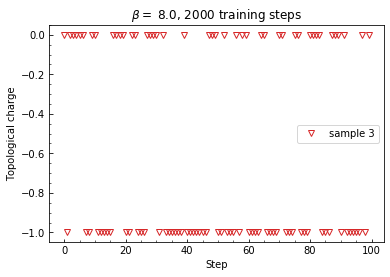

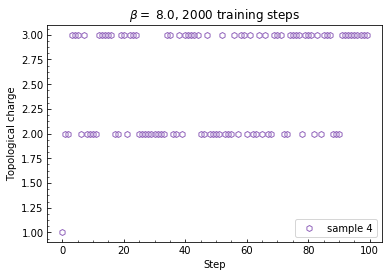

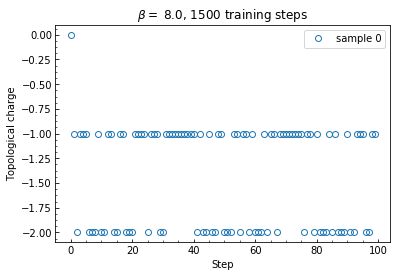

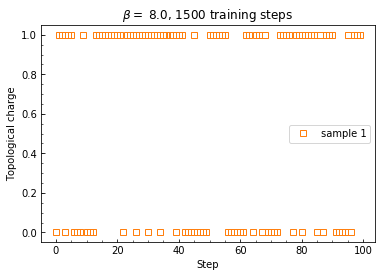

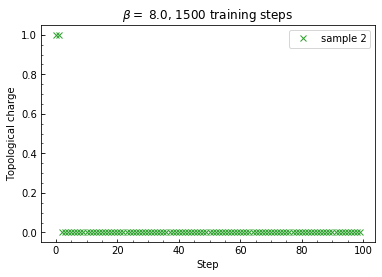

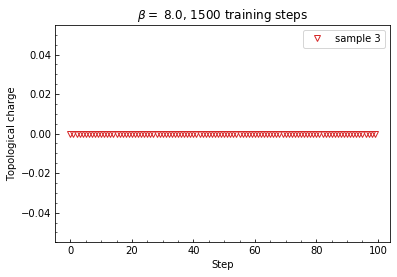

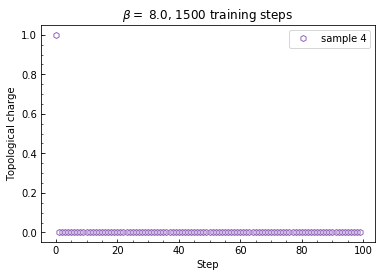

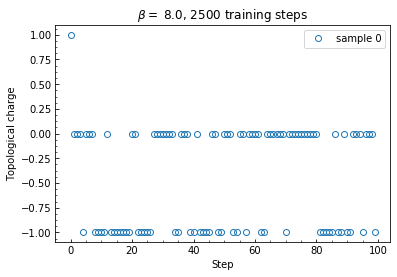

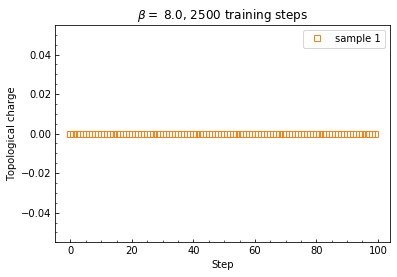

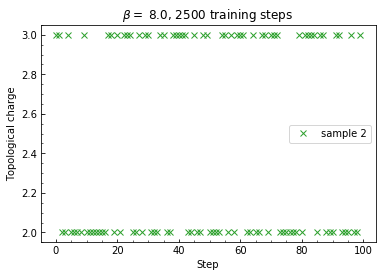

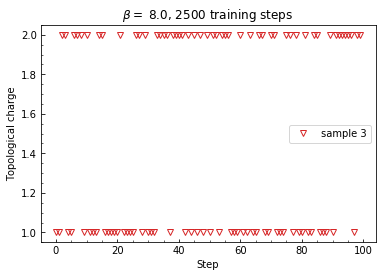

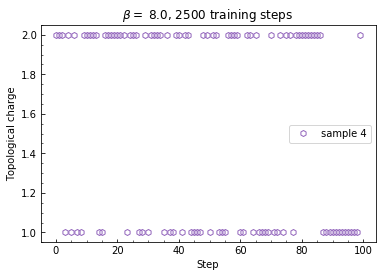

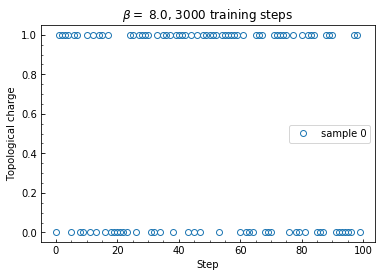

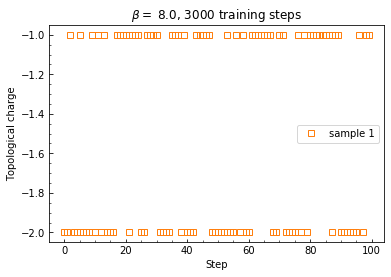

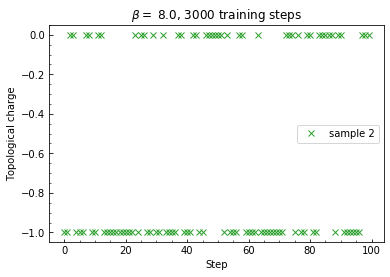

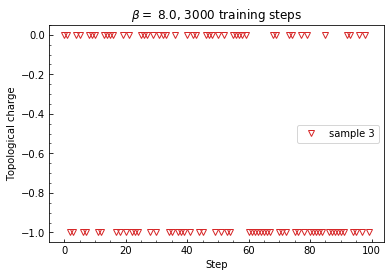

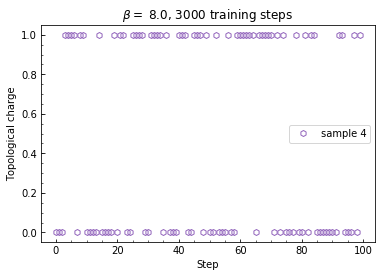

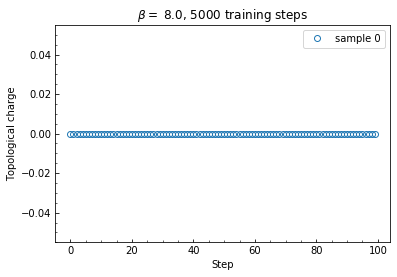

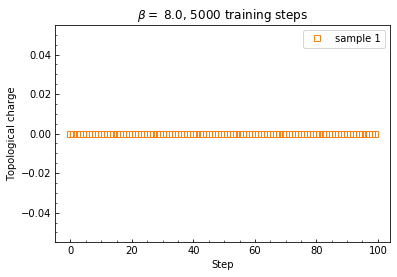

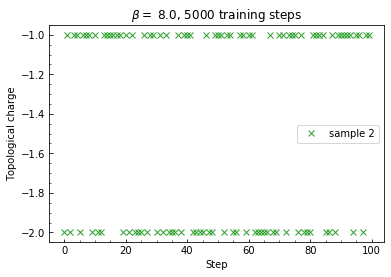

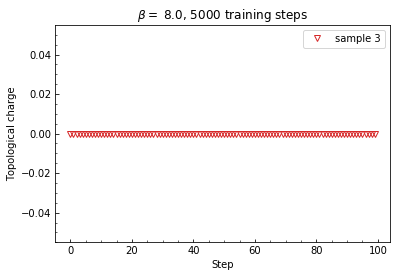

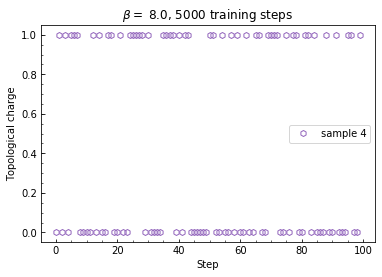

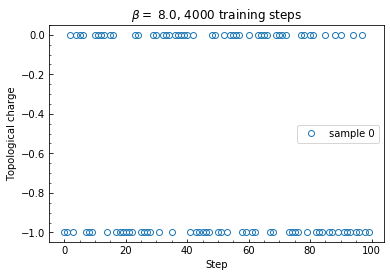

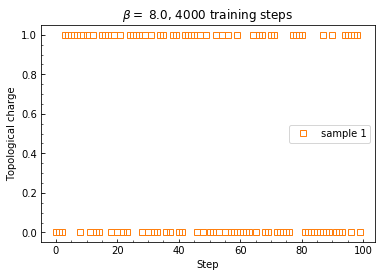

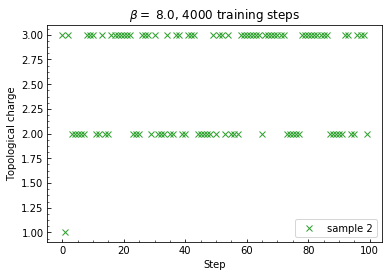

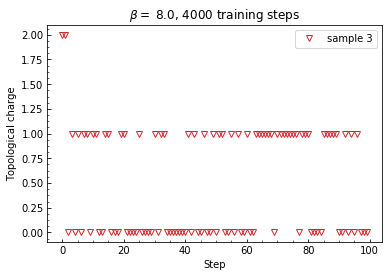

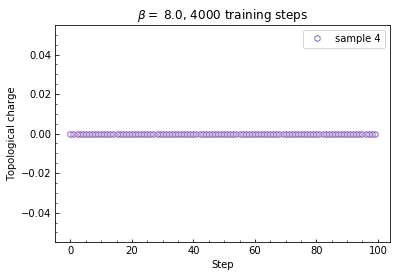

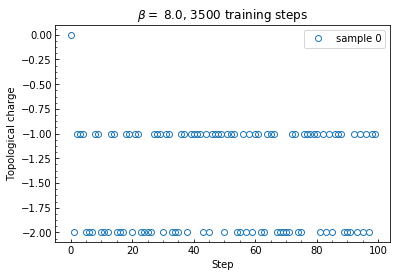

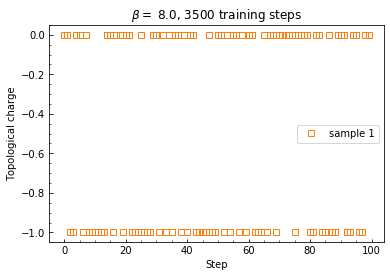

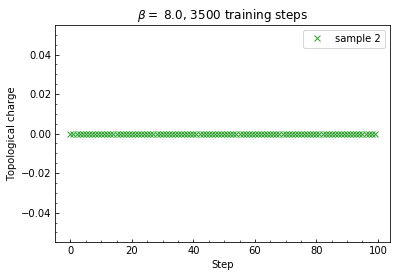

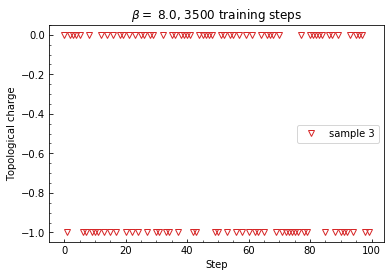

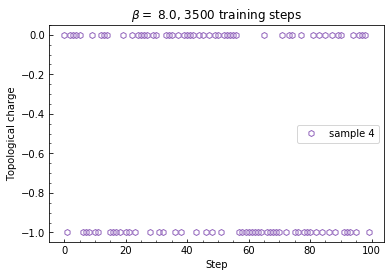

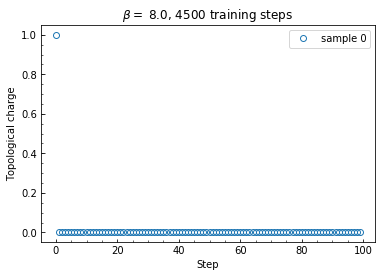

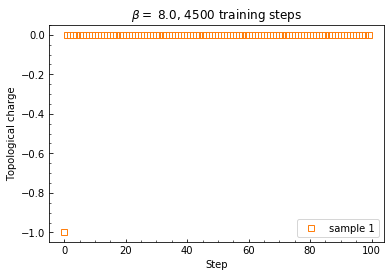

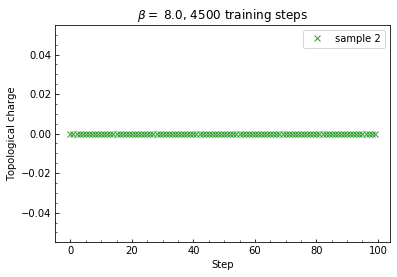

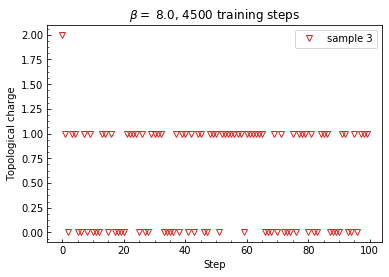

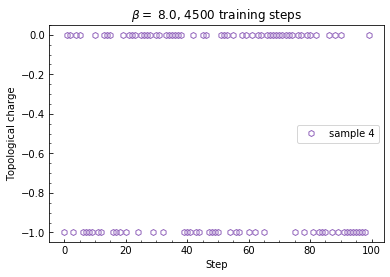

In [71]:
plt.close('all')
for key, val in charges_dict.items():
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        _ = ax.plot(val[:, idx], 
                    marker=MARKERS[idx], color=COLORS[idx], 
                    ls='', fillstyle='none', label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Step')
        _ = ax.set_ylabel('Topological charge')
        _ = ax.set_title(fr"""$\beta =$ {params['beta_final']},"""
                         fr""" {key} training steps""")

## OLD PLOTS

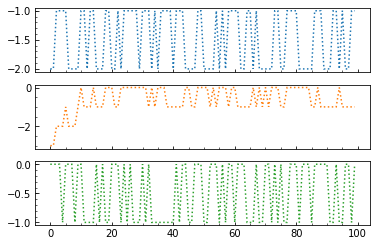

In [28]:
ax1 = plt.subplot(311)
_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(312, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(313, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
#_ = plt.setp(ax3.get_xticklabels(), visible=False)

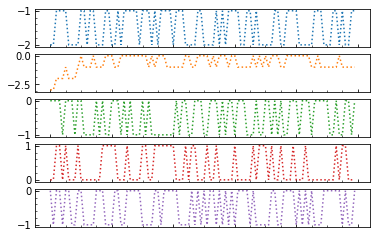

In [27]:
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

ax1 = plt.subplot(511)

_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(512, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(513, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
_ = plt.setp(ax3.get_xticklabels(), visible=False)

_ = ax4 = plt.subplot(514, sharex=ax1)
_ = plt.plot(top_charges[100][:, 3], label=f'sample 4', color='C3', ls=':')
             #markersize=2.5, marker=MARKERS[3], ls=':')
_ = plt.setp(ax4.get_xticklabels(), visible=False)

_ = ax5 = plt.subplot(515, sharex=ax1)
_ = plt.plot(top_charges[100][:, 4], label=f'sample 5', color='C4', ls=':')
             #markersize=2.5, marker=MARKERS[4], ls=':')
_ = plt.setp(ax5.get_xticklabels(), visible=False)

out_file = os.path.join(figs_dir_dict[100], 'top_charges_sharedx.pdf')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [116]:
plt.close('all')

In [ ]:
# Create plots for observables.
multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

    
# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/autocorrelation_plots/pandas_autocorrel

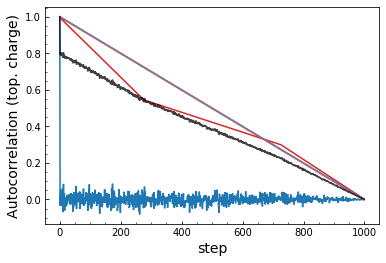

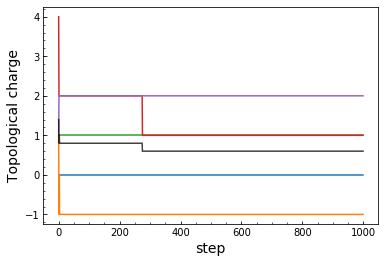

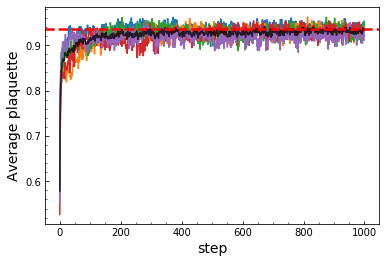

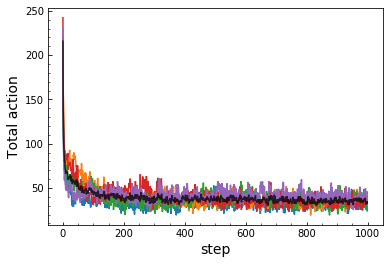

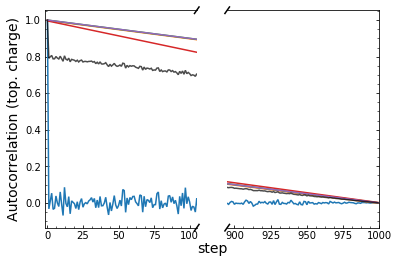

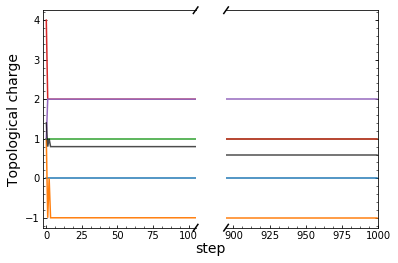

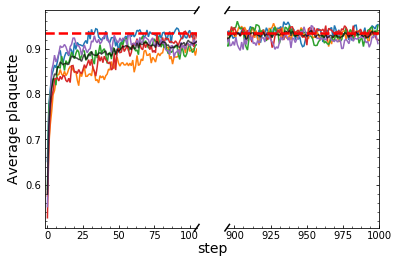

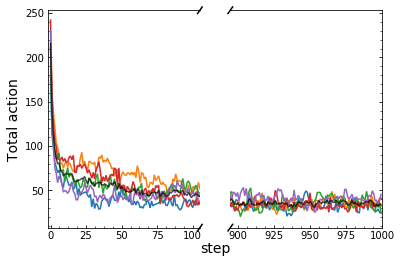

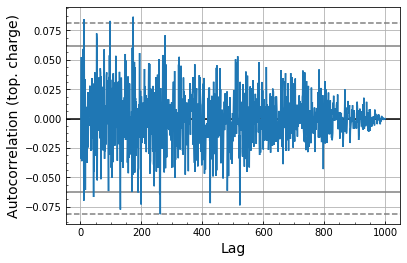

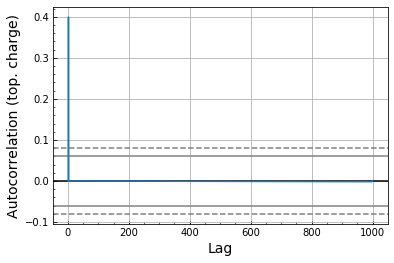

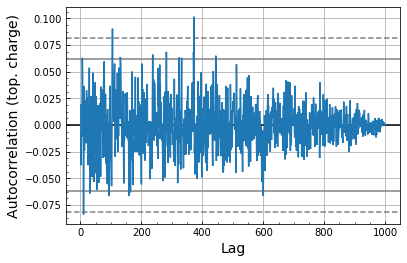

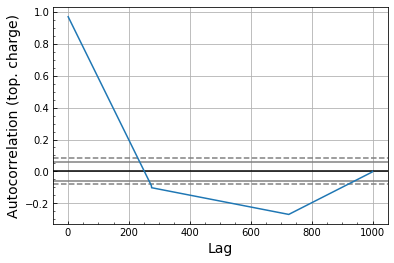

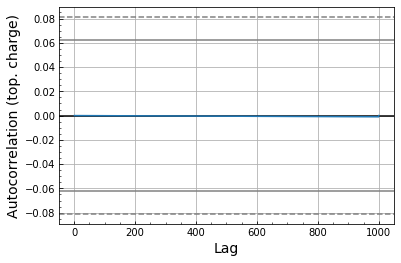

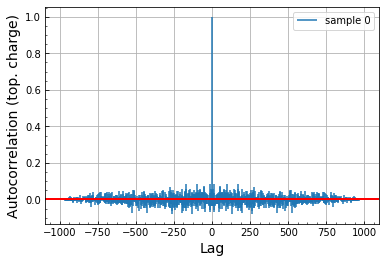

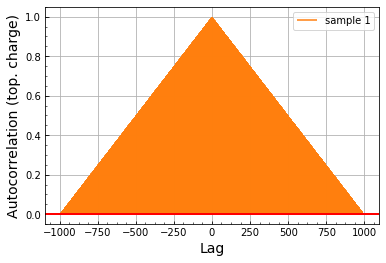

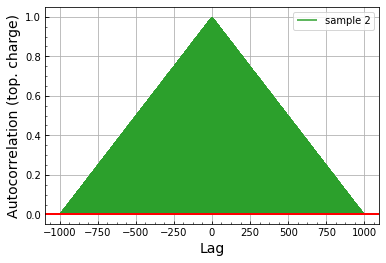

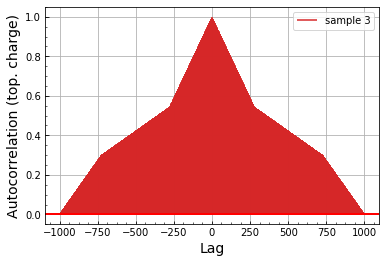

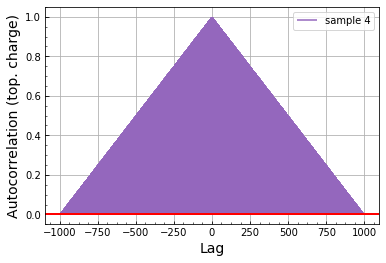

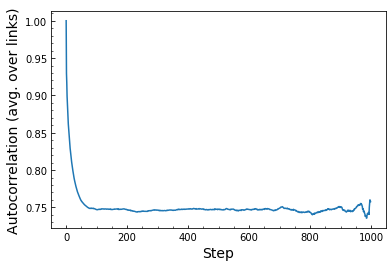

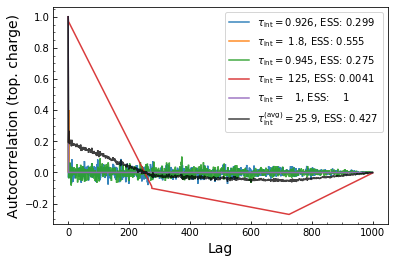

In [8]:
# Create plots for observables.

multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [81]:
plt.close('all')

Saving figure to: ../../gauge_logs_graph/run_19/figures/integrated_autocorrelation_time_plot.pdf.


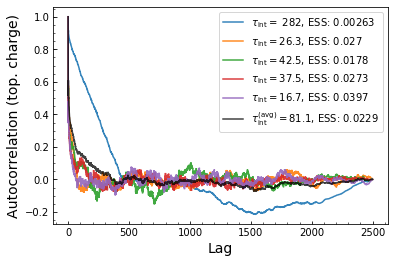

In [24]:
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)

# OLD

In [ ]:
np.mean(ESS_arr)

Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/matplotlib_autocorrelation_plots/top_charges_autocorr_matplotlib.pdf.


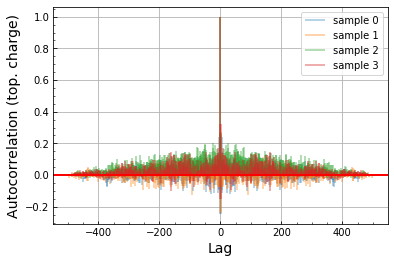

In [224]:
alphas = [0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 
          0.15, 0.125, 0.1, 0.075, 0.05, 0.025][::-1]
out_file = os.path.join(matplotlib_autocorr_dir, 
                        'top_charges_autocorr_matplotlib.pdf')
fig, ax = plt.subplots()
for idx in range(top_charges.shape[1]):
    output = ax.acorr(top_charges[:, idx], usevlines=True, color=COLORS[idx],
                      normed=True, maxlags=None,
                      alpha=alphas[idx]+0.4, #zorder=zorders[idx],
                      label=f'sample {idx}')

_ = ax.axhline(0, color='r', lw=2)
_ = ax.grid(True)
_ = ax.legend(loc='best')
    
_ = ax.set_xlabel("Lag", fontsize=14)
_ = ax.set_ylabel("Autocorrelation (top. charge)", fontsize=14)
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [300]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 5, False)

In [301]:
lattice.num_links

128

##### Old approach (unsure of validity)

In [25]:
len_by_4 = len(top_charges) // 4
len_by_2 = len(top_charges) // 2
len_by_10 = len(top_charges) // 10
kappa4 = len(top_charges) - len_by_4
kappa2 = len(top_charges) - len_by_2
kappa10 = len(top_charges) - len_by_10
iac2, autocorr2 = calc_iat(top_charges.mean(axis=1), kappa=kappa2)
iac4, autocorr4 = calc_iat(top_charges.mean(axis=1), kappa=kappa4)
iac10, autocorr10 = calc_iat(top_charges.mean(axis=1), kappa=kappa10)

In [26]:
iac2, iac4, iac10

(2.1520862694468614, 1.5014179402207577, 1.9374474465140532)

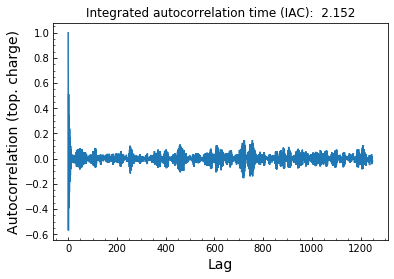

In [27]:
out_file = os.path.join(autocorr_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa2}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr2)), autocorr2, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac2:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

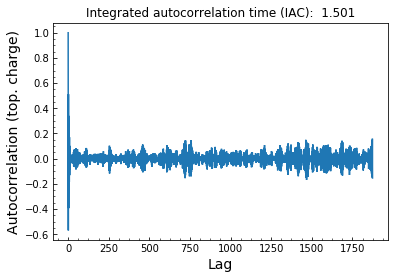

In [28]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa4}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr4)), autocorr4, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac4:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

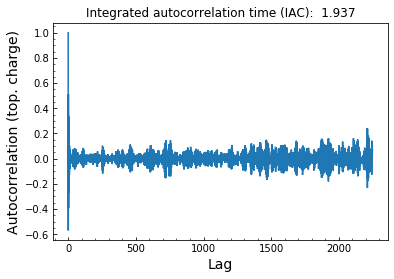

In [29]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa10}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr10)), autocorr10, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac10:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Old method (make each plot by hand)

### Specify run directory containing parameters and samples 

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [ ]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [ ]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [ ]:
np.array(samples_history).shape

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [ ]:
len(samples_history[0].shape)

In [ ]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [ ]:
top_charges_autocorr_arr.shape

In [ ]:
top_charges_autocorr_avg.shape

In [ ]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

In [ ]:
samples_history.shape

In [ ]:
samples_autocorr_arr.shape

In [ ]:
samples_autocorr_arr_avg.shape

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

In [ ]:
len(steps)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 #xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge',
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(895, 1000),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
from lattice.gauge_lattice import u1_plaq_exact

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(895, 1000),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, actions_history.T,
                              x_label='step', y_label='Average plaquette')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(895, 1000),
                                 output_file=out_file)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from utils.gauge_observables import *

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)

In [ ]:
actions, avg_plaquettes, top_charges = observables

beta = params['beta']
figs_dir = os.path.join(log_dir, 'figures')

In [ ]:
top_charges_autocorr, _ = calc_top_charges_autocorr(top_charges)
samples_autocorr, _ = calc_samples_autocorr(samples)

In [ ]:
from utils.gauge_observables import _make_plots

In [ ]:
multiple_lines_figs_axes, broken_xaxis_figs_axes = _make_plots(
    figs_dir, 
    beta, 
    samples, 
    observables,
    top_charges_autocorr, 
    samples_autocorr
)

In [ ]:
make_plots_from_log_dir(log_dir)

## Compare Sample Autocorrelation across runs

In [ ]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [ ]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [ ]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

In [ ]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [ ]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

### Incorrect

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [ ]:
tf.InteractiveSession.close

In [ ]:
tf.Session().close()

In [ ]:
#sess = tf.InteractiveSession()

In [ ]:
tf.reset_default_graph()

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [ ]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [ ]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [ ]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [ ]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [ ]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [ ]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [ ]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [ ]:
dataset.output_shapes

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [ ]:
dataset.apply(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [ ]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [ ]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [ ]:
dataset

In [ ]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()

In [ ]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

In [ ]:
next_element = iterator.get_next()

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
sess.run(result)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})